# AgPV Index
Exploratory data analysis for creation of an AG PV index: a composite scoring metric to identify USA counties with high cobenefits potential for agrivoltaics

* Data inputs: solar supply, weather hazards, energy burden, minority owned cropland

## Data Processing
Things to do:

* ~aggregate NREL's solar supply data by county~
* ~get relevant weather hazards data from csv file (hail and drought are positives, tornado is negative.)~
    * might start ith overall agriculture burden for positives first
* ~load energy burden data~
* ~get minoirty owned data from R2R indices to start~
* Estimate fraction of energy coops in county
    * from Energy Information Administration. Need to combine several of provided datasets:
    * Power generated/customers served by each utility, Counties each utility services, FIPS info
* Suitable crops for ag pv
* [True land footprint of solar energy](https://betterenergy.org/blog/the-true-land-footprint-of-solar-energy/)
* 8-year slope values for each state's electricity (quads)
* C-intensity of electricity for most recent year (2022) divided by the electricity (quads)
 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import regex as re

from usda_qwikstats_utils import usda_qwikstats_utils
from qwi_utils import qwi_utils
from config import usda_qwik_stats_key, qwi_key
from requests import get
from typing import Callable, Union
from Data_collection import get_usda_dfs, veggie_commodities

data_dir = 'AgPV_data'
export_dir = 'Export_data'
graph_dir = 'AgPV_graphs'

In [2]:
# get county FIPS in each AK ag district
ag_districts = 'https://www.nass.usda.gov/Data_and_Statistics/County_Data_Files/Frequently_Asked_Questions/county_list.txt'
ag_district_df = pd.read_csv(ag_districts, skiprows=range(9), sep='  ', index_col=None, usecols=[0,1])
ag_district_df = ag_district_df.rename(columns={'t': 'Ag_district', 'Unnamed: 1': 'County FIPS'})
ag_district_df = ag_district_df.reset_index(names='State')
ag_district_df['State'] = ag_district_df['State'].apply(lambda x: str(x).zfill(2))
ak_ag_district_df = ag_district_df.loc[ag_district_df['State'] == '02', :]

# get count of counties in each agg district
county_counts = ak_ag_district_df.groupby(['State', 'Ag_district'], as_index=False).count()
county_counts = county_counts.rename(columns={'County FIPS':'County Count'})
ak_ag_district_df = ak_ag_district_df.merge(county_counts, on=['State', 'Ag_district'])
ak_ag_district_df['Ag_district'] = ak_ag_district_df['Ag_district'].astype(str)
ak_ag_district_df

<ipython-input-2-065e29405494>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ag_district_df = pd.read_csv(ag_districts, skiprows=range(9), sep='  ', index_col=None, usecols=[0,1])


State Ag_district County FIPS  County Count
0     02           0         000             1
1     02          10         090             5
2     02          10         240             5
3     02          10         290             5
4     02          10         888             5
5     02          10         999             5
6     02          20         020             5
7     02          20         170             5
8     02          20         261             5
9     02          20         888             5
10    02          20         999             5
11    02          30         122             3
12    02          30         888             3
13    02          30         999             3
14    02          40         100             9
15    02          40         110             9
16    02          40         130             9
17    02          40         201             9
18    02          40         220             9
19    02          40         231             9
20    02          40         280             9
21    02          40         888             9
22    02          40         999             9
23    02          50         010            12
24    02          50         013            12
25    02          50         050            12
26    02          50         060            12
27    02          50         070            12
28    02          50         150            12
29    02          50         180            12
30    02          50         185            12
31    02          50         188            12
32    02          50         270            12
33    02          50         888            12
34    02          50         999            12
35    02          98         888             2
36    02          98         999             2
37    02          99         999             1

In [3]:
# get ag data for Alaska. They aggregate things by ag district, not county
ak_crop_dfs = []

for crop in veggie_commodities:
    
    ak_params = {'year':'2022',
                  'agg_level_desc':'county',
                  'source_desc':'census',
                  'statisticcat_desc': 'Area Harvested',
                 'state_ansi': '02',
                  'format':'JSON',
                 'commodity_desc': crop,
                 'unit_desc': 'ACRES'
                 }

    r = usda_qwikstats_utils(usda_qwik_stats_key).get_qwikstats_data(ak_params)
    df = pd.DataFrame(r.json()['data'])
    
    df = df[['state_ansi', 'asd_code', 'commodity_desc', 'Value']]
    ak_crop_dfs.append(df)
    
all_ak_crops_df = pd.concat(ak_crop_dfs)
all_ak_crops_df['Has_undisclosed_veggies'] = all_ak_crops_df['Value'].apply(lambda x: x.strip() == '(D)')
all_ak_crops_df['Value'] = all_ak_crops_df['Value'].apply(lambda x: int(x) if x.isnumeric() else 0)
ak_crop_sums = all_ak_crops_df.groupby(['state_ansi', 'asd_code'], as_index=False).sum()
ak_crop_sums['Has_undisclosed_veggies'] = ak_crop_sums['Has_undisclosed_veggies'] > 0
ak_crop_sums['asd_code'] = ak_crop_sums['asd_code'].astype(str)
ak_crop_sums

state_ansi asd_code                                     commodity_desc  \
0         02       10  BEETSBEETSPOTATOESPOTATOESPOTATOESRADISHESRADI...   
1         02       20  BEETSBEETSBEETSPOTATOESPOTATOESPOTATOESPOTATOE...   
2         02       30  BEETSBEETSBEETSPOTATOESPOTATOESPOTATOESPOTATOE...   
3         02       40  BEETSBEETSBEETSPOTATOESPOTATOESPOTATOESRADISHE...   
4         02       50  BEETSBEETSPOTATOESPOTATOESPOTATOESTOMATOESTOMA...   

   Value  Has_undisclosed_veggies  
0    124                     True  
1    768                     True  
2    105                     True  
3     19                     True  
4     15                     True

In [4]:
ak_crops_county = ak_crop_sums.merge(ak_ag_district_df, left_on=['state_ansi', 'asd_code'], right_on=['State', 'Ag_district'])
ak_crops_county['Value'] = ak_crops_county['Value'] / ak_crops_county['County Count']
ak_crop_sums_county = ak_crops_county.groupby(['State', 'County FIPS'], as_index=False).sum()
ak_crop_sums_county = ak_crop_sums_county[['State', 'County FIPS', 'Value', 'Has_undisclosed_veggies']]
ak_crop_sums_county['Value'] = ak_crop_sums_county['Value'].astype(int)
ak_crop_sums_county['FIPS'] = ak_crop_sums_county['State'] + ak_crop_sums_county['County FIPS'].str.strip()
ak_crop_sums_county

State County FIPS  Value  Has_undisclosed_veggies   FIPS
0     02         010      1                        1  02010
1     02         013      1                        1  02013
2     02         020    153                        1  02020
3     02         050      1                        1  02050
4     02         060      1                        1  02060
5     02         070      1                        1  02070
6     02         090     24                        1  02090
7     02         100      2                        1  02100
8     02         110      2                        1  02110
9     02         122     35                        1  02122
10    02         130      2                        1  02130
11    02         150      1                        1  02150
12    02         170    153                        1  02170
13    02         180      1                        1  02180
14    02         185      1                        1  02185
15    02         188      1                        1  02188
16    02         201      2                        1  02201
17    02         220      2                        1  02220
18    02         231      2                        1  02231
19    02         240     24                        1  02240
20    02         261    153                        1  02261
21    02         270      1                        1  02270
22    02         280      2                        1  02280
23    02         290     24                        1  02290
24    02         888    216                        5  02888
25    02         999    216                        5  02999

In [5]:
# AK Berries
berry_search_params = {'year':'2022',
                        'agg_level':'county',
                        'source_desc':'census',
                        'statisticcat_desc_LIKE': 'Area Harvested',
                        'format':'JSON',
                       'state_ansi': '02',
                      'format':'JSON',
                     'commodity_desc': 'Berry Totals',
                       'short_desc': 'BERRY TOTALS - ACRES GROWN'
                       }

r = usda_qwikstats_utils(usda_qwik_stats_key).get_qwikstats_data(berry_search_params)
ak_berries_df = pd.DataFrame(r.json()['data'])
ak_berries_df = ak_berries_df[ak_berries_df['asd_code'] != '']
ak_berries_df = ak_berries_df[['state_ansi', 'county_code', 'commodity_desc', 'Value']]
ak_berries_df['Has_undisclosed_berries'] = ak_berries_df['Value'].apply(lambda x: x.strip() == '(D)')
ak_berries_df['Value'] = ak_berries_df['Value'].apply(lambda x: int(x) if x.isnumeric() else 0)
ak_berries_df['FIPS'] = ak_berries_df['state_ansi'] + ak_berries_df['county_code']
ak_berries_df = ak_berries_df.drop_duplicates(subset=['state_ansi', 'county_code'])
ak_berries_df

state_ansi county_code commodity_desc  Value  Has_undisclosed_berries  \
34         02         090   BERRY TOTALS     37                    False   
35         02         020   BERRY TOTALS     17                    False   
36         02         122   BERRY TOTALS     18                    False   
37         02         110   BERRY TOTALS      1                    False   
38         02         010   BERRY TOTALS      1                    False   

     FIPS  
34  02090  
35  02020  
36  02122  
37  02110  
38  02010

In [69]:
crop_cols = ['FIPS', 'Value', 'Has_undisclosed_veggies']
berry_cols = ['FIPS', 'Value', 'Has_undisclosed_berries']
ak_merged_crop_df = ak_crop_sums_county[crop_cols].merge(ak_berries_df[berry_cols], 
                                                         on='FIPS', suffixes=('_veggies', '_berries'), how='outer')
ak_merged_crop_df['Has_undisclosed_veggies'] = ak_merged_crop_df['Has_undisclosed_veggies'].astype(bool)
ak_merged_crop_df = ak_merged_crop_df.set_index('FIPS')
ak_merged_crop_df['AgPV_crop_totals'] = ak_merged_crop_df['Value_veggies'] + ak_merged_crop_df['Value_berries']

undisclosed_cols = [col for col in ak_merged_crop_df.columns if '_undisclosed' in col]
ak_merged_crop_df.loc[:, undisclosed_cols] = ak_merged_crop_df.loc[:, undisclosed_cols].fillna(False)
ak_merged_crop_df['Ag_compatibility_exists'] = ak_merged_crop_df[undisclosed_cols].any(axis=1)
ak_merged_crop_df['state'] = 'Alaska'
ak_merged_crop_df

Value_veggies  Has_undisclosed_veggies  Value_berries  \
FIPS                                                           
02010              1                     True            1.0   
02013              1                     True            NaN   
02020            153                     True           17.0   
02050              1                     True            NaN   
02060              1                     True            NaN   
02070              1                     True            NaN   
02090             24                     True           37.0   
02100              2                     True            NaN   
02110              2                     True            1.0   
02122             35                     True           18.0   
02130              2                     True            NaN   
02150              1                     True            NaN   
02170            153                     True            NaN   
02180              1                     True            NaN   
02185              1                     True            NaN   
02188              1                     True            NaN   
02201              2                     True            NaN   
02220              2                     True            NaN   
02231              2                     True            NaN   
02240             24                     True            NaN   
02261            153                     True            NaN   
02270              1                     True            NaN   
02280              2                     True            NaN   
02290             24                     True            NaN   
02888            216                     True            NaN   
02999            216                     True            NaN   

      Has_undisclosed_berries  AgPV_crop_totals  Ag_compatibility_exists  \
FIPS                                                                       
02010                   False               2.0                     True   
02013                   False               NaN                     True   
02020                   False             170.0                     True   
02050                   False               NaN                     True   
02060                   False               NaN                     True   
02070                   False               NaN                     True   
02090                   False              61.0                     True   
02100                   False               NaN                     True   
02110                   False               3.0                     True   
02122                   False              53.0                     True   
02130                   False               NaN                     True   
02150                   False               NaN                     True   
02170                   False               NaN                     True   
02180                   False               NaN                     True   
02185                   False               NaN                     True   
02188                   False               NaN                     True   
02201                   False               NaN                     True   
02220                   False               NaN                     True   
02231                   False               NaN                     True   
02240                   False               NaN                     True   
02261                   False               NaN                     True   
02270                   False               NaN                     True   
02280                   False               NaN                     True   
02290                   False               NaN                     True   
02888                   False               NaN                     True   
02999                   False               NaN                     True   

        state  
FIPS           
02010  Alaska  
02013  Alaska  
02020  Alaska  
02050

# Load Data



In [79]:
ak_merged_crop_df.columns

Index(['Value_veggies', 'Has_undisclosed_veggies', 'Value_berries',
       'Has_undisclosed_berries', 'AgPV_crop_totals',
       'Ag_compatibility_exists', 'state'],
      dtype='object')

In [85]:
merged_df = pd.read_csv(os.path.join(data_dir, 'agpv_index_variables.csv'), dtype={'FIPS':str}, index_col='FIPS')

# replace ak crop values with the ones we just downloaded. Can't use fillna because some values might be 0.
ak_fips = [fips for fips in ak_merged_crop_df.index if fips in merged_df.index]
merged_df.loc[ak_fips, ak_merged_crop_df.columns] = ak_merged_crop_df.loc[ak_fips, :]
display(merged_df.loc[ak_fips, 'AgPV_crop_totals'])

merged_df = merged_df.set_index(['county', 'state'], append=True)

# add strong wind to eala_net
add_swnd = False
if add_swnd:
    eala_positive_cols = ['DRGT_EALA', 'HAIL_EALA', 'HWAV_EALA']
    eala_neg_cols = ['TRND_EALA', 'SWND_EALA']
    merged_df['eala_net'] = merged_df[eala_positive_cols].sum(axis=1) - merged_df[eala_neg_cols].sum(axis=1)

merged_df.columns

FIPS
02013      NaN
02020    170.0
02050      NaN
02060      NaN
02070      NaN
02090     61.0
02100      NaN
02110      3.0
02122     53.0
02130      NaN
02150      NaN
02170      NaN
02180      NaN
02185      NaN
02188      NaN
02220      NaN
02240      NaN
02261      NaN
02290      NaN
Name: AgPV_crop_totals, dtype: float64

Index(['capacity_mw_ac', 'capacity_mw_dc', 'Solar_supply_per_land_area',
       'generation_potential_ac', 'generation_potential_dc', 'ALAND_SQKM',
       'RESL_SCORE', 'SOVI_SCORE', 'TRND_ALRA', 'TRND_EALA', 'TRND_RISKV',
       'TRND_RISKS', 'SWND_ALRA', 'SWND_EALA', 'SWND_RISKV', 'SWND_RISKS',
       'HWAV_ALRA', 'HWAV_EALA', 'HWAV_RISKV', 'HWAV_RISKS', 'HAIL_ALRA',
       'HAIL_EALA', 'HAIL_RISKV', 'HAIL_RISKS', 'DRGT_ALRA', 'DRGT_EALA',
       'DRGT_RISKV', 'DRGT_RISKS', 'Energy Burden (% income)',
       'Percent Non Investor Owned', 'Value_veggies',
       'Has_undisclosed_veggies', 'Value_berries', 'Has_undisclosed_berries',
       'AgPV_crop_totals', 'Sheep_goats_total_sales',
       'Has_undisclosed_goats_sheep_totals',
       'Percent Woman-owned Sheep Goats Producers',
       'Percent Nonwhite Sheep Goats Producers', 'Avg Farm Net Income ($)',
       'Has_undisclosed_farm_income', 'Percent Woman-owned Cropland',
       'Percent Non-white Cropland', 'Pastureland',
       'Ha

In [87]:
# check AK
merged_df.loc[idx[:,:,'Alaska'], ['AgPV_crop_totals', 'eala_net']]

AgPV_crop_totals    eala_net
FIPS  county state                               
02013 NaN    Alaska               NaN    0.000000
02020 NaN    Alaska             170.0  362.433136
02050 NaN    Alaska               NaN    0.000000
02060 NaN    Alaska               NaN    0.000000
02070 NaN    Alaska               NaN    0.000000
02090 NaN    Alaska              61.0    5.554276
02100 NaN    Alaska               NaN    0.000000
02110 NaN    Alaska               3.0    0.000000
02122 NaN    Alaska              53.0   31.987275
02130 NaN    Alaska               NaN    0.000000
02150 NaN    Alaska               NaN    0.000000
02170 NaN    Alaska               NaN    0.000000
02180 NaN    Alaska               NaN    0.000000
02185 NaN    Alaska               NaN    0.000000
02188 NaN    Alaska               NaN    0.000000
02220 NaN    Alaska               NaN    0.000000
02240 NaN    Alaska               NaN    0.000000
02290 NaN    Alaska               NaN    0.000000
02261 NaN    Alaska               NaN    0.000000

In [88]:
# check for duplicates
merged_df.loc[merged_df.index.duplicated(keep=False), :]

Empty DataFrame
Columns: [capacity_mw_ac, capacity_mw_dc, Solar_supply_per_land_area, generation_potential_ac, generation_potential_dc, ALAND_SQKM, RESL_SCORE, SOVI_SCORE, TRND_ALRA, TRND_EALA, TRND_RISKV, TRND_RISKS, SWND_ALRA, SWND_EALA, SWND_RISKV, SWND_RISKS, HWAV_ALRA, HWAV_EALA, HWAV_RISKV, HWAV_RISKS, HAIL_ALRA, HAIL_EALA, HAIL_RISKV, HAIL_RISKS, DRGT_ALRA, DRGT_EALA, DRGT_RISKV, DRGT_RISKS, Energy Burden (% income), Percent Non Investor Owned, Value_veggies, Has_undisclosed_veggies, Value_berries, Has_undisclosed_berries, AgPV_crop_totals, Sheep_goats_total_sales, Has_undisclosed_goats_sheep_totals, Percent Woman-owned Sheep Goats Producers, Percent Nonwhite Sheep Goats Producers, Avg Farm Net Income ($), Has_undisclosed_farm_income, Percent Woman-owned Cropland, Percent Non-white Cropland, Pastureland, Has_undisclosed_pastureland, tonne_co2_per_person, SolarPanelLandUse, ag_worker_heat_days, Ag_compatibility_exists, eala_sum_positive, eala_net]
Index: []

[0 rows x 51 columns]

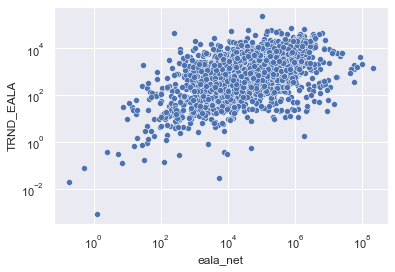

In [89]:
sns.scatterplot(merged_df, x='eala_net', y='TRND_EALA')
plt.xscale('log')
plt.yscale('log')

In [90]:
merged_df['Ag_compatibility_exists'].value_counts()

Ag_compatibility_exists
True     3003
False     232
Name: count, dtype: int64

In [91]:
idx = pd.IndexSlice
merged_df.loc[idx['08065',:,:], :]

capacity_mw_ac  capacity_mw_dc  \
FIPS  county state                                   
08065 NaN    NaN               NaN             NaN   

                    Solar_supply_per_land_area  generation_potential_ac  \
FIPS  county state                                                        
08065 NaN    NaN                           NaN                      NaN   

                    generation_potential_dc  ALAND_SQKM  RESL_SCORE  \
FIPS  county state                                                    
08065 NaN    NaN                        NaN         NaN   27.530001   

                    SOVI_SCORE  TRND_ALRA  TRND_EALA  ...  \
FIPS  county state                                    ...   
08065 NaN    NaN     44.810001        0.0        0.0  ...   

                    Percent Woman-owned Cropland  Percent Non-white Cropland  \
FIPS  county state                                                             
08065 NaN    NaN                             0.0                         0.0   

                    Pastureland  Has_undisclosed_pastureland  \
FIPS  county state                                             
08065 NaN    NaN         9172.0                        False   

                    tonne_co2_per_person  SolarPanelLandUse  \
FIPS  county state                                            
08065 NaN    NaN                     NaN               0.05   

                    ag_worker_heat_days  Ag_compatibility_exists  \
FIPS  county state                                                 
08065 NaN    NaN                    0.0                     True   

                    eala_sum_positive  eala_net  
FIPS  county state                               
08065 NaN    NaN                  0.0       0.0  

[1 rows x 51 columns]

In [92]:
# show nan values in each column
nan_df = merged_df.loc[merged_df.isna().any(axis=1), merged_df.isna().any(axis=0)]

for col in nan_df.columns:
    if 'Undisclosed' not in col:
        display(nan_df.loc[nan_df[col].isna(), [col]])

capacity_mw_ac
FIPS  county state                 
02013 NaN    Alaska             NaN
02016 NaN    NaN                NaN
02020 NaN    Alaska             NaN
02050 NaN    Alaska             NaN
02060 NaN    Alaska             NaN
...                             ...
78030 NaN    NaN                NaN
02232 NaN    NaN                NaN
11031 NaN    NaN                NaN
02    NaN    NaN                NaN
02261 NaN    Alaska             NaN

[161 rows x 1 columns]

capacity_mw_dc
FIPS  county state                 
02013 NaN    Alaska             NaN
02016 NaN    NaN                NaN
02020 NaN    Alaska             NaN
02050 NaN    Alaska             NaN
02060 NaN    Alaska             NaN
...                             ...
78030 NaN    NaN                NaN
02232 NaN    NaN                NaN
11031 NaN    NaN                NaN
02    NaN    NaN                NaN
02261 NaN    Alaska             NaN

[161 rows x 1 columns]

Solar_supply_per_land_area
FIPS  county state                             
02013 NaN    Alaska                         NaN
02016 NaN    NaN                            NaN
02020 NaN    Alaska                         NaN
02050 NaN    Alaska                         NaN
02060 NaN    Alaska                         NaN
...                                         ...
78030 NaN    NaN                            NaN
02232 NaN    NaN                            NaN
11031 NaN    NaN                            NaN
02    NaN    NaN                            NaN
02261 NaN    Alaska                         NaN

[161 rows x 1 columns]

generation_potential_ac
FIPS  county state                          
02013 NaN    Alaska                      NaN
02016 NaN    NaN                         NaN
02020 NaN    Alaska                      NaN
02050 NaN    Alaska                      NaN
02060 NaN    Alaska                      NaN
...                                      ...
78030 NaN    NaN                         NaN
02232 NaN    NaN                         NaN
11031 NaN    NaN                         NaN
02    NaN    NaN                         NaN
02261 NaN    Alaska                      NaN

[161 rows x 1 columns]

generation_potential_dc
FIPS  county state                          
02013 NaN    Alaska                      NaN
02016 NaN    NaN                         NaN
02020 NaN    Alaska                      NaN
02050 NaN    Alaska                      NaN
02060 NaN    Alaska                      NaN
...                                      ...
78030 NaN    NaN                         NaN
02232 NaN    NaN                         NaN
11031 NaN    NaN                         NaN
02    NaN    NaN                         NaN
02261 NaN    Alaska                      NaN

[161 rows x 1 columns]

ALAND_SQKM
FIPS  county state             
02013 NaN    Alaska         NaN
02016 NaN    NaN            NaN
02020 NaN    Alaska         NaN
02050 NaN    Alaska         NaN
02060 NaN    Alaska         NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[161 rows x 1 columns]

RESL_SCORE
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

SOVI_SCORE
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
69110 NaN    NaN            NaN
69120 NaN    NaN            NaN
78010 NaN    NaN            NaN
78020 NaN    NaN            NaN
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

TRND_ALRA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

TRND_EALA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

TRND_RISKV
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

TRND_RISKS
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

SWND_ALRA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

SWND_EALA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

SWND_RISKV
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

SWND_RISKS
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

HWAV_ALRA
FIPS  county state            
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

HWAV_EALA
FIPS  county state            
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

HWAV_RISKV
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

HWAV_RISKS
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

HAIL_ALRA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

HAIL_EALA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

HAIL_RISKV
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

HAIL_RISKS
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

DRGT_ALRA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

DRGT_EALA
FIPS  county state            
60010 NaN    NaN           NaN
60020 NaN    NaN           NaN
60050 NaN    NaN           NaN
66010 NaN    NaN           NaN
69100 NaN    NaN           NaN
69110 NaN    NaN           NaN
69120 NaN    NaN           NaN
02232 NaN    NaN           NaN
11031 NaN    NaN           NaN
02    NaN    NaN           NaN
02261 NaN    Alaska        NaN

DRGT_RISKV
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

DRGT_RISKS
FIPS  county state             
60010 NaN    NaN            NaN
60020 NaN    NaN            NaN
60050 NaN    NaN            NaN
66010 NaN    NaN            NaN
69100 NaN    NaN            NaN
...                         ...
78030 NaN    NaN            NaN
02232 NaN    NaN            NaN
11031 NaN    NaN            NaN
02    NaN    NaN            NaN
02261 NaN    Alaska         NaN

[92 rows x 1 columns]

Energy Burden (% income)
FIPS  county state                           
60010 NaN    NaN                          NaN
60020 NaN    NaN                          NaN
60050 NaN    NaN                          NaN
66010 NaN    NaN                          NaN
69100 NaN    NaN                          NaN
69110 NaN    NaN                          NaN
69120 NaN    NaN                          NaN
78010 NaN    NaN                          NaN
78020 NaN    NaN                          NaN
78030 NaN    NaN                          NaN
02232 NaN    NaN                          NaN
11031 NaN    NaN                          NaN
02    NaN    NaN                          NaN
02261 NaN    Alaska                       NaN

Value_veggies
FIPS  county  state                 
01001 Autauga Alabama            NaN
01005 Barbour Alabama            NaN
01007 Bibb    Alabama            NaN
01009 Blount  Alabama            NaN
01011 Bullock Alabama            NaN
...                              ...
78010 NaN     NaN                NaN
78020 NaN     NaN                NaN
78030 NaN     NaN                NaN
02232 NaN     NaN                NaN
11031 NaN     NaN                NaN

[1786 rows x 1 columns]

Value_berries
FIPS  county  state                 
01075 Lamar   Alabama            NaN
01085 Lowndes Alabama            NaN
04001 Apache  Arizona            NaN
04009 Graham  Arizona            NaN
04012 La Paz  Arizona            NaN
...                              ...
78020 NaN     NaN                NaN
78030 NaN     NaN                NaN
02232 NaN     NaN                NaN
11031 NaN     NaN                NaN
02261 NaN     Alaska             NaN

[829 rows x 1 columns]

AgPV_crop_totals
FIPS  county state                   
02013 NaN    Alaska               NaN
02050 NaN    Alaska               NaN
02060 NaN    Alaska               NaN
02070 NaN    Alaska               NaN
02100 NaN    Alaska               NaN
02130 NaN    Alaska               NaN
02150 NaN    Alaska               NaN
02170 NaN    Alaska               NaN
02180 NaN    Alaska               NaN
02185 NaN    Alaska               NaN
02188 NaN    Alaska               NaN
02220 NaN    Alaska               NaN
02240 NaN    Alaska               NaN
02290 NaN    Alaska               NaN
02261 NaN    Alaska               NaN

tonne_co2_per_person
FIPS  county               state                                                        
11001 District of Columbia D.C.                                                      NaN
44001 Bristol              Rhode Island and Providence Plantations                   NaN
44003 Kent                 Rhode Island and Providence Plantations                   NaN
44005 Newport              Rhode Island and Providence Plantations                   NaN
44007 Providence           Rhode Island and Providence Plantations                   NaN
...                                                                                  ...
78030 NaN                  NaN                                                       NaN
02232 NaN                  NaN                                                       NaN
11031 NaN                  NaN                                                       NaN
02    NaN                  NaN                                                       NaN
02261 NaN                  Alaska                                                    NaN

[167 rows x 1 columns]

SolarPanelLandUse
FIPS  county state                   
02063 NaN    NaN                  NaN
02066 NaN    NaN                  NaN
60010 NaN    NaN                  NaN
60020 NaN    NaN                  NaN
60050 NaN    NaN                  NaN
...                               ...
78020 NaN    NaN                  NaN
78030 NaN    NaN                  NaN
02232 NaN    NaN                  NaN
11031 NaN    NaN                  NaN
02    NaN    NaN                  NaN

[93 rows x 1 columns]

In [93]:
merged_df.loc[merged_df.isna().any(axis=1), merged_df.isna().any(axis=0)]

capacity_mw_ac  capacity_mw_dc  \
FIPS  county  state                                     
01001 Autauga Alabama    22349.202978    29947.935193   
01005 Barbour Alabama    43344.657028    58081.848135   
01007 Bibb    Alabama    28368.690972    38014.050777   
01009 Blount  Alabama    18483.385380    24767.738851   
01011 Bullock Alabama    32474.268989    43515.526148   
...                               ...             ...   
78030 NaN     NaN                 NaN             NaN   
02232 NaN     NaN                 NaN             NaN   
11031 NaN     NaN                 NaN             NaN   
02    NaN     NaN                 NaN             NaN   
02261 NaN     Alaska              NaN             NaN   

                       Solar_supply_per_land_area  generation_potential_ac  \
FIPS  county  state                                                          
01001 Autauga Alabama                34181.380730             5.262676e+07   
01005 Barbour Alabama                44683.161784             1.024210e+08   
01007 Bibb    Alabama                40077.253060             6.461219e+07   
01009 Blount  Alabama                24999.826647             4.175624e+07   
01011 Bullock Alabama                47007.577130             7.582720e+07   
...                                           ...                      ...   
78030 NaN     NaN                             NaN                      NaN   
02232 NaN     NaN                             NaN                      NaN   
11031 NaN     NaN                             NaN                      NaN   
02    NaN     NaN                             NaN                      NaN   
02261 NaN     Alaska                          NaN                      NaN   

                       generation_potential_dc   ALAND_SQKM  RESL_SCORE  \
FIPS  county  state                                                       
01001 Autauga Alabama             5.262677e+07  1539.632505   51.810001   
01005 Barbour Alabama             1.024211e+08  2292.161870    6.240000   
01007 Bibb    Alabama             6.461220e+07  1612.191075   19.730000   
01009 Blount  Alabama             4.175625e+07  1670.261241   22.820000   
01011 Bullock Alabama             7.582721e+07  1613.084622   17.980000   
...                                        ...          ...         ...   
78030 NaN     NaN                          NaN          NaN         NaN   
02232 NaN     NaN                          NaN          NaN         NaN   
11031 NaN     NaN                          NaN          NaN         NaN   
02    NaN     NaN                          NaN          NaN         NaN   
02261 NaN     Alaska                       NaN          NaN         NaN   

                       SOVI_SCORE     TRND_ALRA     TRND_EALA  ...  DRGT_ALRA  \
FIPS  county  state                                            ...              
01001 Autauga Alabama   51.299999  2.936418e-05    722.769891  ...   0.000826   
01005 Barbour Alabama   99.269997  8.870523e-06   1074.005284  ...   0.001623   
01007 Bibb    Alabama   80.779999  6.740941e-05    324.869968  ...   0.000831   
01009 Blount  Alabama   51.369999  7.749540e-05  21587.960390  ...   0.000093   
01011 Bullock Alabama   83.099998  1.945984e-05   1500.352857  ...   0.011559   
...                           ...           ...           ...  ...        ...   
78030 NaN     NaN             NaN  4.322852e-08      0.019758  ...   0.000000   
02232 NaN     NaN             NaN           NaN           NaN  ...        NaN   
11031 NaN     NaN             NaN           NaN           NaN  ...        NaN   
02    NaN     NaN             NaN           NaN           NaN  ...        NaN   
02261 NaN     Alaska          NaN           NaN           NaN  ...        NaN   

                           DRGT_EALA    DRGT_RISKV  DRGT_RISKS  \
FIPS  county  state                                              
01001 Autauga Alabama   20330.149968  2.854239e+04   50.652243   
01005 Barbour Alabama  196489.739432  

## Data Exploration
Are there strong correlations in the undrelying variables> That might skew results.

Ac and DC solar potential are nearly identical and strongly correlated, so we can just use one of them.

Other than that, I didn't see any strong correlations between the variables. There is some positive correlation (~0.5) between tornado risk and the other weather hazards.

In [94]:
# only use one set of nri metric. The plot is already incomprehensible
sns.set_theme(style='darkgrid')
plot_cols = [col for col in merged_df.columns if '_RISKV' not in col and '_RISKS' not in col]

remake_graph = input('Do you want to make this stupid, huge graph? (Y/N)')
if remake_graph == 'Y':
    sns.pairplot(merged_df[plot_cols])

    # save plot
    graph_dir = 'AgPV_graphs'
    graph_file = 'agpv_pairplot.png'
    plt.savefig(os.path.join(graph_dir, graph_file))

else:
    print('Smart')

Do you want to make this stupid, huge graph? (Y/N)
Smart


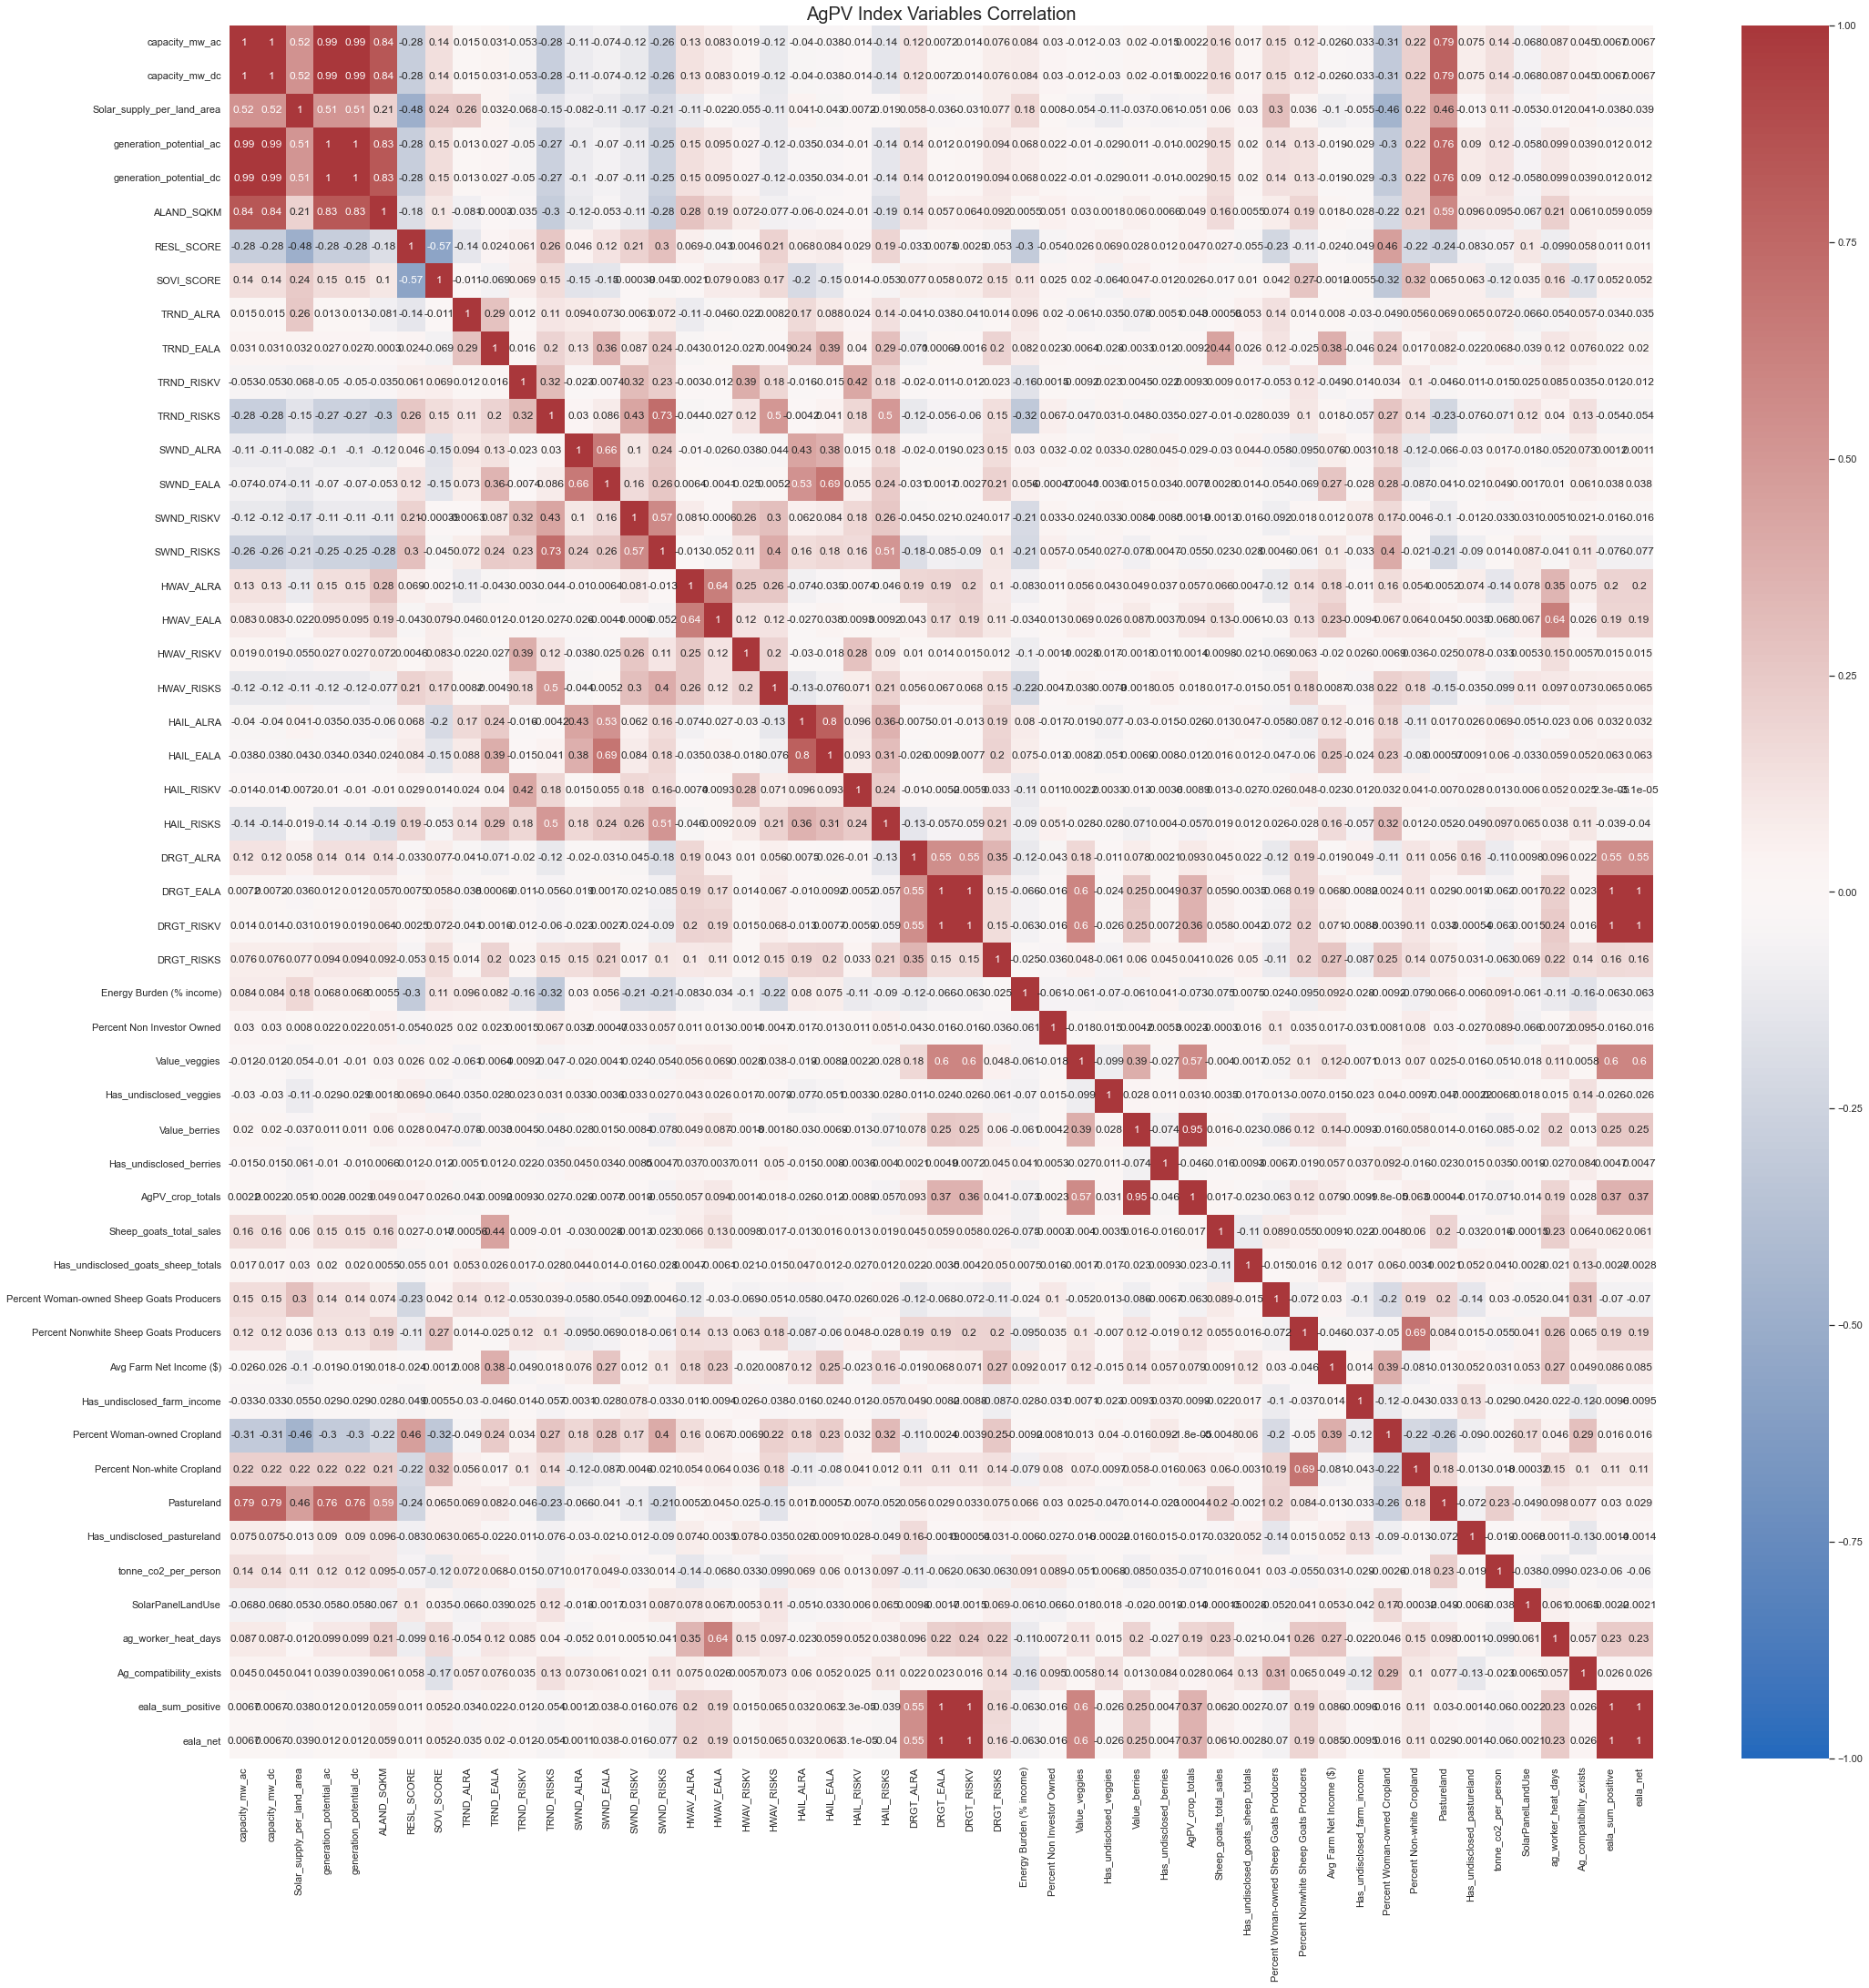

In [134]:
fig, ax = plt.subplots(figsize=(35,35))
corr_df = merged_df.corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Correlation', size=20)

# save file
corr_file = 'agpv_corr.png'
plt.savefig(os.path.join(graph_dir, corr_file))

In [96]:
merged_df.columns

Index(['capacity_mw_ac', 'capacity_mw_dc', 'Solar_supply_per_land_area',
       'generation_potential_ac', 'generation_potential_dc', 'ALAND_SQKM',
       'RESL_SCORE', 'SOVI_SCORE', 'TRND_ALRA', 'TRND_EALA', 'TRND_RISKV',
       'TRND_RISKS', 'SWND_ALRA', 'SWND_EALA', 'SWND_RISKV', 'SWND_RISKS',
       'HWAV_ALRA', 'HWAV_EALA', 'HWAV_RISKV', 'HWAV_RISKS', 'HAIL_ALRA',
       'HAIL_EALA', 'HAIL_RISKV', 'HAIL_RISKS', 'DRGT_ALRA', 'DRGT_EALA',
       'DRGT_RISKV', 'DRGT_RISKS', 'Energy Burden (% income)',
       'Percent Non Investor Owned', 'Value_veggies',
       'Has_undisclosed_veggies', 'Value_berries', 'Has_undisclosed_berries',
       'AgPV_crop_totals', 'Sheep_goats_total_sales',
       'Has_undisclosed_goats_sheep_totals',
       'Percent Woman-owned Sheep Goats Producers',
       'Percent Nonwhite Sheep Goats Producers', 'Avg Farm Net Income ($)',
       'Has_undisclosed_farm_income', 'Percent Woman-owned Cropland',
       'Percent Non-white Cropland', 'Pastureland',
       'Ha

### Pastureland Correlation
Solar supply and pastureland are highly correlated. This makes intuitive sense. Should it be included in the index if we don't want to directly include solar supply?

Text(0, 0.5, 'Solar Supply (MW hr/Year)')

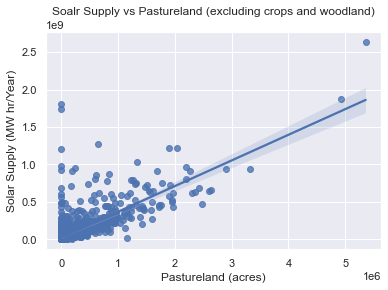

In [133]:
sns.regplot(merged_df, x='Pastureland', y='generation_potential_ac')
plt.title('Soalr Supply vs Pastureland (excluding crops and woodland)')
plt.xlabel('Pastureland (acres)')
plt.ylabel('Solar Supply (MW hr/Year)')

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Nonwhite Sheep Goats Producers'>

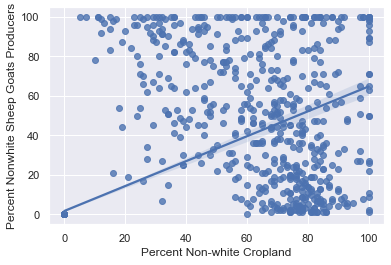

In [98]:
sns.regplot(merged_df, x='Percent Non-white Cropland', y='Percent Nonwhite Sheep Goats Producers')

### Ag Demographic Correlations

For both goats and cropland, race and gender seem to be inversely correlated after removing etreme values. Could this be due to the survey mechanism, or is it a real phenomenon?

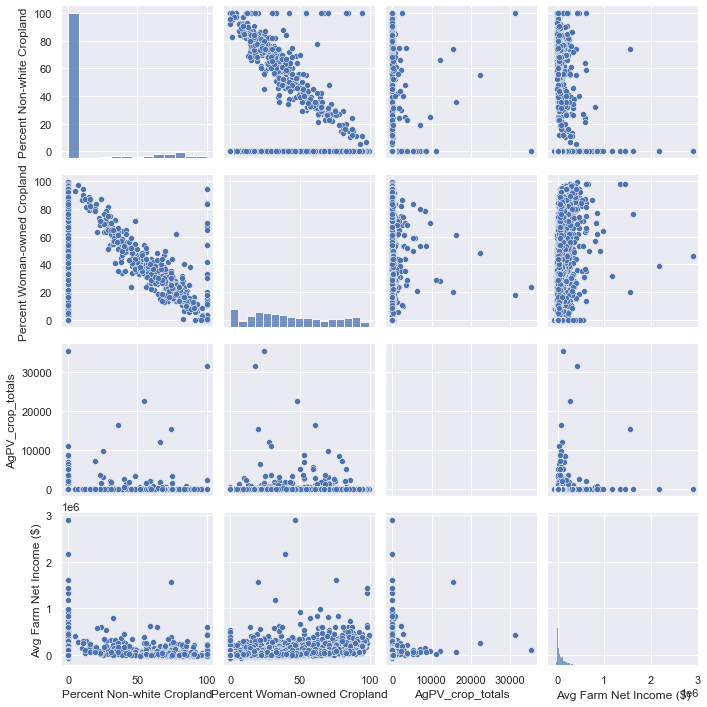

In [99]:
sns.pairplot(merged_df[['Percent Non-white Cropland', 'Percent Woman-owned Cropland', 'AgPV_crop_totals', 'Avg Farm Net Income ($)']])

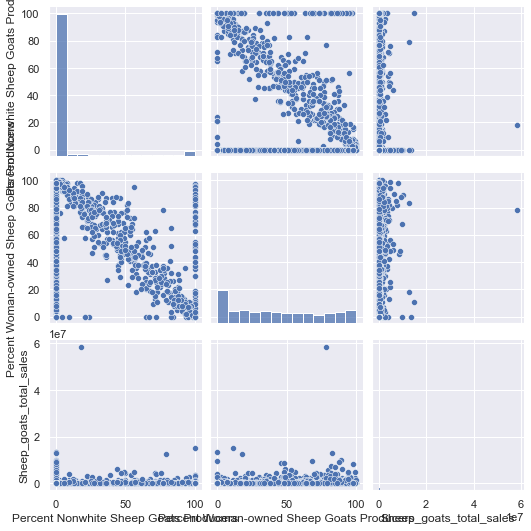

In [100]:
sns.pairplot(merged_df[['Percent Nonwhite Sheep Goats Producers', 'Percent Woman-owned Sheep Goats Producers', 'Sheep_goats_total_sales']])

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Woman-owned Cropland'>

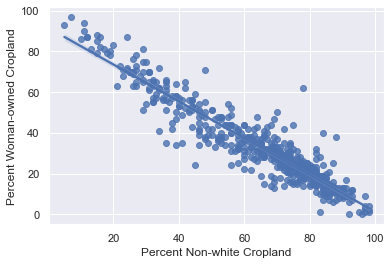

In [101]:
sns.regplot(merged_df[merged_df['Percent Non-white Cropland'].between(0,100, inclusive='neither')], x='Percent Non-white Cropland', y='Percent Woman-owned Cropland')

<Axes: xlabel='Percent Nonwhite Sheep Goats Producers', ylabel='Percent Woman-owned Sheep Goats Producers'>

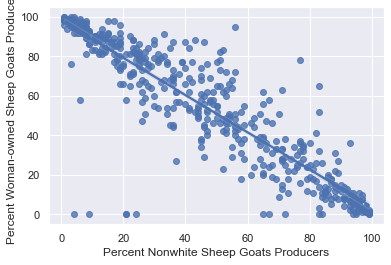

In [102]:
sns.regplot(merged_df[merged_df['Percent Nonwhite Sheep Goats Producers'].between(0,100, inclusive='neither')], x='Percent Nonwhite Sheep Goats Producers', y='Percent Woman-owned Sheep Goats Producers')

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Woman-owned Cropland'>

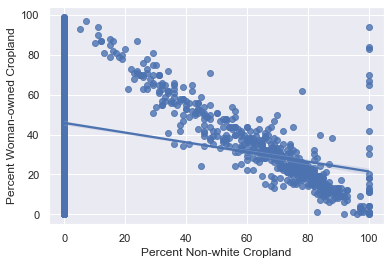

In [103]:
# is the apparent crop land woman-owned tradeoff due to undisclosed values?
sns.regplot(merged_df.loc[~merged_df[['Has_undisclosed_goats_sheep_totals', 'Has_undisclosed_veggies']].isna().any(axis=1), :], x='Percent Non-white Cropland', y='Percent Woman-owned Cropland')

### Woman-owned cropland and farm net income
There seem to be some positive correlation with farm net income and woman-ownership. What could be driving this?

We could investigate this later. The correlation seem small, but significant

Text(0.5, 0.98, 'Avg Farm Income vs Percent Woman Ownership')

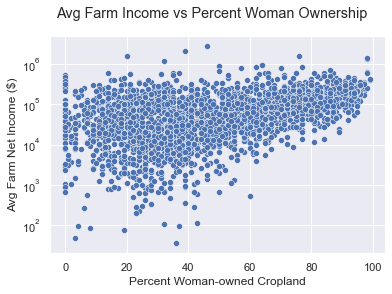

In [104]:
sns.scatterplot(merged_df, x='Percent Woman-owned Cropland', y='Avg Farm Net Income ($)', )
plt.yscale('log')
plt.suptitle('Avg Farm Income vs Percent Woman Ownership')

capacity_mw_ac  capacity_mw_dc  \
FIPS  county    state                                       
48495 Winkler   Texas        65171.939462    87330.412063   
48127 Dimmit    Texas        91791.745729   123000.958688   
48443 Terrell   Texas       156034.935317   209086.851952   
48475 Ward      Texas        54914.054428    73584.843040   
13077 Coweta    Georgia      13673.475050    18322.457555   
48311 McMullen  Texas        80815.112833   108292.266610   
22051 Jefferson Louisiana      622.354897      833.955580   
48103 Crane     Texas        51699.298199    69277.070000   
08097 Pitkin    Colorado      1817.499454     2435.449451   
48043 Brewster  Texas       267805.861152   358859.914931   

                           Solar_supply_per_land_area  \
FIPS  county    state                                   
48495 Winkler   Texas                    89034.826645   
48127 Dimmit    Texas                    70155.322720   
48443 Terrell   Texas                    72419.497321   
48475 Ward      Texas                    75059.133910   
13077 Coweta    Georgia                  27519.431826   
48311 McMullen  Texas                    70684.212277   
22051 Jefferson Louisiana                 1970.244306   
48103 Crane     Texas                    74734.889240   
08097 Pitkin    Colorado                  1780.652748   
48043 Brewster  Texas                    49963.009690   

                           generation_potential_ac  generation_potential_dc  \
FIPS  county    state                                                         
48495 Winkler   Texas                 1.939961e+08             1.939961e+08   
48127 Dimmit    Texas                 2.414605e+08             2.414605e+08   
48443 Terrell   Texas                 4.422722e+08             4.422723e+08   
48475 Ward      Texas                 1.624432e+08             1.624433e+08   
13077 Coweta    Georgia               3.143201e+07             3.143202e+07   
48311 McMullen  Texas                 2.086646e+08             2.086646e+08   
22051 Jefferson Louisiana             1.535283e+06             1.535283e+06   
48103 Crane     Texas                 1.519600e+08             1.519600e+08   
08097 Pitkin    Colorado              4.476750e+06             4.476750e+06   
48043 Brewster  Texas                 8.002018e+08             8.002019e+08   

                             ALAND_SQKM  RESL_SCORE  SOVI_SCORE  TRND_ALRA  \
FIPS  county    state                                                        
48495 Winkler   Texas       2178.878297   18.620001   56.680000   0.000144   
48127 Dimmit    Texas       3441.798861    4.550000  100.000000   0.000012   
48443 Terrell   Texas       6107.087640    5.220000   16.200001   0.000000   
48475 Ward      Texas       2164.203414    9.130000   73.139999   0.000032   
13077 Coweta    Georgia     1142.175230   59.990002   29.629999   0.000036   
48311 McMullen  Texas       2952.068012   18.459999   72.019997   0.000026   
22051 Jefferson Louisiana    779.234751   96.050003   79.849998   0.000012   
48103 Crane     Texas       2033.320859    2.930000   63.880001   0.000685   
08097 Pitkin    Colorado    2514.105883   62.790001   14.580000   0.000004   
48043 Brewster  Texas      16015.884332   22.440001   78.489998   0.000006   

                            TRND_EALA  ...  Percent Non-white Cropland  \
FIPS  county    state                  ...                               
48495 Winkler   Texas      176.890983  ...                         0.0   
48127 Dimmit    Texas      390.860901  ...                         0.0   
48443 Terrell   Texas        0.000000  ...                         0.0   
48475 Ward      Texas       58.102469  ...                         0.0   
13077 Coweta    Georgia    483.622874  ...                         0.0   
48311 McMullen  Texas      249.971034  ...                         0.0   
22051 Jefferson Louisiana    9.678317  ...                         0.0   
48103 Crane     Texas        0.119170  ...               

<Axes: xlabel='Percent Woman-owned Cropland', ylabel='Log Farm Income'>

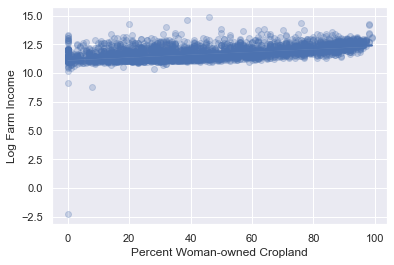

In [105]:
# try with a log transformation. Need to account for negative and zero values
log_df = merged_df.copy()
log_df['Log Farm Income'] = np.log(log_df['Avg Farm Net Income ($)'] + abs(log_df['Avg Farm Net Income ($)'].min()) + 0.1)

display(log_df.sort_values('Avg Farm Net Income ($)').iloc[:10, :])
sns.regplot(log_df, x='Percent Woman-owned Cropland', y='Log Farm Income', scatter_kws={'alpha': 0.25})

## Index Preprocessing

NRI score values seem appropriate over using the value or expected loss metric since SVI and community resiliency also use score.

For roads to removal, I used a Box-Cox transform to try and fit to a normal distribution. This time, I'm trying quantile normalization, which really forces the data to a normal distribution. The results look much more gaussian. In a sense, it's mangling the data, but since we're already doing so much to it anyway with the scaling, it's probably OK. In most cases, we get very pretty bell curves.

Process:

* Transform underlying variables to fit normal dist'n
* Minmax scale data [0-1]
* Invert 'negative' variables (tornadoes and farmer income)
* Average values of underlying variables
* Minmax scal results [0-1]

In [106]:
merged_df[plot_cols]

capacity_mw_ac  capacity_mw_dc  \
FIPS  county  state                                     
01001 Autauga Alabama    22349.202978    29947.935193   
01003 Baldwin Alabama    46948.973155    62911.632997   
01005 Barbour Alabama    43344.657028    58081.848135   
01007 Bibb    Alabama    28368.690972    38014.050777   
01009 Blount  Alabama    18483.385380    24767.738851   
...                               ...             ...   
78030 NaN     NaN                 NaN             NaN   
02232 NaN     NaN                 NaN             NaN   
11031 NaN     NaN                 NaN             NaN   
02    NaN     NaN                 NaN             NaN   
02261 NaN     Alaska              NaN             NaN   

                       Solar_supply_per_land_area  generation_potential_ac  \
FIPS  county  state                                                          
01001 Autauga Alabama                34181.380730             5.262676e+07   
01003 Baldwin Alabama                27201.414072             1.120095e+08   
01005 Barbour Alabama                44683.161784             1.024210e+08   
01007 Bibb    Alabama                40077.253060             6.461219e+07   
01009 Blount  Alabama                24999.826647             4.175624e+07   
...                                           ...                      ...   
78030 NaN     NaN                             NaN                      NaN   
02232 NaN     NaN                             NaN                      NaN   
11031 NaN     NaN                             NaN                      NaN   
02    NaN     NaN                             NaN                      NaN   
02261 NaN     Alaska                          NaN                      NaN   

                       generation_potential_dc   ALAND_SQKM  RESL_SCORE  \
FIPS  county  state                                                       
01001 Autauga Alabama             5.262677e+07  1539.632505   51.810001   
01003 Baldwin Alabama             1.120096e+08  4117.783661   86.120003   
01005 Barbour Alabama             1.024211e+08  2292.161870    6.240000   
01007 Bibb    Alabama             6.461220e+07  1612.191075   19.730000   
01009 Blount  Alabama             4.175625e+07  1670.261241   22.820000   
...                                        ...          ...         ...   
78030 NaN     NaN                          NaN          NaN         NaN   
02232 NaN     NaN                          NaN          NaN         NaN   
11031 NaN     NaN                          NaN          NaN         NaN   
02    NaN     NaN                          NaN          NaN         NaN   
02261 NaN     Alaska                       NaN          NaN         NaN   

                       SOVI_SCORE     TRND_ALRA     TRND_EALA  ...  \
FIPS  county  state                                            ...   
01001 Autauga Alabama   51.299999  2.936418e-05    722.769891  ...   
01003 Baldwin Alabama   31.030001  4.496712e-06    620.946493  ...   
01005 Barbour Alabama   99.269997  8.870523e-06   1074.005284  ...   
01007 Bibb    Alabama   80.779999  6.740941e-05    324.869968  ...   
01009 Blount  Alabama   51.369999  7.749540e-05  21587.960390  ...   
...                           ...           ...           ...  ...   
78030 NaN     NaN             NaN  4.322852e-08      0.019758  ...   
02232 NaN     NaN             NaN           NaN           NaN  ...   
11031 NaN     NaN             NaN           NaN           NaN  ...   
02    NaN     NaN             NaN           NaN           NaN  ...   
02261 NaN     Alaska          NaN           NaN           NaN  ...   

                       Percent Woman-owned Cropland  \
FIPS  county  state                                   
01001 Autauga Alabama                          32.0   
01003 Baldwin Alabama                          33.0   
01005 Barbour Alabama                          28.0   
01007 Bibb    Alabama                          21.0   
01009 Blount  Alabama                          24

In [107]:
# use quantile normalization to make everything have a normal distribution
from sklearn.preprocessing import quantile_transform, MinMaxScaler

plot_cols = [col for col in merged_df.columns if '_RISKV' not in col and '_RISKS' not in col]
X = quantile_transform(merged_df[plot_cols], output_distribution='normal')

# scale all values 0-1
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# create df from transformed data
normalized_df = pd.DataFrame(X, columns=merged_df[plot_cols].columns, index=merged_df.index)
if 'capacity_mw_dc' in normalized_df.columns:
    normalized_df = normalized_df.drop(columns=['capacity_mw_dc'])

# need to invert the neagtives in the index: tornado risk and farm income
normalized_df['Avg Farm Net Income ($)'] = 1 - normalized_df['Avg Farm Net Income ($)']
normalized_df['TRND_ALRA'] = 1 - normalized_df['TRND_ALRA']
normalized_df['TRND_EALA'] = 1 - normalized_df['TRND_EALA']
normalized_df['SolarPanelLandUse'] = 1 - normalized_df['SolarPanelLandUse']
normalized_df.head()

capacity_mw_ac  Solar_supply_per_land_area  \
FIPS  county  state                                                 
01001 Autauga Alabama        0.547392                    0.576557   
01003 Baldwin Alabama        0.612527                    0.542914   
01005 Barbour Alabama        0.606179                    0.624898   
01007 Bibb    Alabama        0.570387                    0.605767   
01009 Blount  Alabama        0.530108                    0.532051   

                       generation_potential_ac  generation_potential_dc  \
FIPS  county  state                                                       
01001 Autauga Alabama                 0.549156                 0.549156   
01003 Baldwin Alabama                 0.610111                 0.610111   
01005 Barbour Alabama                 0.604345                 0.604345   
01007 Bibb    Alabama                 0.567351                 0.567351   
01009 Blount  Alabama                 0.528722                 0.528722   

                       ALAND_SQKM  RESL_SCORE  SOVI_SCORE  TRND_ALRA  \
FIPS  county  state                                                    
01001 Autauga Alabama    0.494320    0.504360    0.500147   0.454402   
01003 Baldwin Alabama    0.615876    0.604410    0.450342   0.593834   
01005 Barbour Alabama    0.555316    0.352376    0.735668   0.561889   
01007 Bibb    Alabama    0.501526    0.418138    0.578821   0.347696   
01009 Blount  Alabama    0.507528    0.428377    0.500305   0.333056   

                       TRND_EALA  SWND_ALRA  ...  \
FIPS  county  state                          ...   
01001 Autauga Alabama   0.526097   0.518148  ...   
01003 Baldwin Alabama   0.533618   0.390759  ...   
01005 Barbour Alabama   0.508619   0.535125  ...   
01007 Bibb    Alabama   0.557772   0.538624  ...   
01009 Blount  Alabama   0.299243   0.468274  ...   

                       Percent Woman-owned Cropland  \
FIPS  county  state                                   
01001 Autauga Alabama                      0.479455   
01003 Baldwin Alabama                      0.482776   
01005 Barbour Alabama                      0.464719   
01007 Bibb    Alabama                      0.436118   
01009 Blount  Alabama                      0.450206   

                       Percent Non-white Cropland  Pastureland  \
FIPS  county  state                                              
01001 Autauga Alabama                    0.626551     0.510778   
01003 Baldwin Alabama                    0.000000     0.492388   
01005 Barbour Alabama                    0.640805     0.539300   
01007 Bibb    Alabama                    0.000000     0.470717   
01009 Blount  Alabama                    0.000000     0.549996   

                       Has_undisclosed_pastureland  tonne_co2_per_person  \
FIPS  county  state                                                        
01001 Autauga Alabama                          0.0              0.531946   
01003 Baldwin Alabama                          0.0              0.531946   
01005 Barbour Alabama                          0.0              0.531946   
01007 Bibb    Alabama                          0.0              0.531946   
01009 Blount  Alabama                          0.0              0.531946   

                       SolarPanelLandUse  ag_worker_heat_days  \
FIPS  county  state                                             
01001 Autauga Alabama                1.0             0.508586   
01003 Baldwin Alabama                1.0             0.670951   
01005 Barbour Alabama                1.0             0.533138   
01007 Bibb    Alabama                1.0             0.000000   
01009 Blount  Alabama                1.0             0.495534   

                       Ag_compatibility_exists  eala_sum_positive  eala_net  
FIPS  county  state                                                          
01001 Autauga Alabama                      1.0           0.470260  0.473340  
01003 Baldwin Alabama                      1.0           0.595107  0.59

In [108]:
normalized_df.columns

Index(['capacity_mw_ac', 'Solar_supply_per_land_area',
       'generation_potential_ac', 'generation_potential_dc', 'ALAND_SQKM',
       'RESL_SCORE', 'SOVI_SCORE', 'TRND_ALRA', 'TRND_EALA', 'SWND_ALRA',
       'SWND_EALA', 'HWAV_ALRA', 'HWAV_EALA', 'HAIL_ALRA', 'HAIL_EALA',
       'DRGT_ALRA', 'DRGT_EALA', 'Energy Burden (% income)',
       'Percent Non Investor Owned', 'Value_veggies',
       'Has_undisclosed_veggies', 'Value_berries', 'Has_undisclosed_berries',
       'AgPV_crop_totals', 'Sheep_goats_total_sales',
       'Has_undisclosed_goats_sheep_totals',
       'Percent Woman-owned Sheep Goats Producers',
       'Percent Nonwhite Sheep Goats Producers', 'Avg Farm Net Income ($)',
       'Has_undisclosed_farm_income', 'Percent Woman-owned Cropland',
       'Percent Non-white Cropland', 'Pastureland',
       'Has_undisclosed_pastureland', 'tonne_co2_per_person',
       'SolarPanelLandUse', 'ag_worker_heat_days', 'Ag_compatibility_exists',
       'eala_sum_positive', 'eala_net'],
 

The transformations seemed to slightly exagerate correlation between toranado and hail risk. Tornado and energy burden also have some correlation (0.3). This could cause some bias in the overall index.

Text(0.5, 1.0, 'AgPV Index Variables Quantile Transform Correlation')

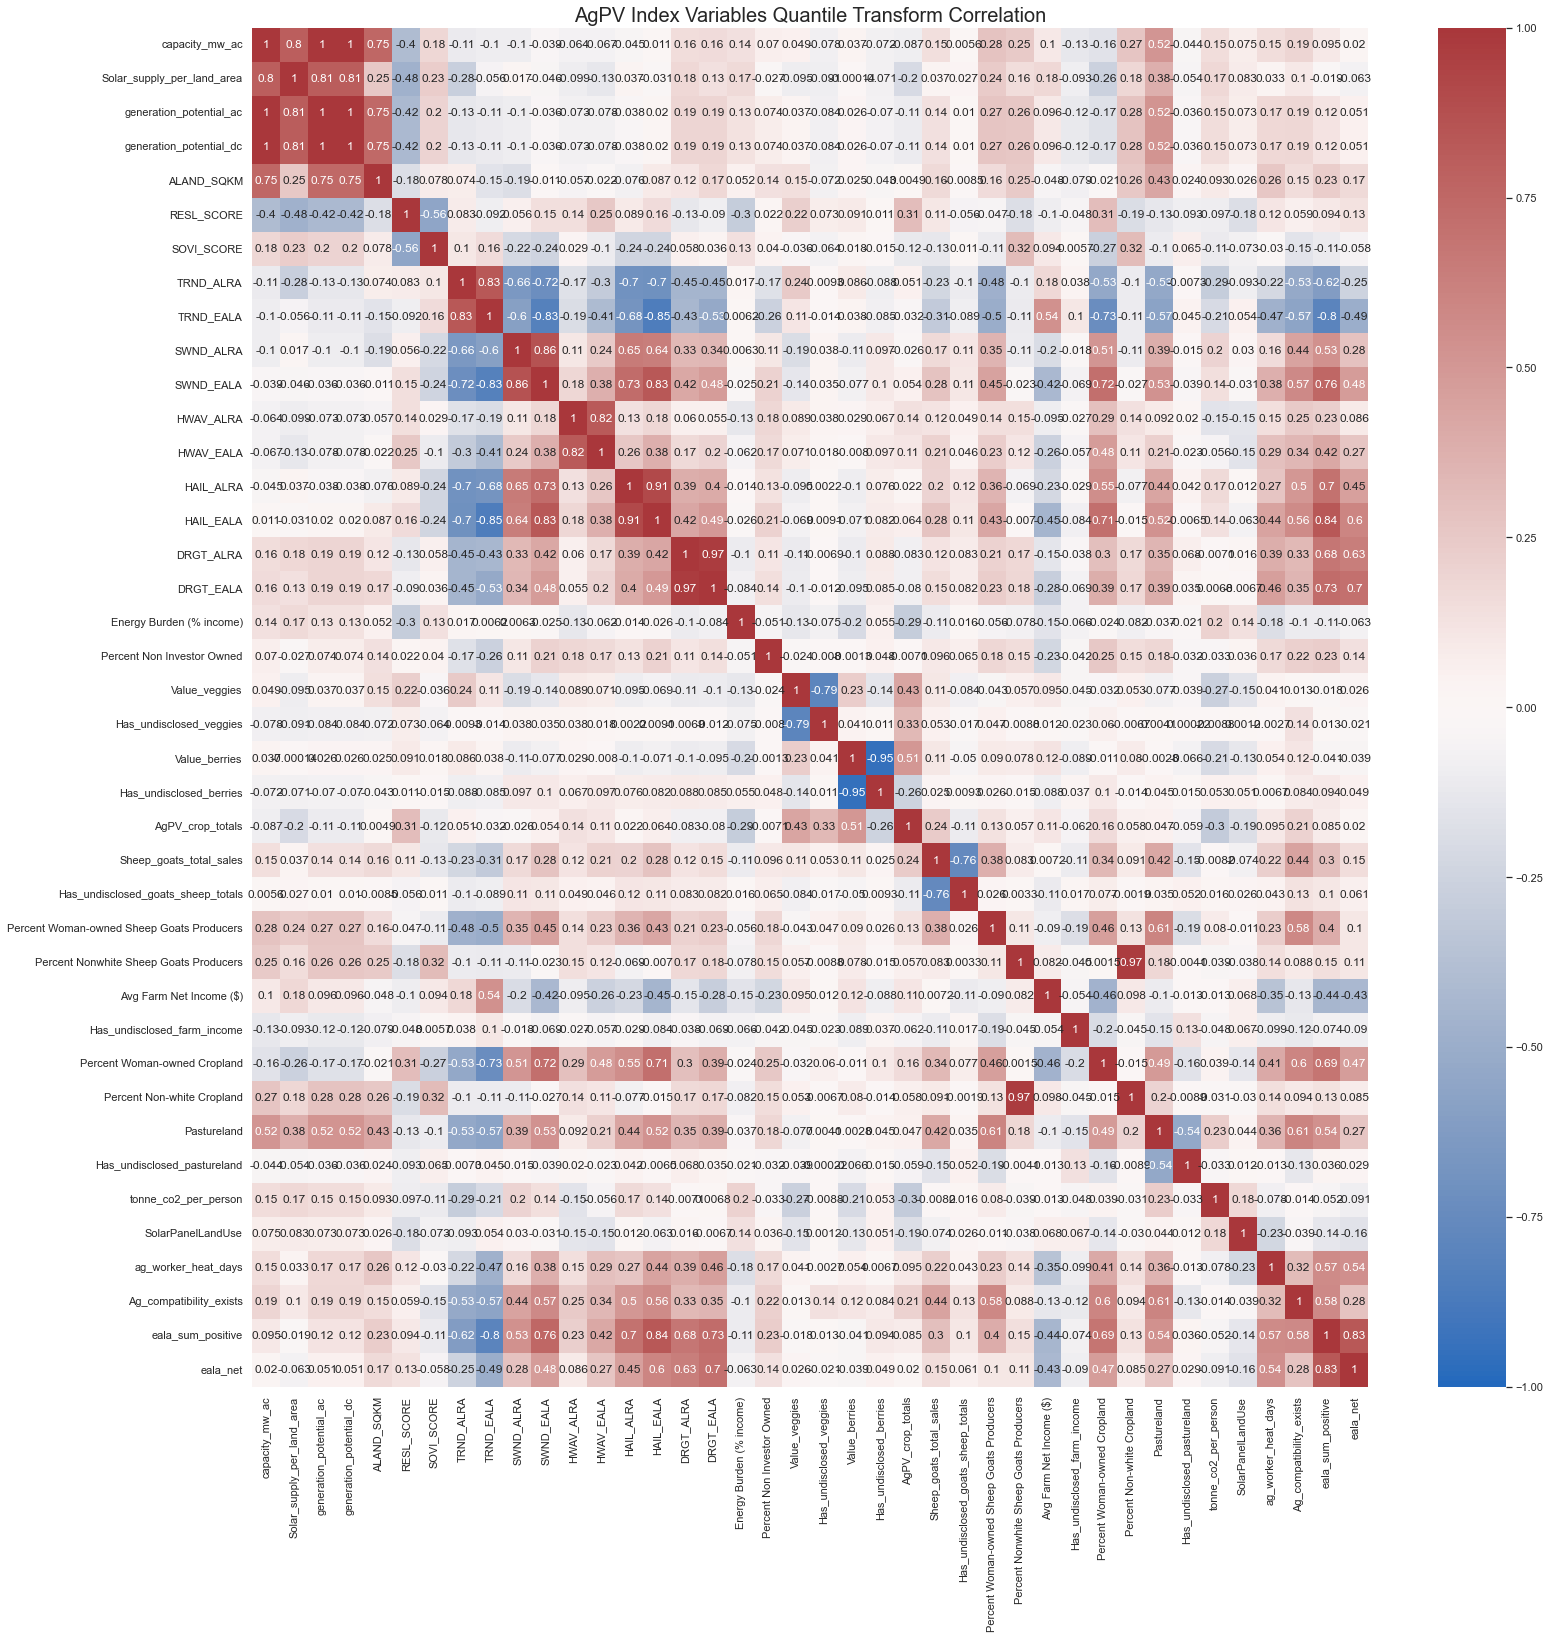

In [131]:
# correlation map with simplified variables and transformed
fig, ax = plt.subplots(figsize=(25,25))
corr_df = normalized_df.iloc[:, 0:].corr()
sns.heatmap(corr_df, annot=True, cmap='vlag', vmin=-1, vmax=1)
plt.title('AgPV Index Variables Quantile Transform Correlation', size=20)

<Axes: xlabel='Pastureland', ylabel='generation_potential_ac'>

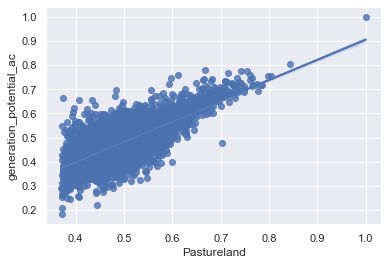

In [130]:
# are pastureland and solar supply still correlated? Yes, when you filter for 0 values
sns.regplot(normalized_df[normalized_df['Pastureland']>0], x='Pastureland', y='generation_potential_ac')

### Demographics correlations
Minority-owned crops and goats have very high correlation. Women-owned crops and goats ahve moderate correlation. I think it's best to average each respectively to avoid potential "double counting."

<Axes: xlabel='Percent Non-white Cropland', ylabel='Percent Nonwhite Sheep Goats Producers'>

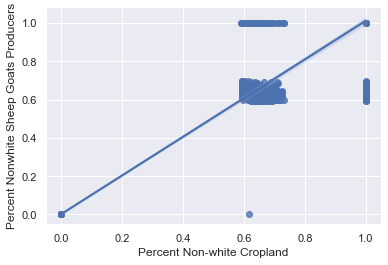

In [111]:
sns.regplot(normalized_df, x='Percent Non-white Cropland', y='Percent Nonwhite Sheep Goats Producers')

<Axes: xlabel='Percent Woman-owned Cropland', ylabel='Percent Woman-owned Sheep Goats Producers'>

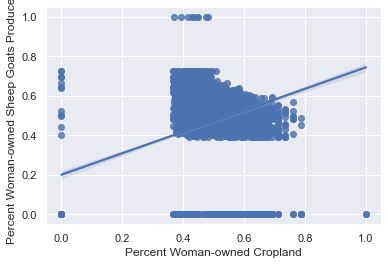

In [112]:
sns.regplot(normalized_df, x='Percent Woman-owned Cropland', y='Percent Woman-owned Sheep Goats Producers')

<Axes: xlabel='HAIL_ALRA', ylabel='TRND_ALRA'>

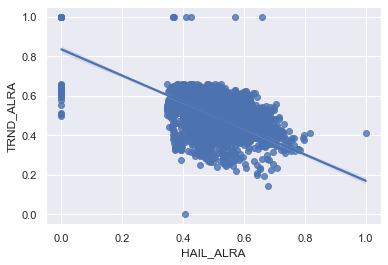

In [113]:
sns.regplot(normalized_df, x='HAIL_ALRA', y='TRND_ALRA')

In [114]:
# Get same columns from normalized df
plot_cols_df = merged_df[normalized_df.columns]
# scale un tranformed daata
scaled_original_data = scaler.fit_transform(plot_cols_df)
scaled_original_df = pd.DataFrame(scaled_original_data, index=plot_cols_df.index, columns=plot_cols_df.columns)
# add column to signify if this data has been quantile transformed
scaled_original_df['Quantile Transform'] = 'No'
# join dfs
xform_comp_df = pd.concat([scaled_original_df, normalized_df])
xform_comp_df['Quantile Transform'] = xform_comp_df['Quantile Transform'].fillna('Yes')
xform_comp_df = xform_comp_df.reset_index(drop=True)
xform_comp_df

capacity_mw_ac  Solar_supply_per_land_area  generation_potential_ac  \
0           0.024866                    0.375600                 0.019947   
1           0.052241                    0.298894                 0.042458   
2           0.048230                    0.491009                 0.038823   
3           0.031565                    0.440393                 0.024490   
4           0.020564                    0.274699                 0.015826   
...              ...                         ...                      ...   
6465             NaN                         NaN                      NaN   
6466             NaN                         NaN                      NaN   
6467             NaN                         NaN                      NaN   
6468             NaN                         NaN                      NaN   
6469             NaN                         NaN                      NaN   

      generation_potential_dc  ALAND_SQKM  RESL_SCORE  SOVI_SCORE  TRND_ALRA  \
0                    0.019947    0.029260      0.5181      0.5130   0.025848   
1                    0.042458    0.078881      0.8612      0.3103   0.003958   
2                    0.038823    0.043744      0.0624      0.9927   0.007808   
3                    0.024490    0.030657      0.1973      0.8078   0.059338   
4                    0.015826    0.031774      0.2282      0.5137   0.068216   
...                       ...         ...         ...         ...        ...   
6465                      NaN         NaN         NaN         NaN   1.000000   
6466                      NaN         NaN         NaN         NaN        NaN   
6467                      NaN         NaN         NaN         NaN        NaN   
6468                      NaN         NaN         NaN         NaN        NaN   
6469                      NaN         NaN         NaN         NaN        NaN   

      TRND_EALA  SWND_ALRA  ...  Percent Non-white Cropland  Pastureland  \
0      0.003125   0.013088  ...                    0.680000     0.003583   
1      0.002685   0.000126  ...                    0.000000     0.002451   
2      0.004644   0.020527  ...                    0.740000     0.006823   
3      0.001405   0.023071  ...                    0.000000     0.001572   
4      0.093344   0.001784  ...                    0.000000     0.008899   
...         ...        ...  ...                         ...          ...   
6465   0.663442   0.387017  ...                    0.000000     0.000000   
6466        NaN        NaN  ...                    0.000000     0.000000   
6467        NaN        NaN  ...                    0.000000     0.000000   
6468        NaN        NaN  ...                    0.615874     0.000000   
6469        NaN        NaN  ...                    0.000000     0.000000   

      Has_undisclosed_pastureland  tonne_co2_per_person  SolarPanelLandUse  \
0                             0.0              0.150879                0.0   
1                             0.0              0.150879                0.0   
2                             0.0              0.150879                0.0   
3                             0.0              0.150879                0.0   
4                             0.0              0.150879                0.0   
...                           ...                   ...                ...   
6465                          0.0                   NaN                NaN   
6466                          0.0                   NaN                NaN   
6467                          0.0                   NaN                NaN   
6468                          0.0                   NaN                NaN   
6469                          0.0                   NaN                1.0   

      ag_worker_heat_days  Ag_compatibility_exists  eala_sum_positive  \
0                0.002513                      1.0           0.000100   
1                0.040011                      1.0           0.002066   
2                0.003897                      1.0 

Text(0.5, 1.0, 'Nomalized Index Value Comparisons:\nWoman-owned Cropland vs Avg Farm Income')

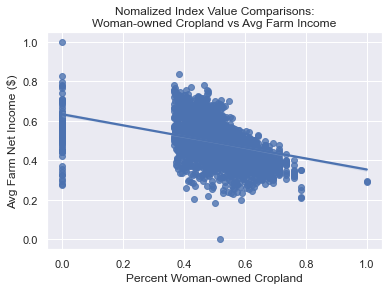

In [115]:
sns.regplot(normalized_df, x='Percent Woman-owned Cropland', y='Avg Farm Net Income ($)', )
plt.title('Nomalized Index Value Comparisons:\nWoman-owned Cropland vs Avg Farm Income')

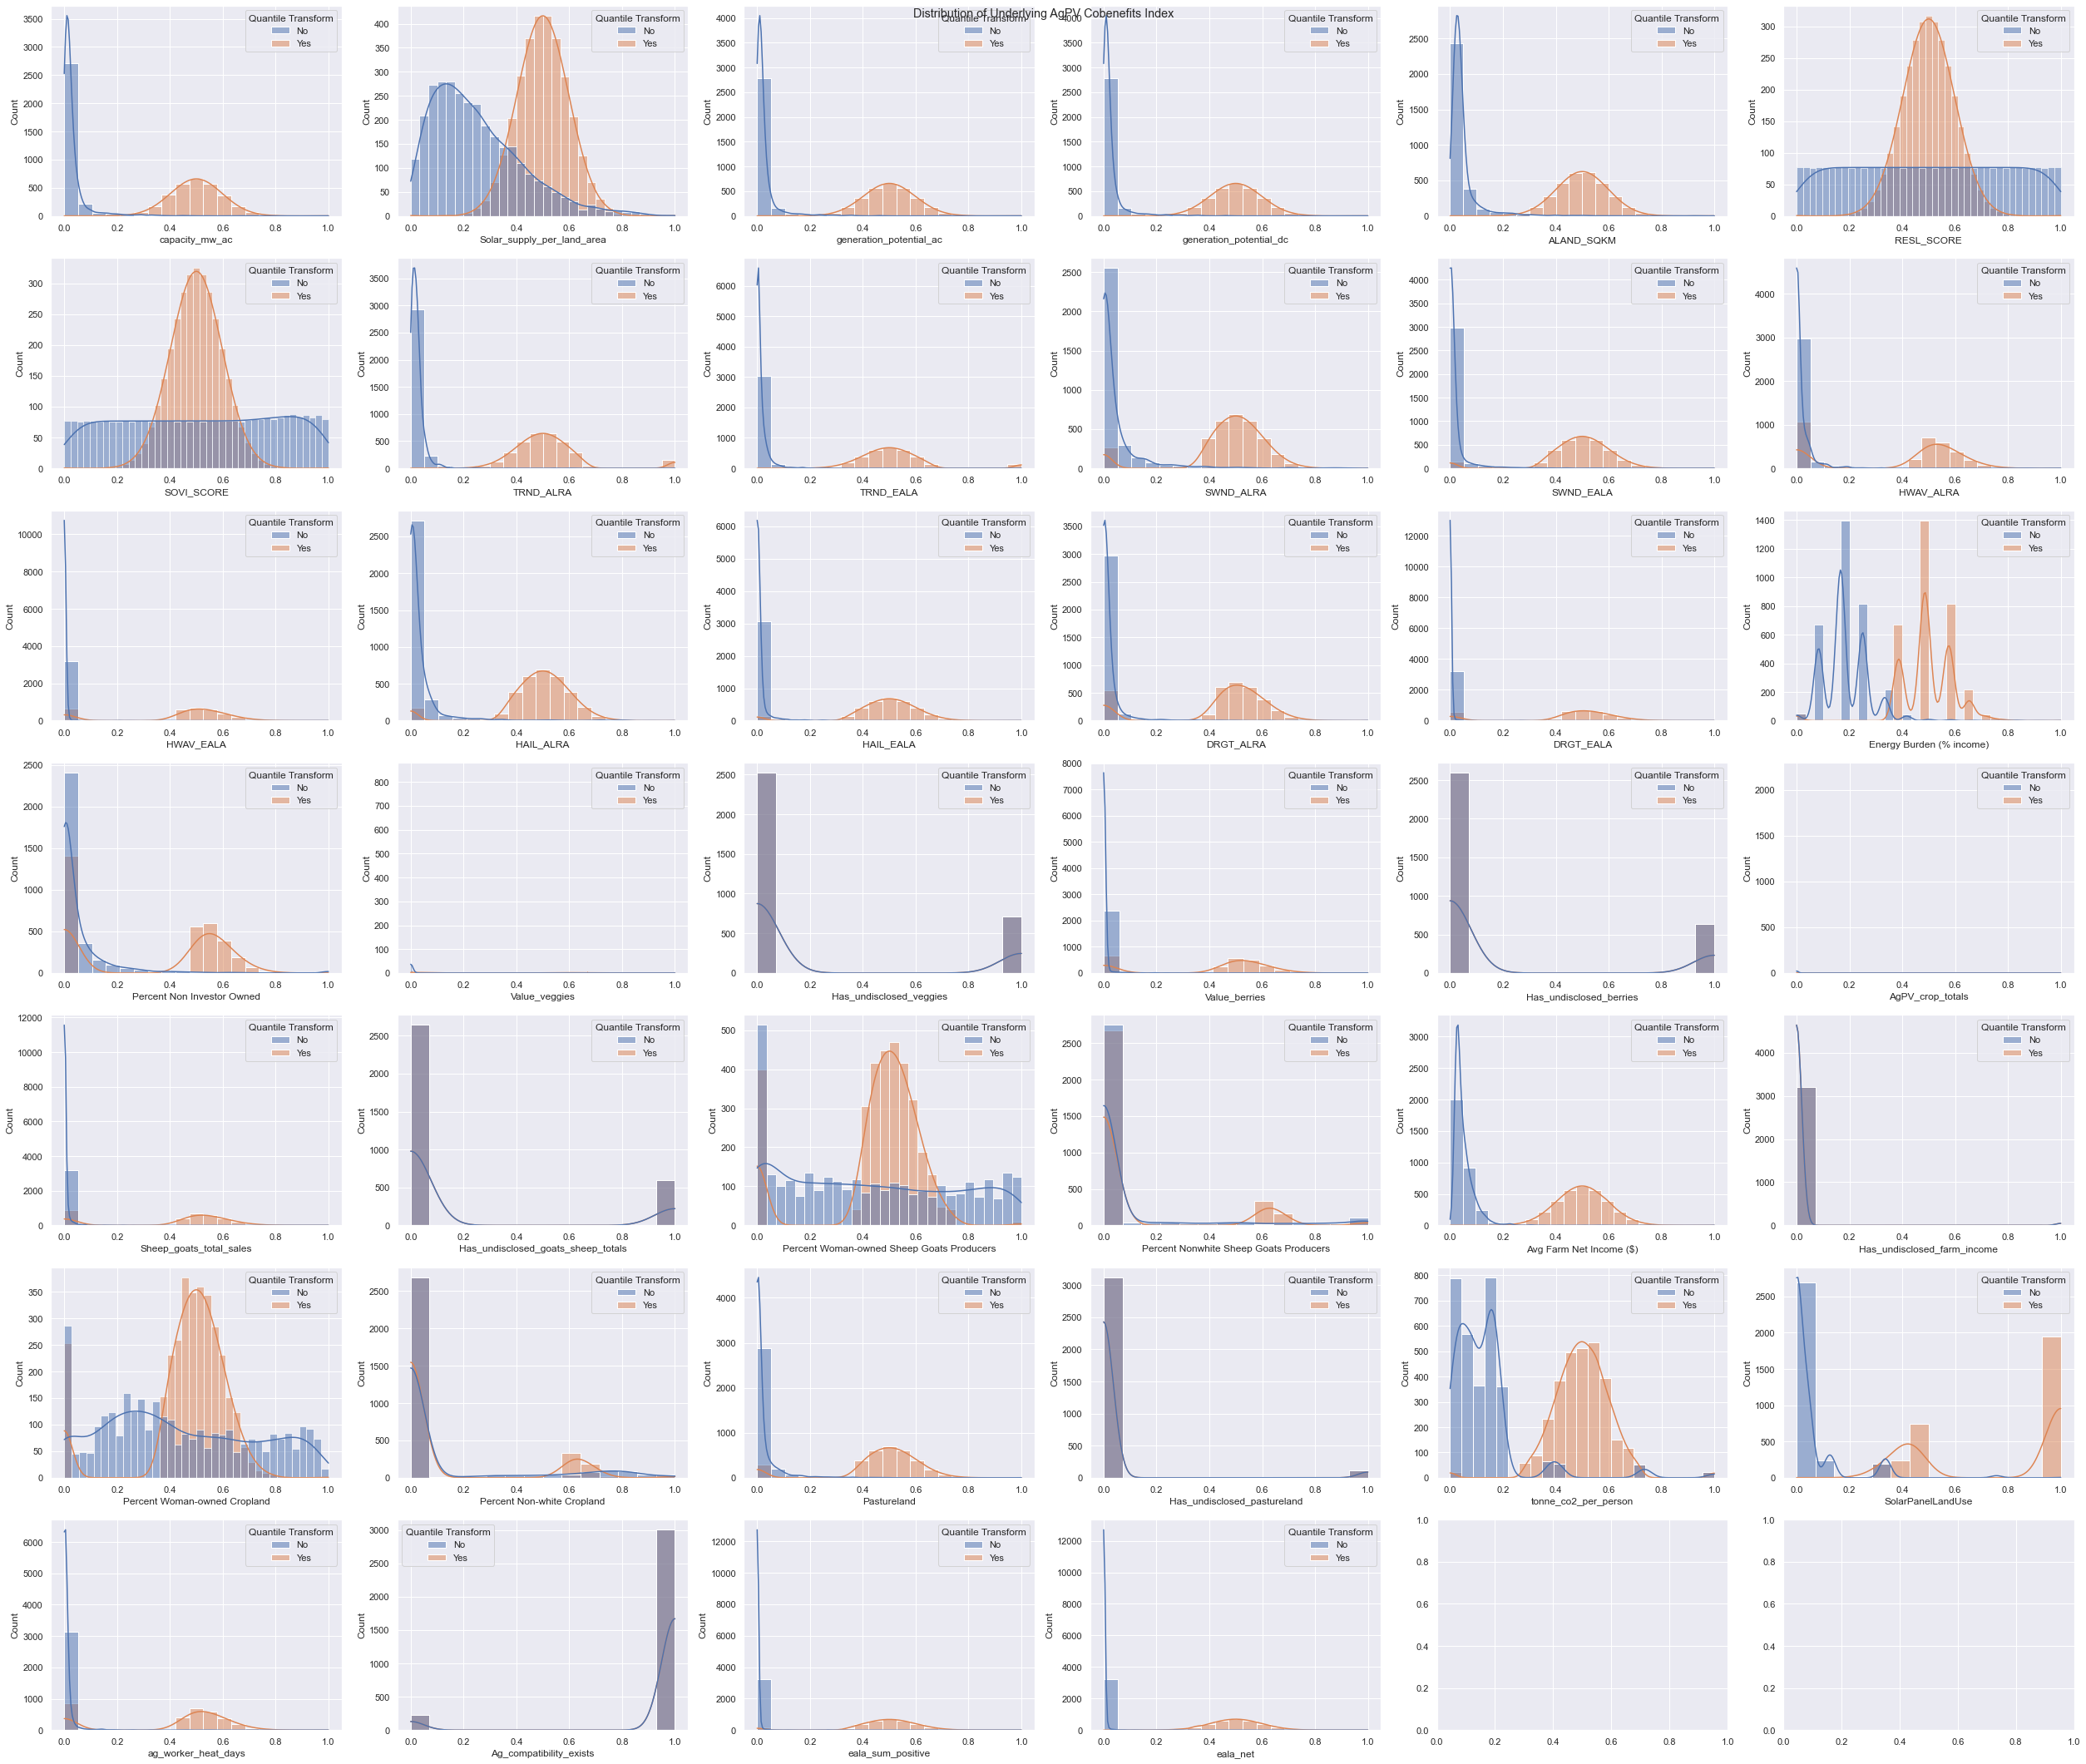

In [116]:
# look at histograms of transformed data compared to just minmax scaling. Look how beautiful these normal distributions are!
fig, axes = plt.subplots(7, 6, figsize=(35,30))

for col, ax in zip(xform_comp_df.iloc[:, :-1].columns, axes.flatten()):
    if col is not None:
        sns.histplot(xform_comp_df, x=col, kde=True, ax=ax, hue='Quantile Transform')
    
fig.suptitle('Distribution of Underlying AgPV Cobenefits Index')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_variable_distribution.png'))

Look at how wonderful those bell curves look!

Crop totals is hard to see It's likely because there are too many 0 values. Here's a filtered, zoomed in version

<Axes: xlabel='AgPV_crop_totals', ylabel='Count'>

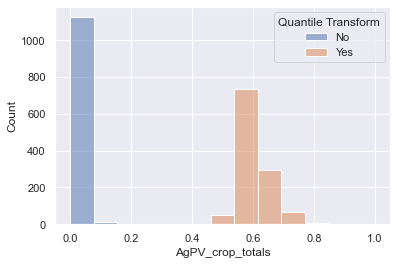

In [117]:
sns.histplot(xform_comp_df[xform_comp_df['AgPV_crop_totals']>0], x='AgPV_crop_totals', hue='Quantile Transform')

### Ag PV Index Calculation

[Apache, AZ](https://en.wikipedia.org/wiki/Apache_County,_Arizona) stands out due to its near 100% minority cropland ownership, reasonably high energy burden (80th percentile), high drought risk (95th percentile), low torndo risk (2nd percentile), and high solar supply (99th percentile).

Most of this land is owned by the Navajo nation, so the high minoirty ownership is not suprising.

Also note that most of the top counties in overall index seem to have high social vulnerability as well. This makes sense, since climate hazards make up much of the underlying variables.


In [118]:
# get average of relevant variables
index_vars = ['eala_net',
              #'TRND_ALRA', 
              #'HWAV_ALRA', 
              #'HAIL_ALRA', 
              #'DRGT_ALRA',
              #'alra_sum_positive',
              'Energy Burden (% income)',
              'Avg Farm Net Income ($)',
              'Percent Non-white Cropland',
              'Percent Non Investor Owned', 
              'Percent Woman-owned Cropland',
              'AgPV_crop_totals',
              'Sheep_goats_total_sales',
              'Percent Nonwhite Sheep Goats Producers',
              'Percent Woman-owned Sheep Goats Producers',
              'tonne_co2_per_person',
              'SolarPanelLandUse',
              'ag_worker_heat_days']

# calculate eually weighted score
agpv_benefits_score = normalized_df.loc[normalized_df.Ag_compatibility_exists > 0, index_vars].mean(axis=1)

theme_dict = {'environemntal_hazards': [col for col in index_vars if 'EALA' in col.upper()],
              'minority_ownership': ['Percent Non-white Cropland', 'Percent Nonwhite Sheep Goats Producers'],
              'women_ownership': ['Percent Woman-owned Cropland', 'Percent Woman-owned Sheep Goats Producers']
             }
              
themes_df = normalized_df.loc[normalized_df.Ag_compatibility_exists > 0, index_vars].copy()

for key, cols in theme_dict.items():
    themes_df[key] = themes_df[cols].mean(axis=1)
    themes_df = themes_df.drop(columns=cols)
    
themes_score = themes_df.mean(axis=1)

# min max scale final numbers
themes_score = (themes_score - themes_score.min()) / (themes_score.max() - themes_score.min())
agpv_benefits_score = (agpv_benefits_score - agpv_benefits_score.min()) / (agpv_benefits_score.max() - agpv_benefits_score.min())

In [119]:
themes_df['environemntal_hazards'].sort_values(ascending=False)

FIPS   county         state      
06083  Santa Barbara  California     1.000000
06113  Yolo           California     0.804125
06055  Napa           California     0.800276
06101  Sutter         California     0.797663
06011  Colusa         California     0.782457
                                       ...   
28123  Scott          Mississippi    0.212962
28129  Smith          Mississippi    0.200642
28099  Neshoba        Mississippi    0.179221
28127  Simpson        Mississippi    0.148207
28079  Leake          Mississippi    0.000000
Name: environemntal_hazards, Length: 3003, dtype: float64

In [120]:
# merge calculated score with underlying data
score_df = pd.concat([merged_df, agpv_benefits_score, themes_score], axis=1)
score_df = score_df.rename(columns={0:'EW_AgPV_cobenefits_score', 1:'Theme_Weighting_Score'})

# filter relevant columns
score_df = score_df[plot_cols + ['EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']]
score_df = score_df.drop(columns=['capacity_mw_ac'])

# show top n counties
ranks = score_df.sort_values(['EW_AgPV_cobenefits_score'], ascending=False).rank(pct=True).head(50)
compare_cols = ['AgPV_crop_totals', 'Sheep_goats_total_sales', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']
display(ranks[compare_cols])

AgPV_crop_totals  Sheep_goats_total_sales  \
FIPS  county      state                                                       
40021 Cherokee    Oklahoma                0.836646                 0.707264   
35045 San Juan    New Mexico              0.683230                 0.965997   
08077 Mesa        Colorado                0.916149                 0.987017   
35053 Socorro     New Mexico              0.321118                 0.543431   
48339 Montgomery  Texas                   0.923602                 0.758887   
40037 Creek       Oklahoma                0.925311                 0.888253   
30013 Cascade     Montana                 0.766304                 0.950541   
48303 Lubbock     Texas                   0.690994                 0.843740   
55073 Marathon    Wisconsin               0.939907                 0.685471   
53077 Yakima      Washington              0.979814                 0.973725   
12083 Marion      Florida                 0.959938                 0.921175   
48051 Burleson    Texas                   0.644876                 0.699073   
06077 San Joaquin California              0.989441                 0.987635   
06061 Placer      California              0.868168                 0.961515   
41043 Linn        Oregon                  0.993168                 0.992581   
04005 Coconino    Arizona                 0.673602                 0.962287   
04017 Navajo      Arizona                 0.785404                 0.941886   
13267 Tattnall    Georgia                 0.710404                 0.389799   
08029 Delta       Colorado                0.810714                 0.960124   
40027 Cleveland   Oklahoma                0.724224                 0.730294   
35049 Santa Fe    New Mexico              0.804193                 0.922411   
05015 Carroll     Arkansas                0.662733                 0.834621   
06089 Shasta      California              0.882609                 0.845904   
40135 Sequoyah    Oklahoma                0.690994                 0.682998   
45035 Dorchester  South Carolina          0.759472                 0.442968   
41019 Douglas     Oregon                  0.981056                 0.992272   
48203 Harrison    Texas                   0.905124                 0.420711   
30081 Ravalli     Montana                 0.794565                 0.863369   
48293 Limestone   Texas                   0.766304                 0.787326   
12069 Lake        Florida                 0.980745                 0.899845   
05045 Faulkner    Arkansas                0.860714                 0.791963   
40143 Tulsa       Oklahoma                0.789286                 0.695672   
04019 Pima        Arizona                 0.840683                 0.541422   
53063 Spokane     Washington              0.935093                 0.881917   
48225 Houston     Texas                   0.766304                 0.478825   
53041 Lewis       Washington              0.986957                 0.869706   
56013 Fremont     Wyoming                 0.321118                 0.978980   
41059 Umatilla    Oregon                  0.970186                 0.958887   
20125 Montgomery  Kansas                  0.710404                 0.648223   
12119 Sumter      Florida                 0.975776                 0.648223   
08123 Weld        Colorado                0.910714                 1.000000   
53053 Pierce      Washington              0.977329                 0.914992   
20087 Jefferson   Kansas                  0.710404                 0.675425   
40087 McClain     Oklahoma                0.850932                 0.804482   
06095 Solano      California              0.924534                 0.999691   
06101 Sutter      California              0.321118                 0.909428   
08039 Elbert      Colorado                0.683230                 0.737403   
45091 York        South Carolina          0.905124                 0.592890   
35035 Otero       New Mexico              0.662733                 0.564451   
40071

In [121]:
theme_ranks = score_df.sort_values(['Theme_Weighting_Score'], ascending=False).rank(pct=True).head(50)
display(theme_ranks[compare_cols])

AgPV_crop_totals  Sheep_goats_total_sales  \
FIPS  county      state                                                       
35045 San Juan    New Mexico              0.683230                 0.965997   
40021 Cherokee    Oklahoma                0.836646                 0.707264   
48339 Montgomery  Texas                   0.923602                 0.758887   
48303 Lubbock     Texas                   0.690994                 0.843740   
40037 Creek       Oklahoma                0.925311                 0.888253   
08077 Mesa        Colorado                0.916149                 0.987017   
53077 Yakima      Washington              0.979814                 0.973725   
06061 Placer      California              0.868168                 0.961515   
12083 Marion      Florida                 0.959938                 0.921175   
48051 Burleson    Texas                   0.644876                 0.699073   
04017 Navajo      Arizona                 0.785404                 0.941886   
35049 Santa Fe    New Mexico              0.804193                 0.922411   
41043 Linn        Oregon                  0.993168                 0.992581   
08029 Delta       Colorado                0.810714                 0.960124   
40027 Cleveland   Oklahoma                0.724224                 0.730294   
06089 Shasta      California              0.882609                 0.845904   
30013 Cascade     Montana                 0.766304                 0.950541   
41019 Douglas     Oregon                  0.981056                 0.992272   
12069 Lake        Florida                 0.980745                 0.899845   
40135 Sequoyah    Oklahoma                0.690994                 0.682998   
30081 Ravalli     Montana                 0.794565                 0.863369   
48203 Harrison    Texas                   0.905124                 0.420711   
05045 Faulkner    Arkansas                0.860714                 0.791963   
40143 Tulsa       Oklahoma                0.789286                 0.695672   
53063 Spokane     Washington              0.935093                 0.881917   
55073 Marathon    Wisconsin               0.939907                 0.685471   
48293 Limestone   Texas                   0.766304                 0.787326   
06077 San Joaquin California              0.989441                 0.987635   
04005 Coconino    Arizona                 0.673602                 0.962287   
35053 Socorro     New Mexico              0.321118                 0.543431   
48225 Houston     Texas                   0.766304                 0.478825   
35035 Otero       New Mexico              0.662733                 0.564451   
41059 Umatilla    Oregon                  0.970186                 0.958887   
53041 Lewis       Washington              0.986957                 0.869706   
13267 Tattnall    Georgia                 0.710404                 0.389799   
12119 Sumter      Florida                 0.975776                 0.648223   
53053 Pierce      Washington              0.977329                 0.914992   
20125 Montgomery  Kansas                  0.710404                 0.648223   
56013 Fremont     Wyoming                 0.321118                 0.978980   
05015 Carroll     Arkansas                0.662733                 0.834621   
20087 Jefferson   Kansas                  0.710404                 0.675425   
08123 Weld        Colorado                0.910714                 1.000000   
08039 Elbert      Colorado                0.683230                 0.737403   
45091 York        South Carolina          0.905124                 0.592890   
45035 Dorchester  South Carolina          0.759472                 0.442968   
41039 Lane        Oregon                  0.979193                 0.990417   
45023 Chester     South Carolina          0.789286                 0.572643   
48467 Van Zandt   Texas                   0.958385                 0.859660   
13175 Laurens     Georgia                 0.683230                 0.513138   
08083

In [122]:
score_df_copy = score_df.copy()
score_df_copy['Score_diff'] = score_df_copy['EW_AgPV_cobenefits_score'] - score_df_copy['Theme_Weighting_Score']

quantile_EW_80 = score_df_copy['EW_AgPV_cobenefits_score'].quantile(.80)
quantile_TW_80 = score_df_copy['Theme_Weighting_Score'].quantile(.80)

new_df = pd.DataFrame()
# get percentiles 
for col in score_df_copy.columns:
    new_df[col, 'Value'] = score_df_copy[col]
    new_df[col, 'Percentile'] = score_df_copy[col].rank(pct=True)
    
new_df.columns = pd.MultiIndex.from_tuples(new_df.columns)
new_df = new_df.loc[new_df[('EW_AgPV_cobenefits_score', 'Value')] > quantile_EW_80, :]
idx = pd.IndexSlice

new_df = new_df.loc[:, idx[compare_cols + ['Score_diff'], :]]
new_df[('Score_diff', 'Pct_change')] = new_df[('Score_diff', 'Value')] / new_df[('EW_AgPV_cobenefits_score', 'Value')]
new_df['Left Top 20%'] = new_df[('Theme_Weighting_Score', 'Value')] < quantile_TW_80

method_comp_df = new_df.sort_values(('Score_diff', 'Value'), ascending=False).drop(columns=[('EW_AgPV_cobenefits_score', 'Percentile'), 
                                                                                            ('Theme_Weighting_Score', 'Percentile'),
                                                                                            ('Score_diff', 'Percentile')])

method_comp_df.to_excel(os.path.join(export_dir, 'method_comp2.xlsx'))
method_comp_df

AgPV_crop_totals             \
                                         Value Percentile   
FIPS  county      state                                     
48253 Jones       Texas                    0.0   0.321118   
51175 Southampton Virginia                 0.0   0.321118   
28087 Lowndes     Mississippi              0.0   0.321118   
22119 Webster     Louisiana                0.0   0.321118   
29097 Jasper      Missouri                 0.0   0.321118   
...                                        ...        ...   
56003 Big Horn    Wyoming                  0.0   0.321118   
12049 Hardee      Florida                486.0   0.975155   
01003 Baldwin     Alabama                117.0   0.938354   
56031 Platte      Wyoming                  3.0   0.662733   
06033 Lake        California              32.0   0.840683   

                              Sheep_goats_total_sales             \
                                                Value Percentile   
FIPS  county      state                                            
48253 Jones       Texas                        137000   0.623029   
51175 Southampton Virginia                      46000   0.427975   
28087 Lowndes     Mississippi                   12000   0.304482   
22119 Webster     Louisiana                         0   0.134621   
29097 Jasper      Missouri                          0   0.134621   
...                                               ...        ...   
56003 Big Horn    Wyoming                     2595000   0.981453   
12049 Hardee      Florida                      106000   0.577434   
01003 Baldwin     Alabama                      136000   0.621020   
56031 Platte      Wyoming                      105000   0.574961   
06033 Lake        California                  1791000   0.968470   

                              EW_AgPV_cobenefits_score Theme_Weighting_Score  \
                                                 Value                 Value   
FIPS  county      state                                                        
48253 Jones       Texas                       0.712334              0.626495   
51175 Southampton Virginia                    0.700440              0.615787   
28087 Lowndes     Mississippi                 0.693913              0.610308   
22119 Webster     Louisiana                   0.741920              0.661425   
29097 Jasper      Missouri                    0.721875              0.642629   
...                                                ...                   ...   
56003 Big Horn    Wyoming                     0.734965              0.811147   
12049 Hardee      Florida                     0.735945              0.812938   
01003 Baldwin     Alabama                     0.720412              0.798956   
56031 Platte      Wyoming                     0.761195              0.845227   
06033 Lake        California                  0.716080              0.802338   

                              Score_diff            Left Top 20%  
                                   Value Pct_change               
FIPS  county      state                                           
48253 Jones       Texas         0.085839   0.120504         True  
51175 Southampton Virginia      0.084653   0.120857         True  
28087 Lowndes     Mississippi   0.083604   0.120483         True  
22119 Webster     Louisiana     0.080495   0.108495         True  
29097 Jasper      Missouri      0.079247   0.109779         True  
...                                  ...        ...          ...  
56003 Big Horn    Wyoming      -0.076181  -0.103653        False  
12049 Hardee      Florida      -0.076994  -0.104619        False  
01003 Baldwin     Alabama      -0.078544  -0.109027        False  
56031 Platte      Wyoming      -0.084032  -0.110395        False  
06033 Lake        California   -0.086258  -0.120458        False  

[601 rows x 9 columns]

In [123]:
score_df.rank(pct=True).loc[['40021', '35045', '04001'], :].T

FIPS                                          40021      35045     04001
county                                     Cherokee   San Juan    Apache
state                                      Oklahoma New Mexico   Arizona
capacity_mw_dc                             0.734873   0.995120  0.999675
Solar_supply_per_land_area                 0.739102   0.979506  0.983084
generation_potential_ac                    0.737801   0.994470  0.999675
generation_potential_dc                    0.737801   0.994470  0.999675
ALAND_SQKM                                 0.627846   0.984710  0.998373
RESL_SCORE                                 0.189310   0.130130  0.006682
SOVI_SCORE                                 0.946911   0.930146  0.964918
TRND_ALRA                                  0.861042   0.060484  0.194479
TRND_EALA                                  0.733871   0.122208  0.183002
SWND_ALRA                                  0.111663   0.072270  0.056762
SWND_EALA                                  0.142370   0.089950  0.054591
HWAV_ALRA                                  0.603064   0.292479  0.104766
HWAV_EALA                                  0.651192   0.297431  0.103374
HAIL_ALRA                                  0.301489   0.243486  0.214330
HAIL_EALA                                  0.357940   0.320099  0.172457
DRGT_ALRA                                  0.918114   0.990385  0.977357
DRGT_EALA                                  0.903846   0.987903  0.906638
Energy Burden (% income)                   0.440702   0.440702  0.784539
Percent Non Investor Owned                 0.780216   0.903864  0.743277
Value_veggies                              0.285714   0.285714       NaN
Has_undisclosed_veggies                    0.890263   0.890263  0.390263
Value_berries                              0.767041   0.429343       NaN
Has_undisclosed_berries                    0.401546   0.401546  0.401546
AgPV_crop_totals                           0.836646   0.683230  0.321118
Sheep_goats_total_sales                    0.707264   0.965997  0.965688
Has_undisclosed_goats_sheep_totals         0.408192   0.408192  0.408192
Percent Woman-owned Sheep Goats Producers  0.850232   0.284853  0.061669
Percent Nonwhite Sheep Goats Producers     0.990263   0.990263  0.990263
Avg Farm Net Income ($)                    0.231221   0.252859  0.046832
Has_undisclosed_farm_income                0.495209   0.495209  0.495209
Percent Woman-owned Cropland               0.268934   0.081607  0.097063
Percent Non-white Cropland                 0.952087   0.965997  0.991963
Pastureland                                0.770943   0.996909  0.999691
Has_undisclosed_pastureland                0.482535   0.482535  0.482535
tonne_co2_per_person                       0.653846   0.671773  0.166558
SolarPanelLandUse                          0.309835   0.309835  0.309835
ag_worker_heat_days                        0.970015   0.945595  0.336476
Ag_compatibility_exists                    0.536012   0.536012  0.536012
eala_sum_positive                          0.873261   0.987326  0.876043
eala_net                                   0.873570   0.987326  0.878207
EW_AgPV_cobenefits_score                   1.000000   0.999667  0.950050
Theme_Weighting_Score                      0.999667   1.000000  0.958708

In [124]:
new_df['Left Top 20%'].value_counts()

Left Top 20%
False    484
True     117
Name: count, dtype: int64

In [125]:
merged_df.sort_values('AgPV_crop_totals', ascending=False).iloc[:20, :]

capacity_mw_ac  capacity_mw_dc  \
FIPS  county        state                                           
23029 Washington    Maine           118929.255579   159365.227682   
06083 Santa Barbara California       21151.875492    28343.515023   
06111 Ventura       California       12661.270999    16966.104172   
53073 Whatcom       Washington        6362.764881     8526.105182   
06053 Monterey      California       34394.396342    46088.494310   
12057 Hillsborough  Florida           8043.299220    10778.021472   
25023 Plymouth      Massachusetts    13006.280650    17428.416309   
26159 Van Buren     Michigan         10382.986330    13913.202366   
34001 Atlantic      New Jersey        8180.526855    10961.906385   
26139 Ottawa        Michigan          7680.908927    10292.418104   
41047 Marion        Oregon            9776.052705    13099.911170   
13005 Bacon         Georgia           7768.771235    10410.154176   
23009 Hancock       Maine            67421.958926    90345.437837   
53057 Skagit        Washington        6802.249473     9115.014464   
55141 Wood          Wisconsin        14564.423928    19516.328594   
34005 Burlington    New Jersey        7862.594268    10535.876419   
55071 Manitowoc     Wisconsin         5686.314439     7619.661487   
06087 Santa Cruz    California        2183.827910     2926.329522   
41067 Washington    Oregon            6286.367799     8423.732928   
55081 Monroe        Wisconsin        15908.274520    21317.088531   

                                   Solar_supply_per_land_area  \
FIPS  county        state                                       
23029 Washington    Maine                        35443.782287   
06083 Santa Barbara California                    8626.964349   
06111 Ventura       California                    7665.846092   
53073 Whatcom       Washington                    1958.118327   
06053 Monterey      California                   11391.441841   
12057 Hillsborough  Florida                       7954.615704   
25023 Plymouth      Massachusetts                16204.465565   
26159 Van Buren     Michigan                     13565.600527   
34001 Atlantic      New Jersey                   12680.349826   
26139 Ottawa        Michigan                     10851.608044   
41047 Marion        Oregon                        6199.424385   
13005 Bacon         Georgia                      26172.830717   
23009 Hancock       Maine                        32846.286979   
53057 Skagit        Washington                    2462.235835   
55141 Wood          Wisconsin                    14989.437411   
34005 Burlington    New Jersey                    8263.108161   
55071 Manitowoc     Wisconsin                     7805.693720   
06087 Santa Cruz    California                    4908.925259   
41067 Washington    Oregon                        6310.124546   
55081 Monroe        Wisconsin                    14439.142270   

                                   generation_potential_ac  \
FIPS  county        state                                    
23029 Washington    Maine                     2.352557e+08   
06083 Santa Barbara California                6.108650e+07   
06111 Ventura       California                3.654770e+07   
53073 Whatcom       Washington                1.069048e+07   
06053 Monterey      California                9.682289e+07   
12057 Hillsborough  Florida                   2.106669e+07   
25023 Plymouth      Massachusetts             2.763694e+07   
26159 Van Buren     Michigan                  2.135467e+07   
34001 Atlantic      New Jersey                1.824628e+07   
26139 Ottawa        Michigan                  1.583804e+07   
41047 Marion        Oregon                    1.896010e+07   
13005 Bacon         Georgia                   1.925737e+07   
23009 Hancock       Maine                     1.350195e+08   
53057 Skagit        Washington                1.103397e+07   
55141 Wood          Wisconsin                 3.078701e+07   
34005 Burlington    New Jersey 

In [126]:
score_df.loc[idx[:,:,'Alaska'], ['AgPV_crop_totals']]

AgPV_crop_totals
FIPS  county state                   
02013 NaN    Alaska               NaN
02020 NaN    Alaska             170.0
02050 NaN    Alaska               NaN
02060 NaN    Alaska               NaN
02070 NaN    Alaska               NaN
02090 NaN    Alaska              61.0
02100 NaN    Alaska               NaN
02110 NaN    Alaska               3.0
02122 NaN    Alaska              53.0
02130 NaN    Alaska               NaN
02150 NaN    Alaska               NaN
02170 NaN    Alaska               NaN
02180 NaN    Alaska               NaN
02185 NaN    Alaska               NaN
02188 NaN    Alaska               NaN
02220 NaN    Alaska               NaN
02240 NaN    Alaska               NaN
02290 NaN    Alaska               NaN
02261 NaN    Alaska               NaN

In [127]:
score_df.iloc[100:, :]

capacity_mw_dc  Solar_supply_per_land_area  \
FIPS  county   state                                                  
05037 Cross    Arkansas     7895.567611                 8679.868601   
05039 Dallas   Arkansas    51069.531548                49293.984813   
05041 Desha    Arkansas     2300.598057                 2145.568598   
05043 Drew     Arkansas    39805.998877                31979.392001   
05045 Faulkner Arkansas    16141.127699                16570.943076   
...                                 ...                         ...   
78030 NaN      NaN                  NaN                         NaN   
02232 NaN      NaN                  NaN                         NaN   
11031 NaN      NaN                  NaN                         NaN   
02    NaN      NaN                  NaN                         NaN   
02261 NaN      Alaska               NaN                         NaN   

                         generation_potential_ac  generation_potential_dc  \
FIPS  county   state                                                        
05037 Cross    Arkansas             1.385530e+07             1.385531e+07   
05039 Dallas   Arkansas             8.519775e+07             8.519776e+07   
05041 Desha    Arkansas             4.118999e+06             4.118999e+06   
05043 Drew     Arkansas             6.863543e+07             6.863544e+07   
05045 Faulkner Arkansas             2.777892e+07             2.777892e+07   
...                                          ...                      ...   
78030 NaN      NaN                           NaN                      NaN   
02232 NaN      NaN                           NaN                      NaN   
11031 NaN      NaN                           NaN                      NaN   
02    NaN      NaN                           NaN                      NaN   
02261 NaN      Alaska                        NaN                      NaN   

                          ALAND_SQKM  RESL_SCORE  SOVI_SCORE     TRND_ALRA  \
FIPS  county   state                                                         
05037 Cross    Arkansas  1596.257457   33.639999   84.790001  2.933840e-05   
05039 Dallas   Arkansas  1728.359897   20.940001   73.550003  5.359088e-05   
05041 Desha    Arkansas  1919.770518   41.310001   92.709999  4.937773e-05   
05043 Drew     Arkansas  2146.239243   32.459999   63.240002  4.562522e-05   
05045 Faulkner Arkansas  1676.363258   51.150002   51.849998  2.046502e-05   
...                              ...         ...         ...           ...   
78030 NaN      NaN               NaN         NaN         NaN  4.322852e-08   
02232 NaN      NaN               NaN         NaN         NaN           NaN   
11031 NaN      NaN               NaN         NaN         NaN           NaN   
02    NaN      NaN               NaN         NaN         NaN           NaN   
02261 NaN      Alaska            NaN         NaN         NaN           NaN   

                           TRND_EALA     SWND_ALRA  ...  Pastureland  \
FIPS  county   state                                ...                
05037 Cross    Arkansas  5038.968232  1.314966e-06  ...       5461.0   
05039 Dallas   Arkansas   107.137392  4.100664e-06  ...       4170.0   
05041 Desha    Arkansas  9522.059468  5.289219e-05  ...          0.0   
05043 Drew     Arkansas  3143.286160  2.791309e-06  ...      14639.0   
05045 Faulkner Arkansas   633.527444  6.650239e-07  ...      70311.0   
...                              ...           ...  ...          ...   
78030 NaN      NaN          0.019758  3.655814e-07  ...          0.0   
02232 NaN      NaN               NaN           NaN  ...          0.0   
11031 NaN      NaN               NaN           NaN  ...          0.0   
02    NaN      NaN               NaN           NaN  ...          0.0   
02261 NaN      Alaska            NaN           NaN  ...          0.0   

                         Has_undisclosed_pastureland  tonne_co2_per_person  \
FIPS  county   state                                                 

In [128]:
current_version = 'v7'

export_df = score_df.copy()
export_df = export_df.rename(columns={'Has_undisclosed_veggies':'Has_undisclosed_cropland'})
# export_df['AgPV Opportunity Label'] = pd.qcut(export_df['Theme_Weighting_Score'], q=5, labels=['Low', 'Medium-low', 'Medium', 'Medium-high', 'High'])
export_df.to_csv(os.path.join(export_dir, f'agpv_index_{current_version}.csv'))
export_df

capacity_mw_dc  Solar_supply_per_land_area  \
FIPS  county  state                                                 
01001 Autauga Alabama    29947.935193                34181.380730   
01003 Baldwin Alabama    62911.632997                27201.414072   
01005 Barbour Alabama    58081.848135                44683.161784   
01007 Bibb    Alabama    38014.050777                40077.253060   
01009 Blount  Alabama    24767.738851                24999.826647   
...                               ...                         ...   
78030 NaN     NaN                 NaN                         NaN   
02232 NaN     NaN                 NaN                         NaN   
11031 NaN     NaN                 NaN                         NaN   
02    NaN     NaN                 NaN                         NaN   
02261 NaN     Alaska              NaN                         NaN   

                       generation_potential_ac  generation_potential_dc  \
FIPS  county  state                                                       
01001 Autauga Alabama             5.262676e+07             5.262677e+07   
01003 Baldwin Alabama             1.120095e+08             1.120096e+08   
01005 Barbour Alabama             1.024210e+08             1.024211e+08   
01007 Bibb    Alabama             6.461219e+07             6.461220e+07   
01009 Blount  Alabama             4.175624e+07             4.175625e+07   
...                                        ...                      ...   
78030 NaN     NaN                          NaN                      NaN   
02232 NaN     NaN                          NaN                      NaN   
11031 NaN     NaN                          NaN                      NaN   
02    NaN     NaN                          NaN                      NaN   
02261 NaN     Alaska                       NaN                      NaN   

                        ALAND_SQKM  RESL_SCORE  SOVI_SCORE     TRND_ALRA  \
FIPS  county  state                                                        
01001 Autauga Alabama  1539.632505   51.810001   51.299999  2.936418e-05   
01003 Baldwin Alabama  4117.783661   86.120003   31.030001  4.496712e-06   
01005 Barbour Alabama  2292.161870    6.240000   99.269997  8.870523e-06   
01007 Bibb    Alabama  1612.191075   19.730000   80.779999  6.740941e-05   
01009 Blount  Alabama  1670.261241   22.820000   51.369999  7.749540e-05   
...                            ...         ...         ...           ...   
78030 NaN     NaN              NaN         NaN         NaN  4.322852e-08   
02232 NaN     NaN              NaN         NaN         NaN           NaN   
11031 NaN     NaN              NaN         NaN         NaN           NaN   
02    NaN     NaN              NaN         NaN         NaN           NaN   
02261 NaN     Alaska           NaN         NaN         NaN           NaN   

                          TRND_EALA     SWND_ALRA  ...  Pastureland  \
FIPS  county  state                                ...                
01001 Autauga Alabama    722.769891  4.753565e-05  ...      19203.0   
01003 Baldwin Alabama    620.946493  4.577742e-07  ...      13134.0   
01005 Barbour Alabama   1074.005284  7.455604e-05  ...      36564.0   
01007 Bibb    Alabama    324.869968  8.379531e-05  ...       8427.0   
01009 Blount  Alabama  21587.960390  6.481006e-06  ...      47693.0   
...                             ...           ...  ...          ...   
78030 NaN     NaN          0.019758  3.655814e-07  ...          0.0   
02232 NaN     NaN               NaN           NaN  ...          0.0   
11031 NaN     NaN               NaN           NaN  ...          0.0   
02    NaN     NaN               NaN           NaN  ...          0.0   
02261 NaN     Alaska            NaN           NaN  ...          0.0   

                       Has_undisclosed_pastureland  tonne_co2_per_person  \
FIPS  county  state                                                        
01001 Autauga Alabama                        False             21.539853   
01003 Ba

### Calculate Quintile Bins

In [129]:
export_quintiles_df = export_df.select_dtypes(include='number').quantile([.2, .4, .6, .8, 0.95])
export_quintiles_df.index.names = ['quantile']
export_quintiles_df.to_csv(os.path.join(export_dir, f'agpv_index_quantiles_{current_version}.csv'))

export_quartiles_df = export_df.select_dtypes(include='number').quantile([.25,.5,.75])
export_quartiles_df.index.names = ['quantile']
export_quartiles_df.to_csv(os.path.join(export_dir, f'agpv_index_quartiles_{current_version}.csv'))
export_quartiles_df

capacity_mw_dc  Solar_supply_per_land_area  generation_potential_ac  \
quantile                                                                        
0.25         8697.035156                11031.931014             1.421679e+07   
0.50        18007.043992                19483.159994             3.024810e+07   
0.75        36180.257112                31774.060877             6.269970e+07   

          generation_potential_dc   ALAND_SQKM  RESL_SCORE  SOVI_SCORE  \
quantile                                                                 
0.25                 1.421680e+07  1120.648528        25.0   25.620001   
0.50                 3.024810e+07  1596.519046        50.0   51.240002   
0.75                 6.269971e+07  2378.179970        75.0   76.580002   

          TRND_ALRA    TRND_EALA  SWND_ALRA  ...  \
quantile                                     ...   
0.25       0.000009   253.416733   0.000002  ...   
0.50       0.000021  1271.288393   0.000023  ...   
0.75       0.000034  3821.361091   0.000158  ...   

          Percent Woman-owned Cropland  Percent Non-white Cropland  \
quantile                                                             
0.25                              21.0                         0.0   
0.50                              38.0                         0.0   
0.75                              66.0                         0.0   

          Pastureland  tonne_co2_per_person  SolarPanelLandUse  \
quantile                                                         
0.25           3988.5             11.431693               0.05   
0.50          15459.0             17.186100               0.05   
0.75          79286.5             22.078080               0.30   

          ag_worker_heat_days  eala_sum_positive       eala_net  \
quantile                                                          
0.25                    0.000        7355.510931    5317.524305   
0.50                  393.000       49186.612322   45964.107068   
0.75                 1244.625      233179.618094  228936.143403   

          EW_AgPV_cobenefits_score  Theme_Weighting_Score  
quantile                                                   
0.25                      0.498846               0.517611  
0.50                      0.566052               0.592525  
0.75                      0.650784               0.682319  

[3 rows x 36 columns]

### Check for Correlations with SVI

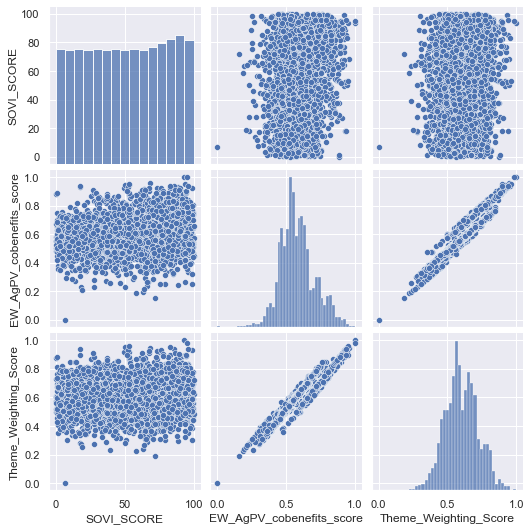

In [56]:
sns.pairplot(export_df[['SOVI_SCORE', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']])

<Axes: >

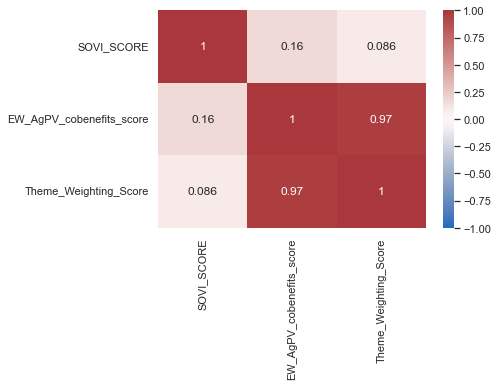

In [57]:
sns.heatmap(export_df[['SOVI_SCORE', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']].corr(), annot=True, cmap='vlag', vmin=-1, vmax=1)

<Axes: xlabel='SOVI_SCORE', ylabel='Theme_Weighting_Score'>

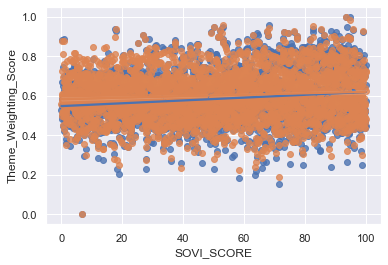

In [58]:
sns.regplot(export_df, x='SOVI_SCORE', y='EW_AgPV_cobenefits_score')
sns.regplot(export_df, x='SOVI_SCORE', y='Theme_Weighting_Score')

In [59]:
print(export_df.Theme_Weighting_Score.quantile([.2, .4, .6, .8]))
print(export_df['EW_AgPV_cobenefits_score'].quantile([.2, .4, .6, .8]))

0.2    0.497447
0.4    0.567203
0.6    0.634385
0.8    0.698884
Name: Theme_Weighting_Score, dtype: float64
0.2    0.479292
0.4    0.541283
0.6    0.602157
0.8    0.678955
Name: EW_AgPV_cobenefits_score, dtype: float64


In [135]:
export_df.loc['04001'].T

county                                                Apache
state                                                Arizona
capacity_mw_dc                                 861473.520644
Solar_supply_per_land_area                      64484.795996
generation_potential_ac                    1870285484.647532
generation_potential_dc                    1870285799.542866
ALAND_SQKM                                      29003.510917
RESL_SCORE                                              0.64
SOVI_SCORE                                              96.5
TRND_ALRA                                           0.000006
TRND_EALA                                         129.476307
SWND_ALRA                                                0.0
SWND_EALA                                           0.226696
HWAV_ALRA                                                0.0
HWAV_EALA                                                0.0
HAIL_ALRA                                           0.000008
HAIL_EALA                                         156.914955
DRGT_ALRA                                             0.0302
DRGT_EALA                                      623596.989589
Energy Burden (% income)                                 4.0
Percent Non Investor Owned                          5.192231
Value_veggies                                            NaN
Has_undisclosed_cropland                               False
Value_berries                                            NaN
Has_undisclosed_berries                                False
AgPV_crop_totals                                         0.0
Sheep_goats_total_sales                              1651000
Has_undisclosed_goats_sheep_totals                     False
Percent Woman-owned Sheep Goats Producers                0.0
Percent Nonwhite Sheep Goats Producers                 100.0
Avg Farm Net Income ($)                              -7228.0
Has_undisclosed_farm_income                            False
Percent Woman-owned Cropland                             4.0
Percent Non-white Cropland                              98.0
Pastureland                                        4926716.0
Has_undisclosed_pastureland                            False
tonne_co2_per_person                               11.054903
SolarPanelLandUse                                       0.05
ag_worker_heat_days                                    124.0
Ag_compatibility_exists                                 True
eala_sum_positive                              623753.904545
eala_net                                       623624.428237
EW_AgPV_cobenefits_score                            0.819452
Theme_Weighting_Score                               0.814414

In [136]:
export_df.loc[(~export_df.Ag_compatibility_exists), :].sort_values('Theme_Weighting_Score', ascending=False).head(20)

capacity_mw_dc  \
FIPS  county               state                        
05001 Arkansas             Arkansas       7196.072930   
05077 Lee                  Arkansas       5603.481746   
05095 Monroe               Arkansas       3808.468918   
05147 Woodruff             Arkansas       3668.476787   
06003 Alpine               California     2215.787120   
06075 San Francisco        California      110.355375   
08053 Hinsdale             Colorado       1006.113323   
08079 Mineral              Colorado       2121.596314   
08091 Ouray                Colorado      11135.708378   
08111 San Juan             Colorado         32.788962   
08117 Summit               Colorado       1187.062117   
11001 District of Columbia D.C.            420.091594   
12037 Franklin             Florida        4116.805026   
12087 Monroe               Florida           4.263192   
13053 Chattahoochee        Georgia        2995.247798   
13089 DeKalb               Georgia        2254.632932   
13215 Muscogee             Georgia        6885.689044   
13259 Stewart              Georgia       35207.428798   
17059 Gallatin             Illinois       6282.652917   
17185 Wabash               Illinois       5152.872224   

                                       Solar_supply_per_land_area  \
FIPS  county               state                                    
05001 Arkansas             Arkansas                   4963.168902   
05077 Lee                  Arkansas                   6352.450307   
05095 Monroe               Arkansas                   4281.192754   
05147 Woodruff             Arkansas                   4231.460364   
06003 Alpine               California                 2423.214823   
06075 San Francisco        California                 1671.893054   
08053 Hinsdale             Colorado                    681.562093   
08079 Mineral              Colorado                   1858.481209   
08091 Ouray                Colorado                  15085.101692   
08111 San Juan             Colorado                     63.227881   
08117 Summit               Colorado                   1362.255017   
11001 District of Columbia D.C.                       4397.968084   
12037 Franklin             Florida                    5418.853847   
12087 Monroe               Florida                       3.261496   
13053 Chattahoochee        Georgia                    8201.627300   
13089 DeKalb               Georgia                    5701.833545   
13215 Muscogee             Georgia                   21346.175208   
13259 Stewart              Georgia                   52733.100055   
17059 Gallatin             Illinois                  12637.926264   
17185 Wabash               Illinois                  14806.017805   

                                       generation_potential_ac  \
FIPS  county               state                                 
05001 Arkansas             Arkansas               1.275352e+07   
05077 Lee                  Arkansas               9.868494e+06   
05095 Monroe               Arkansas               6.735677e+06   
05147 Woodruff             Arkansas               6.421936e+06   
06003 Alpine               California             4.633897e+06   
06075 San Francisco        California             2.021547e+05   
08053 Hinsdale             Colorado               1.972180e+06   
08079 Mineral              Colorado               4.215425e+06   
08091 Ouray                Colorado               2.112416e+07   
08111 San Juan             Colorado               6.345946e+04   
08117 Summit               Colorado               2.146319e+06   
11001 District of Columbia D.C.                   6.962675e+05   
12037 Franklin             Florida                7.648940e+06   
12087 Monroe               Florida                8.303925e+03   
13053 Chattahoochee        Georgia                5.283704e+06   
13089 DeKalb               Georgia                3.952809e+06   
13215 Muscogee             Georgia                1.196950e+07   
13259 Stewa

In [137]:
export_df.loc[idx[:,:,'Alaska'], 'AgPV_crop_totals']

FIPS   county  state 
02013  NaN     Alaska      NaN
02020  NaN     Alaska    170.0
02050  NaN     Alaska      NaN
02060  NaN     Alaska      NaN
02070  NaN     Alaska      NaN
02090  NaN     Alaska     61.0
02100  NaN     Alaska      NaN
02110  NaN     Alaska      3.0
02122  NaN     Alaska     53.0
02130  NaN     Alaska      NaN
02150  NaN     Alaska      NaN
02170  NaN     Alaska      NaN
02180  NaN     Alaska      NaN
02185  NaN     Alaska      NaN
02188  NaN     Alaska      NaN
02220  NaN     Alaska      NaN
02240  NaN     Alaska      NaN
02290  NaN     Alaska      NaN
02261  NaN     Alaska      NaN
Name: AgPV_crop_totals, dtype: float64

### Comparing Methods for Index Calculation
I'm testing out 2 different ways of calculating index: equally weighting all variables, and first grouping variables into themes, averaging those themes, then averageing the themes. This "Theme" method will effectively add different weights to the index.

In [142]:
# export comparison of top n counties with each scoring method
n_count = 50
percentile = 0.95
threshold = export_quintiles_df.loc[percentile, 'Theme_Weighting_Score']
ew_thresh = export_quintiles_df.loc[percentile, 'EW_AgPV_cobenefits_score']

equal_weights = score_df[score_df['EW_AgPV_cobenefits_score'] > ew_thresh].sort_values(['EW_AgPV_cobenefits_score'], ascending=False, ignore_index=False)
themes = score_df[score_df['Theme_Weighting_Score'] > threshold].sort_values(['Theme_Weighting_Score'], ascending=False, ignore_index=False)

method_comp = pd.concat([equal_weights[['EW_AgPV_cobenefits_score']], themes[['Theme_Weighting_Score']]], axis=1)
method_comp.to_csv(f'score_method_top_{(1 - percentile) * 100}pct_comp.csv')
method_comp

EW_AgPV_cobenefits_score  Theme_Weighting_Score
FIPS  county     state                                                      
40021 Cherokee   Oklahoma                    1.000000               0.983181
35045 San Juan   New Mexico                  0.998209               1.000000
08077 Mesa       Colorado                    0.960273               0.945349
35053 Socorro    New Mexico                  0.949564               0.894313
48339 Montgomery Texas                       0.947669               0.958064
...                                               ...                    ...
19031 Cedar      Iowa                             NaN               0.811355
56003 Big Horn   Wyoming                          NaN               0.811147
20155 Reno       Kansas                           NaN               0.810807
55065 Lafayette  Wisconsin                        NaN               0.809920
49049 Utah       Utah                             NaN               0.806740

[173 rows x 2 columns]

In [146]:
equal_weights.index.get_level_values('state').value_counts()

state
Oklahoma          26
Texas             21
California        19
Washington        10
Oregon             9
Colorado           7
Montana            7
Alabama            6
Florida            6
Arizona            6
New Mexico         6
South Carolina     5
Missouri           4
Arkansas           4
Louisiana          4
Georgia            3
Kansas             2
Utah               1
Wyoming            1
Wisconsin          1
Idaho              1
Tennessee          1
North Carolina     1
Name: count, dtype: int64

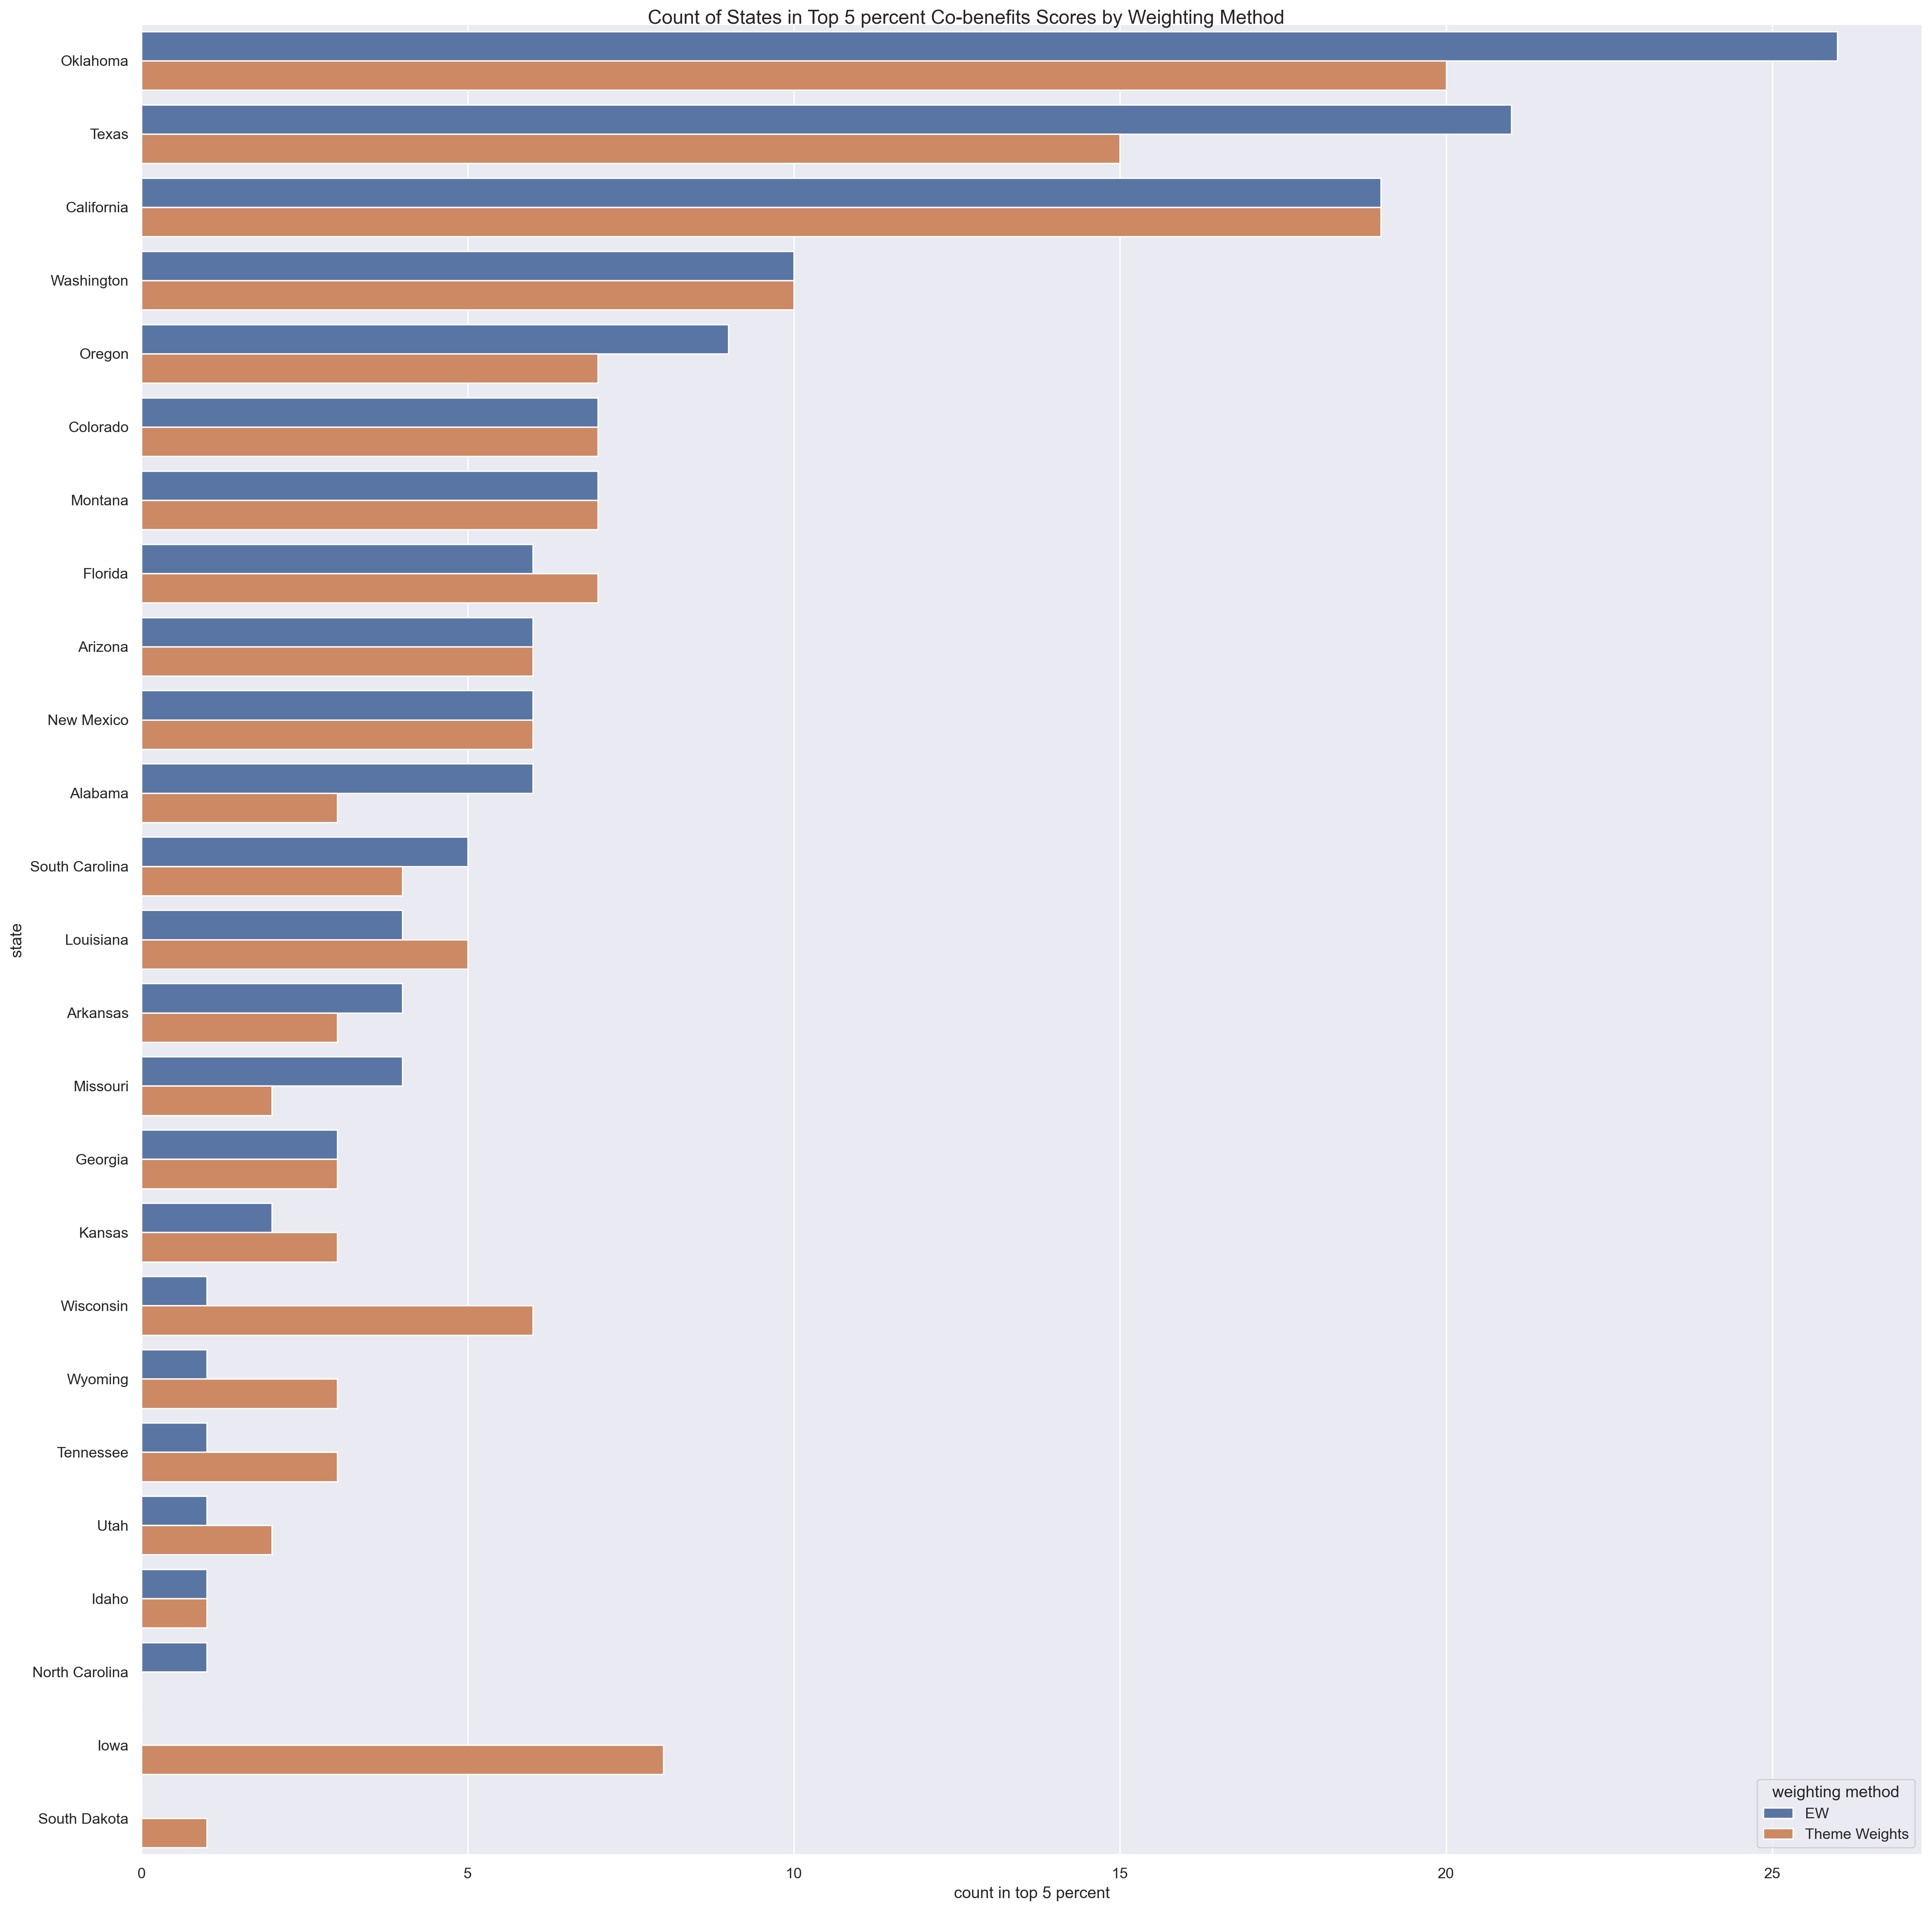

In [147]:
counts_df = pd.DataFrame()

ew_df = pd.DataFrame(equal_weights.index.get_level_values('state').value_counts(ascending=False)).rename(columns={'count':'EW'})
tw_df = pd.DataFrame(themes.index.get_level_values('state').value_counts(ascending=False)).rename(columns={'count':'Theme Weights'})
counts_df = pd.concat([ew_df, tw_df], axis=1)
counts_df = counts_df.fillna(0)
counts_df['Theme Weights'] = counts_df['Theme Weights'].astype(int)
counts_df['EW'] = counts_df['EW'].astype(int)

counts_df = counts_df.sort_values(['EW', 'Theme Weights'], ascending=[False, False])

value_name = f'count in top {(1-percentile) * 100:.0f} percent'
counts_df = counts_df.reset_index().melt(id_vars='state', value_name=value_name, var_name='weighting method')

fig, ax = plt.subplots(1, 1, dpi=250, figsize=(20,20))
g = sns.barplot(counts_df, y='state', x=value_name, hue='weighting method', ax=ax)
plt.suptitle(f'Count of States in Top {(1-percentile) * 100:.0f} percent Co-benefits Scores by Weighting Method')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'score_weight_state_comp2.png'))

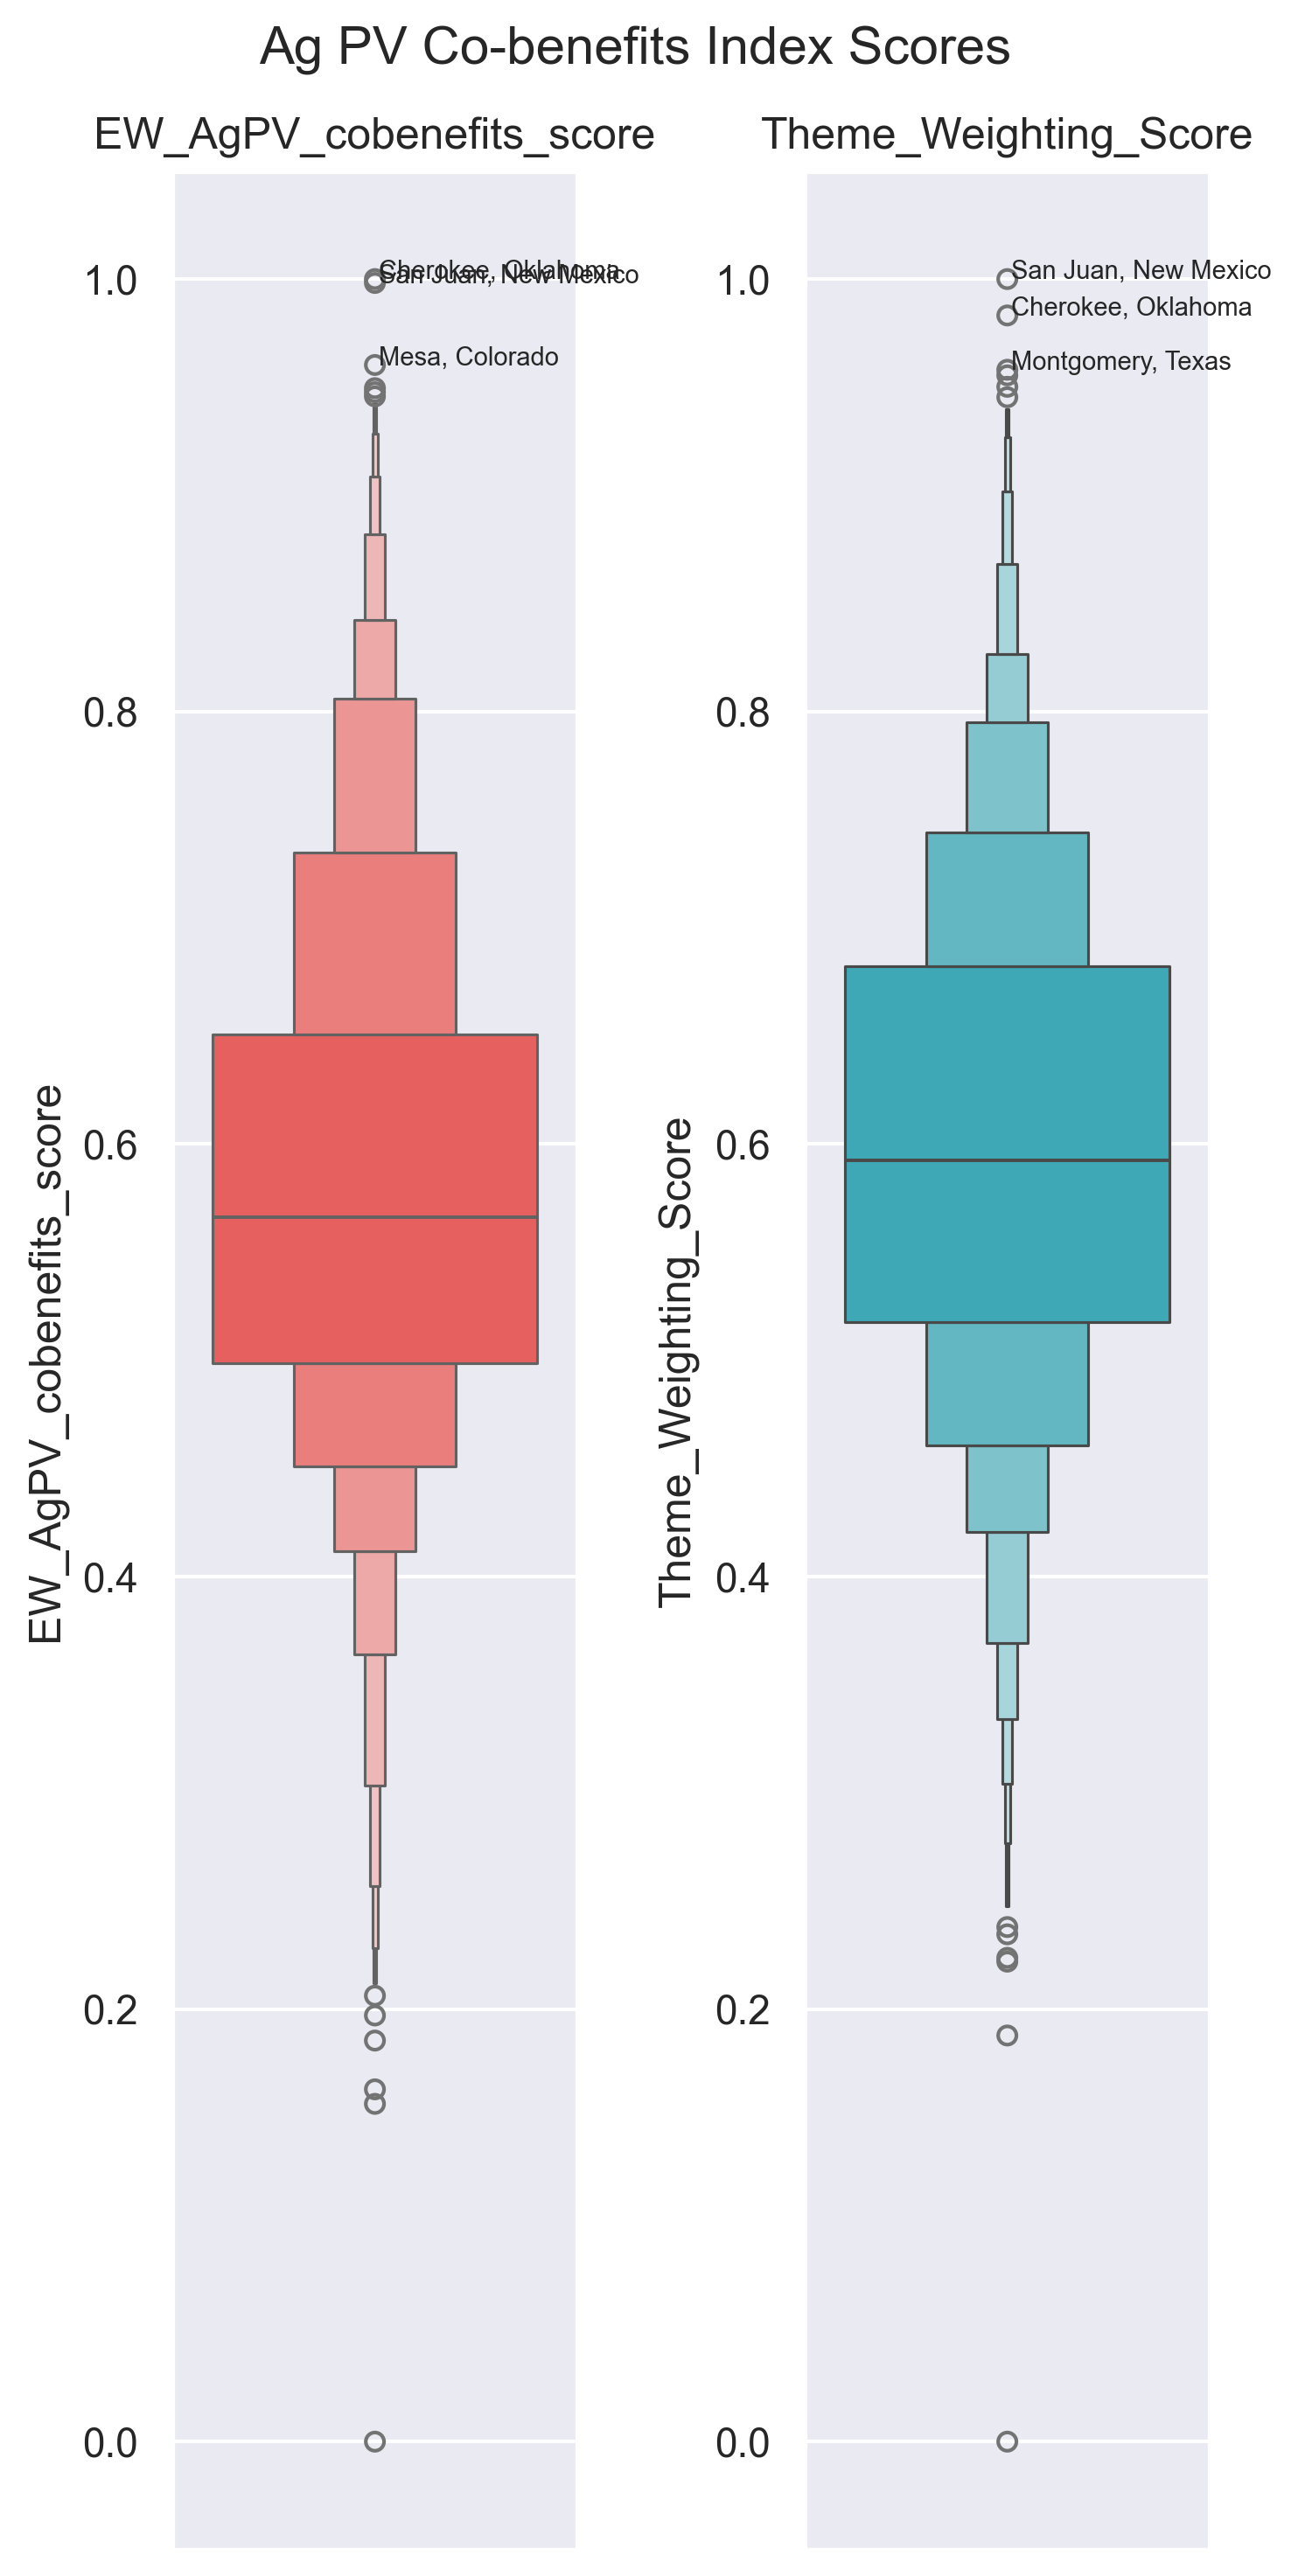

In [153]:
fig, axes = plt.subplots(1,2, figsize=(5,10), dpi=300)

# annotate top n outliers
def annotate_outliers(row, col, g):
    text = ', '.join([row.name[1], row.name[2]])
    y = row[col]
    g.annotate(text, xy=(0.01, y), ha='left', size=7)
    
colors = iter(['#FE4A49', '#2AB7CA'])

for metric, ax in zip(['EW_AgPV_cobenefits_score', 'Theme_Weighting_Score'], axes):
    g = sns.boxenplot(score_df, y=metric, ax=ax, color=next(colors))
    score_df.sort_values(metric, ascending=False).iloc[:3].apply(lambda x: annotate_outliers(x, metric, g), axis=1)
    ax.title.set_text(metric)

fig.suptitle('Ag PV Co-benefits Index Scores')
plt.tight_layout()
plt.savefig(os.path.join(graph_dir, 'agpv_score_boxen.png'))

In [154]:
merged_df.rank(pct=True).loc['40021', :]

capacity_mw_ac  capacity_mw_dc  Solar_supply_per_land_area  \
county   state                                                                  
Cherokee Oklahoma        0.734873        0.734873                    0.739102   

                   generation_potential_ac  generation_potential_dc  \
county   state                                                        
Cherokee Oklahoma                 0.737801                 0.737801   

                   ALAND_SQKM  RESL_SCORE  SOVI_SCORE  TRND_ALRA  TRND_EALA  \
county   state                                                                
Cherokee Oklahoma    0.627846     0.18931    0.946911   0.861042   0.733871   

                   ...  Percent Woman-owned Cropland  \
county   state     ...                                 
Cherokee Oklahoma  ...                      0.268934   

                   Percent Non-white Cropland  Pastureland  \
county   state                                               
Cherokee Oklahoma                    0.952087     0.770943   

                   Has_undisclosed_pastureland  tonne_co2_per_person  \
county   state                                                         
Cherokee Oklahoma                     0.482535              0.653846   

                   SolarPanelLandUse  ag_worker_heat_days  \
county   state                                              
Cherokee Oklahoma           0.309835             0.970015   

                   Ag_compatibility_exists  eala_sum_positive  eala_net  
county   state                                                           
Cherokee Oklahoma                 0.536012           0.873261   0.87357  

[1 rows x 51 columns]

In [155]:
score_df.loc[['08031'], :].T #.sort_values('Theme_Weighting_Score')

FIPS                                                 08031
county                                              Denver
state                                             Colorado
capacity_mw_dc                                 5334.183122
Solar_supply_per_land_area                    26243.787607
generation_potential_ac                    10404615.426895
generation_potential_dc                    10404616.957947
ALAND_SQKM                                      396.460129
RESL_SCORE                                       54.389999
SOVI_SCORE                                       58.209999
TRND_ALRA                                         0.000064
TRND_EALA                                       114.654391
SWND_ALRA                                          0.00002
SWND_EALA                                        36.583656
HWAV_ALRA                                              0.0
HWAV_EALA                                              0.0
HAIL_ALRA                                         0.002656
HAIL_EALA                                         4764.999
DRGT_ALRA                                         0.000223
DRGT_EALA                                       400.834118
Energy Burden (% income)                               1.0
Percent Non Investor Owned                             0.0
Value_veggies                                          0.0
Has_undisclosed_veggies                               True
Value_berries                                          NaN
Has_undisclosed_berries                              False
AgPV_crop_totals                                       0.0
Sheep_goats_total_sales                                  0
Has_undisclosed_goats_sheep_totals                    True
Percent Woman-owned Sheep Goats Producers              0.0
Percent Nonwhite Sheep Goats Producers                 0.0
Avg Farm Net Income ($)                            -3380.0
Has_undisclosed_farm_income                          False
Percent Woman-owned Cropland                           0.0
Percent Non-white Cropland                             0.0
Pastureland                                            0.0
Has_undisclosed_pastureland                           True
tonne_co2_per_person                             15.183116
SolarPanelLandUse                                      0.3
ag_worker_heat_days                               22173.25
Ag_compatibility_exists                               True
eala_sum_positive                              5165.833118
eala_net                                       5051.178727
EW_AgPV_cobenefits_score                           0.18546
Theme_Weighting_Score                             0.223718

### East v West Analysis
Check if west has more opportunity than east

In [156]:
quantile_thresh = 0.8
thresh_value = export_quintiles_df.loc[quantile_thresh, 'Theme_Weighting_Score']
export_quintiles_df

capacity_mw_dc  Solar_supply_per_land_area  generation_potential_ac  \
quantile                                                                        
0.20         7002.081019                 9328.713226             1.159228e+07   
0.40        13783.497159                15938.782364             2.292209e+07   
0.60        23373.027742                23708.666460             3.968024e+07   
0.80        43401.939688                34982.083007             7.691666e+07   
0.95       127757.115112                52555.356357             2.447962e+08   

          generation_potential_dc   ALAND_SQKM  RESL_SCORE  SOVI_SCORE  \
quantile                                                                 
0.20                 1.159228e+07  1049.133465   20.002000   20.500000   
0.40                 2.292209e+07  1433.508701   40.001999   40.990002   
0.60                 3.968024e+07  1855.762541   59.998001   61.459999   
0.80                 7.691666e+07  2658.586921   79.998003   81.379997   
0.95                 2.447962e+08  7529.151953   94.997000   95.230003   

          TRND_ALRA     TRND_EALA  SWND_ALRA  ...  \
quantile                                      ...   
0.20       0.000007    151.330615   0.000001  ...   
0.40       0.000016    754.386515   0.000008  ...   
0.60       0.000025   1997.789569   0.000056  ...   
0.80       0.000038   4754.976864   0.000200  ...   
0.95       0.000072  12829.927929   0.000828  ...   

          Percent Woman-owned Cropland  Percent Non-white Cropland  \
quantile                                                             
0.20                              17.0                         0.0   
0.40                              31.0                         0.0   
0.60                              49.0                         0.0   
0.80                              74.0                         0.0   
0.95                              91.0                        78.0   

          Pastureland  tonne_co2_per_person  SolarPanelLandUse  \
quantile                                                         
0.20           2756.4             11.088011               0.05   
0.40           9304.4             15.345368               0.05   
0.60          26854.4             21.161984               0.05   
0.80         126549.6             22.341196               0.30   
0.95         548356.3             41.797864               2.05   

          ag_worker_heat_days  eala_sum_positive      eala_net  \
quantile                                                         
0.20                     0.00       4.110660e+03  2.865911e+03   
0.40                   215.70       2.479823e+04  2.241113e+04   
0.60                   643.50       9.100832e+04  8.764720e+04   
0.80                  1561.35       3.379623e+05  3.338714e+05   
0.95                  6073.20       1.364930e+06  1.353600e+06   

          EW_AgPV_cobenefits_score  Theme_Weighting_Score  
quantile                                                   
0.20                      0.477704               0.495438  
0.40                      0.540281               0.566660  
0.60                      0.601484               0.633292  
0.80                      0.677402               0.698238  
0.95                      0.819393               0.805692  

[5 rows x 36 columns]

In [160]:
state_abbrevs_file = 'us-states-territories.csv'
county_file = 'US_FIPS_Codes.xls'
state_df = pd.read_csv(os.path.join(data_dir, state_abbrevs_file), encoding='unicode_escape')
state_df['Name'] = state_df['Name'].apply(lambda x: x.strip().title())

regional_df = export_df.merge(state_df, left_on='state', right_on='Name')
regional_df = regional_df[['Region', 'generation_potential_ac', 'Theme_Weighting_Score', 'EW_AgPV_cobenefits_score']]
regional_df.loc[regional_df['Theme_Weighting_Score'] > thresh_value, ['Region', 'generation_potential_ac', 'EW_AgPV_cobenefits_score', 'Theme_Weighting_Score']].groupby('Region').count()

generation_potential_ac  EW_AgPV_cobenefits_score  \
Region                                                      
East                        171                       171   
West                        427                       427   

        Theme_Weighting_Score  
Region                         
East                      171  
West                      427

In [161]:
from scipy import stats

topn_df = regional_df.loc[regional_df['Theme_Weighting_Score'] > thresh_value, :]

for col in ['generation_potential_ac', 'Theme_Weighting_Score', 'EW_AgPV_cobenefits_score']:
    print(f'Testing {col}...')
    a = topn_df.loc[regional_df['Region'] == 'West', col]
    b = topn_df.loc[regional_df['Region'] == 'East', col]

    # is West greater than east?
    print('T-test', a.mean(), b.mean())
    print(stats.ttest_ind(a, b, alternative='greater'), '\n')
    
    # are the raw counts the same in the top n pct?
    print('Chi Square:', len(a), len(b))
    print(stats.chisquare([len(a), len(b)]), '\n')
    
    # are the counties in west ranked higher than the counties in east?
    print('Man Whitney U Test')
    print(stats.mannwhitneyu(a, b, alternative='greater'))
    print('-'*20)
    print('\n')

Testing generation_potential_ac...
T-test 127244947.85062689 37313242.55974686
Ttest_indResult(statistic=4.8905735146530365, pvalue=6.47490124364664e-07) 

Chi Square: 427 171
Power_divergenceResult(statistic=109.59197324414716, pvalue=1.203870610192897e-25) 

Man Whitney U Test
MannwhitneyuResult(statistic=50724.0, pvalue=4.817486244570634e-14)
--------------------


Testing Theme_Weighting_Score...
T-test 0.7774138476657445 0.7643532869652722
Ttest_indResult(statistic=2.472805654805859, pvalue=0.006841784655489944) 

Chi Square: 427 171
Power_divergenceResult(statistic=109.59197324414716, pvalue=1.203870610192897e-25) 

Man Whitney U Test
MannwhitneyuResult(statistic=40368.0, pvalue=0.021622139525828005)
--------------------


Testing EW_AgPV_cobenefits_score...
T-test 0.7678870280080384 0.7451099154424411
Ttest_indResult(statistic=3.2201162578452722, pvalue=0.0006755512347086716) 

Chi Square: 427 171
Power_divergenceResult(statistic=109.59197324414716, pvalue=1.203870610192897e-25)

## Clustering
Let's do some simple unsupervised learning on this data set. Maybe using clusters can provide more nuaced themes and analysis for groups that a single number might overlook.

This [post](https://medium.com/@jackiee.jecksom/clustering-and-principal-component-analysis-pca-from-sklearn-c8ea5fed6648) has some cool visualization ideas: 

In [183]:
test_df = merged_df[index_vars]
test_df[test_df.isna().any(axis=1)]

eala_net  Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                                      
11001       0.000000                       1.0                      0.0   
44001    3882.063445                       2.0                   5948.0   
44003   23022.454676                       3.0                  -1660.0   
44005  146917.653391                       3.0                  25747.0   
44007   84129.624359                       3.0                    411.0   
...              ...                       ...                      ...   
02232       0.000000                       NaN                      0.0   
11031       0.000000                       NaN                      0.0   
02010       0.000000                       NaN                      0.0   
02          0.000000                       NaN                      0.0   
02261       0.000000                       NaN                      0.0   

       Percent Non-white Cropland  Percent Non Investor Owned  \
FIPS                                                            
11001                         0.0                         0.0   
44001                         0.0                         0.0   
44003                         0.0                         0.0   
44005                         0.0                         0.0   
44007                         0.0                         0.0   
...                           ...                         ...   
02232                         0.0                         0.0   
11031                         0.0                         0.0   
02010                         0.0                         0.0   
02                           60.0                         0.0   
02261                         0.0                         0.0   

       Percent Woman-owned Cropland  AgPV_crop_totals  \
FIPS                                                    
11001                           0.0                 0   
44001                          33.0                 0   
44003                          23.0                16   
44005                          47.0                85   
44007                          26.0                51   
...                             ...               ...   
02232                           0.0                 0   
11031                           0.0                 0   
02010                           0.0                 0   
02                             22.2                 0   
02261                           0.0                 0   

       Sheep_goats_total_sales  Percent Nonwhite Sheep Goats Producers  \
FIPS                                                                     
11001                        0                                     0.0   
44001                        0                                     0.0   
44003                    11000                                     0.0   
44005                    46000                                     0.0   
44007                   115000                                     0.0   
...                        ...                                     ...   
02232                        0                                     0.0   
11031                        0                                     0.0   
02010                        0                                     0.0   
02                           0                                     0.0   
02261                        0                                     0.0   

       Percent Woman-owned Sheep Goats Producers  tonne_co2_per_person  \
FIPS                                                                     
11001                                        0.0                   NaN   
44001                                       34.0                   NaN   
44003                                       14.0                   NaN   
44005                                       39.0                   NaN   
44007                                    

<Axes: >

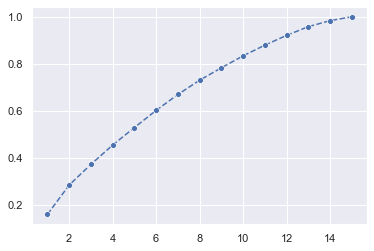

In [263]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation

cluster_vars = index_vars + ['capacity_mw_dc', 'SOVI_SCORE']
to_cluster_df = merged_df[cluster_vars].dropna() # merged_df.loc[(merged_df['AgPV_crop_totals'] > 0) | (merged_df['Sheep_goats_total_sales'] > 0), cluster_vars]

# normalize data
X_norm = StandardScaler().fit_transform(to_cluster_df)

# principal component analysis
kpca = KernelPCA(kernel='linear')
kpca.fit(X_norm)
scores_kpca = kpca.transform(X_norm)

# get percent variance explained
explained_variance = np.var(scores_kpca, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

sns.lineplot(x=range(1, len(explained_variance_ratio) + 1), y=explained_variance_ratio.cumsum(), marker='o', linestyle='--')

In [264]:
n_comps=11
pca = KernelPCA(n_components=n_comps, kernel='linear')
pca.fit(X_norm)
scores_pca = pca.transform(X_norm)

k_values = range(2,21)
# clustering
WCSS = [] # holds within cluster sum of squares for eack value of k

for k in k_values:
    kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
    kmeans_pca.fit(scores_pca)
    WCSS.append(kmeans_pca.inertia_)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. 

Text(0, 0.5, 'WCSS')

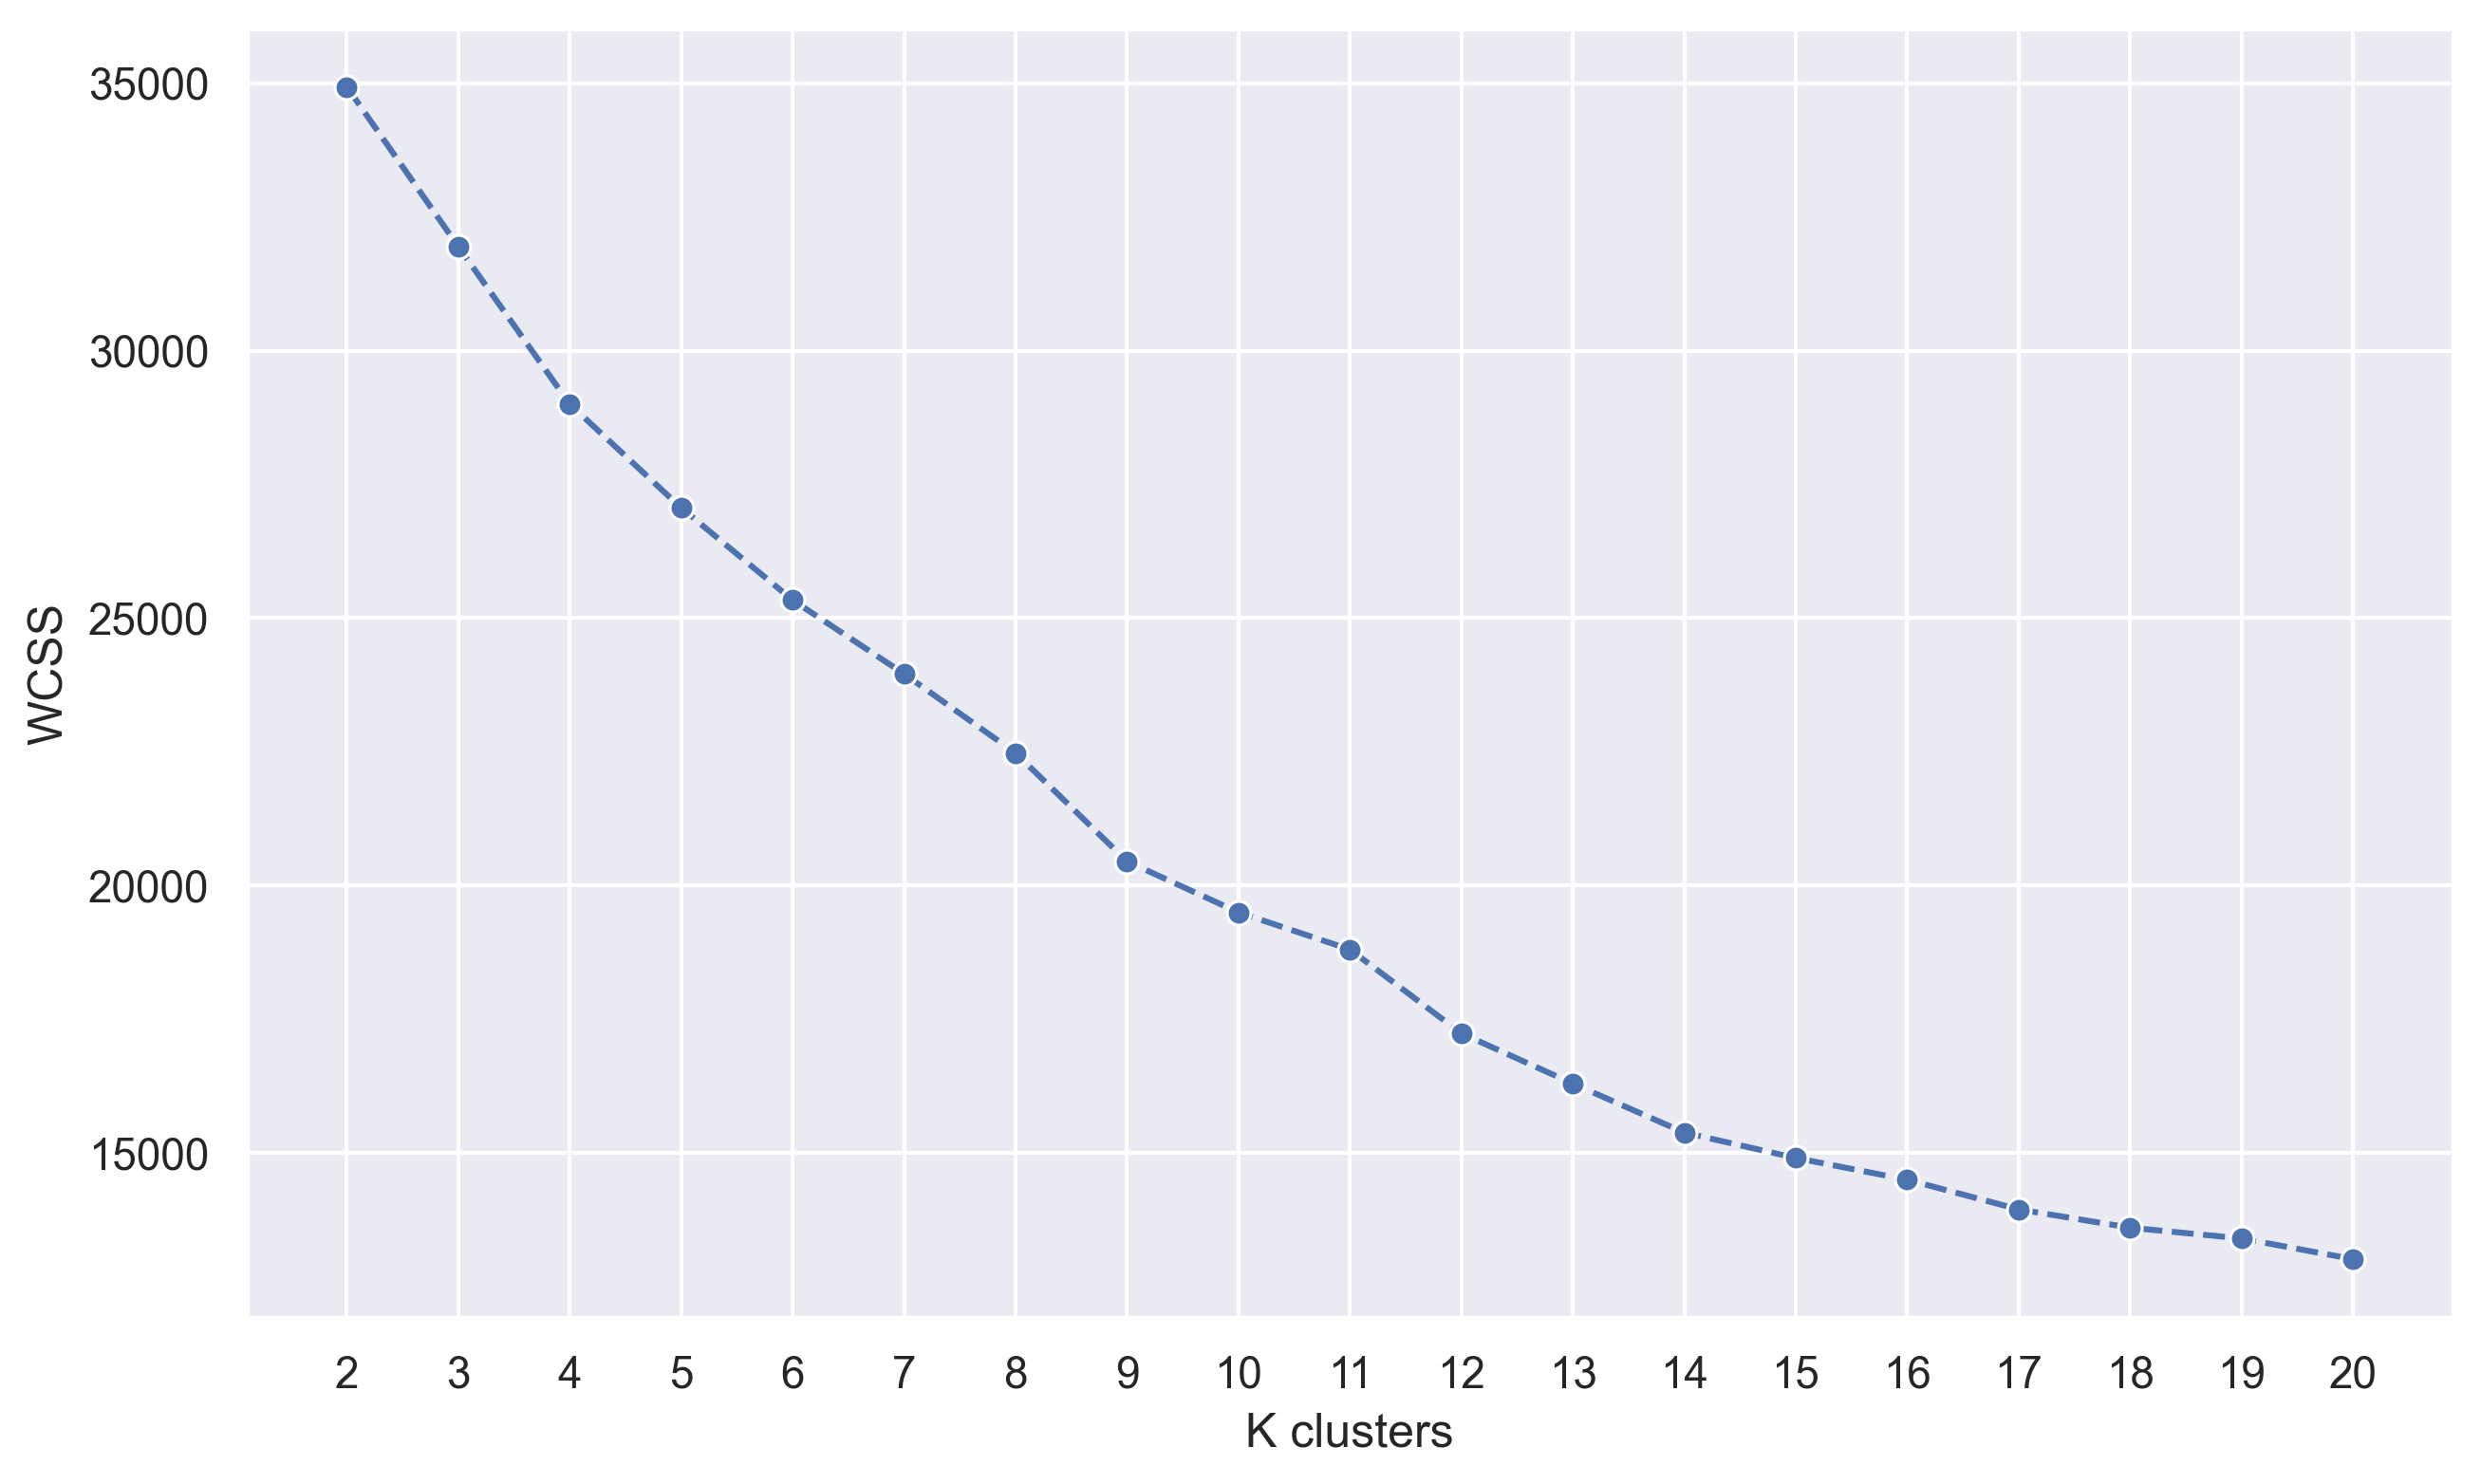

In [265]:
plt.figure(figsize=(10,6), dpi=300)
g = sns.lineplot(x=k_values, y=WCSS, marker='o', linestyle='--')
g.set_xticks(k_values)
g.set_xlabel('K clusters')
g.set_ylabel('WCSS')

There's no clear elbow point.

In [266]:
k = 9
kmeans_pca = KMeans(n_clusters=k, init='k-means++', random_state=123)
kmeans_pca.fit(scores_pca)

C:\Users\stanley27\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=9, random_state=123)

In [267]:
# Add pricipal components to original df
pc_col_names = ['PC' + str(k + 1) for k in range(n_comps)]
cluster_df = pd.concat([to_cluster_df, pd.DataFrame(scores_pca, columns=pc_col_names, index=to_cluster_df.index)], axis=1)

# add labels from kmeans
cluster_df['Cluster'] = kmeans_pca.labels_
cluster_df['Cluster'] = cluster_df['Cluster'].astype(str)
cluster_df

eala_net  Energy Burden (% income)  Avg Farm Net Income ($)  \
FIPS                                                                      
01001   20828.748821                       3.0                  29477.0   
01003  443676.897072                       2.0                  36125.0   
01005  196296.181220                       4.0                 122245.0   
01007    4751.245599                       4.0                   1623.0   
01009   10964.282012                       3.0                 120481.0   
...              ...                       ...                      ...   
56037    3454.037437                       2.0                  36158.0   
56039    1504.537027                       2.0                  12579.0   
56041    2538.875689                       3.0                  19121.0   
56043   13932.467121                       4.0                  90376.0   
56045    -530.078908                       7.0                  23922.0   

       Percent Non-white Cropland  Percent Non Investor Owned  \
FIPS                                                            
01001                        68.0                    2.942734   
01003                         0.0                    9.632698   
01005                        74.0                    4.668915   
01007                         0.0                    2.942734   
01009                         0.0                    0.000000   
...                           ...                         ...   
56037                         0.0                    0.003478   
56039                         0.0                   22.753224   
56041                         0.0                    0.000000   
56043                         0.0                    8.685847   
56045                         0.0                   91.119574   

       Percent Woman-owned Cropland  AgPV_crop_totals  \
FIPS                                                    
01001                          32.0                 0   
01003                          33.0               117   
01005                          28.0                 0   
01007                          21.0                 0   
01009                          24.0                 0   
...                             ...               ...   
56037                          13.0                 0   
56039                          29.0                 0   
56041                          11.0                 0   
56043                          17.0                 0   
56045                           3.0                 0   

       Sheep_goats_total_sales  Percent Nonwhite Sheep Goats Producers  \
FIPS                                                                     
01001                    78000                                    73.0   
01003                   136000                                     0.0   
01005                    22000                                    11.0   
01007                    72000                                     0.0   
01009                   111000                                     0.0   
...                        ...                                     ...   
56037                        0                                     0.0   
56039                     7000                                     0.0   
56041                  4764000                                     0.0   
56043                        0                                     0.0   
56045                    76000                                     0.0   

       Percent Woman-owned Sheep Goats Producers  ...       PC3       PC4  \
FIPS                                              ...                       
01001                                       18.0  ... -1.226002 -1.131730   
01003                                       11.0  ... -0.456285  1.134952   
01005                                       87.0  ...  0.650636 -1.182872   
01007                                       19.0  ... -0.177553 -0.189375   
01009                  

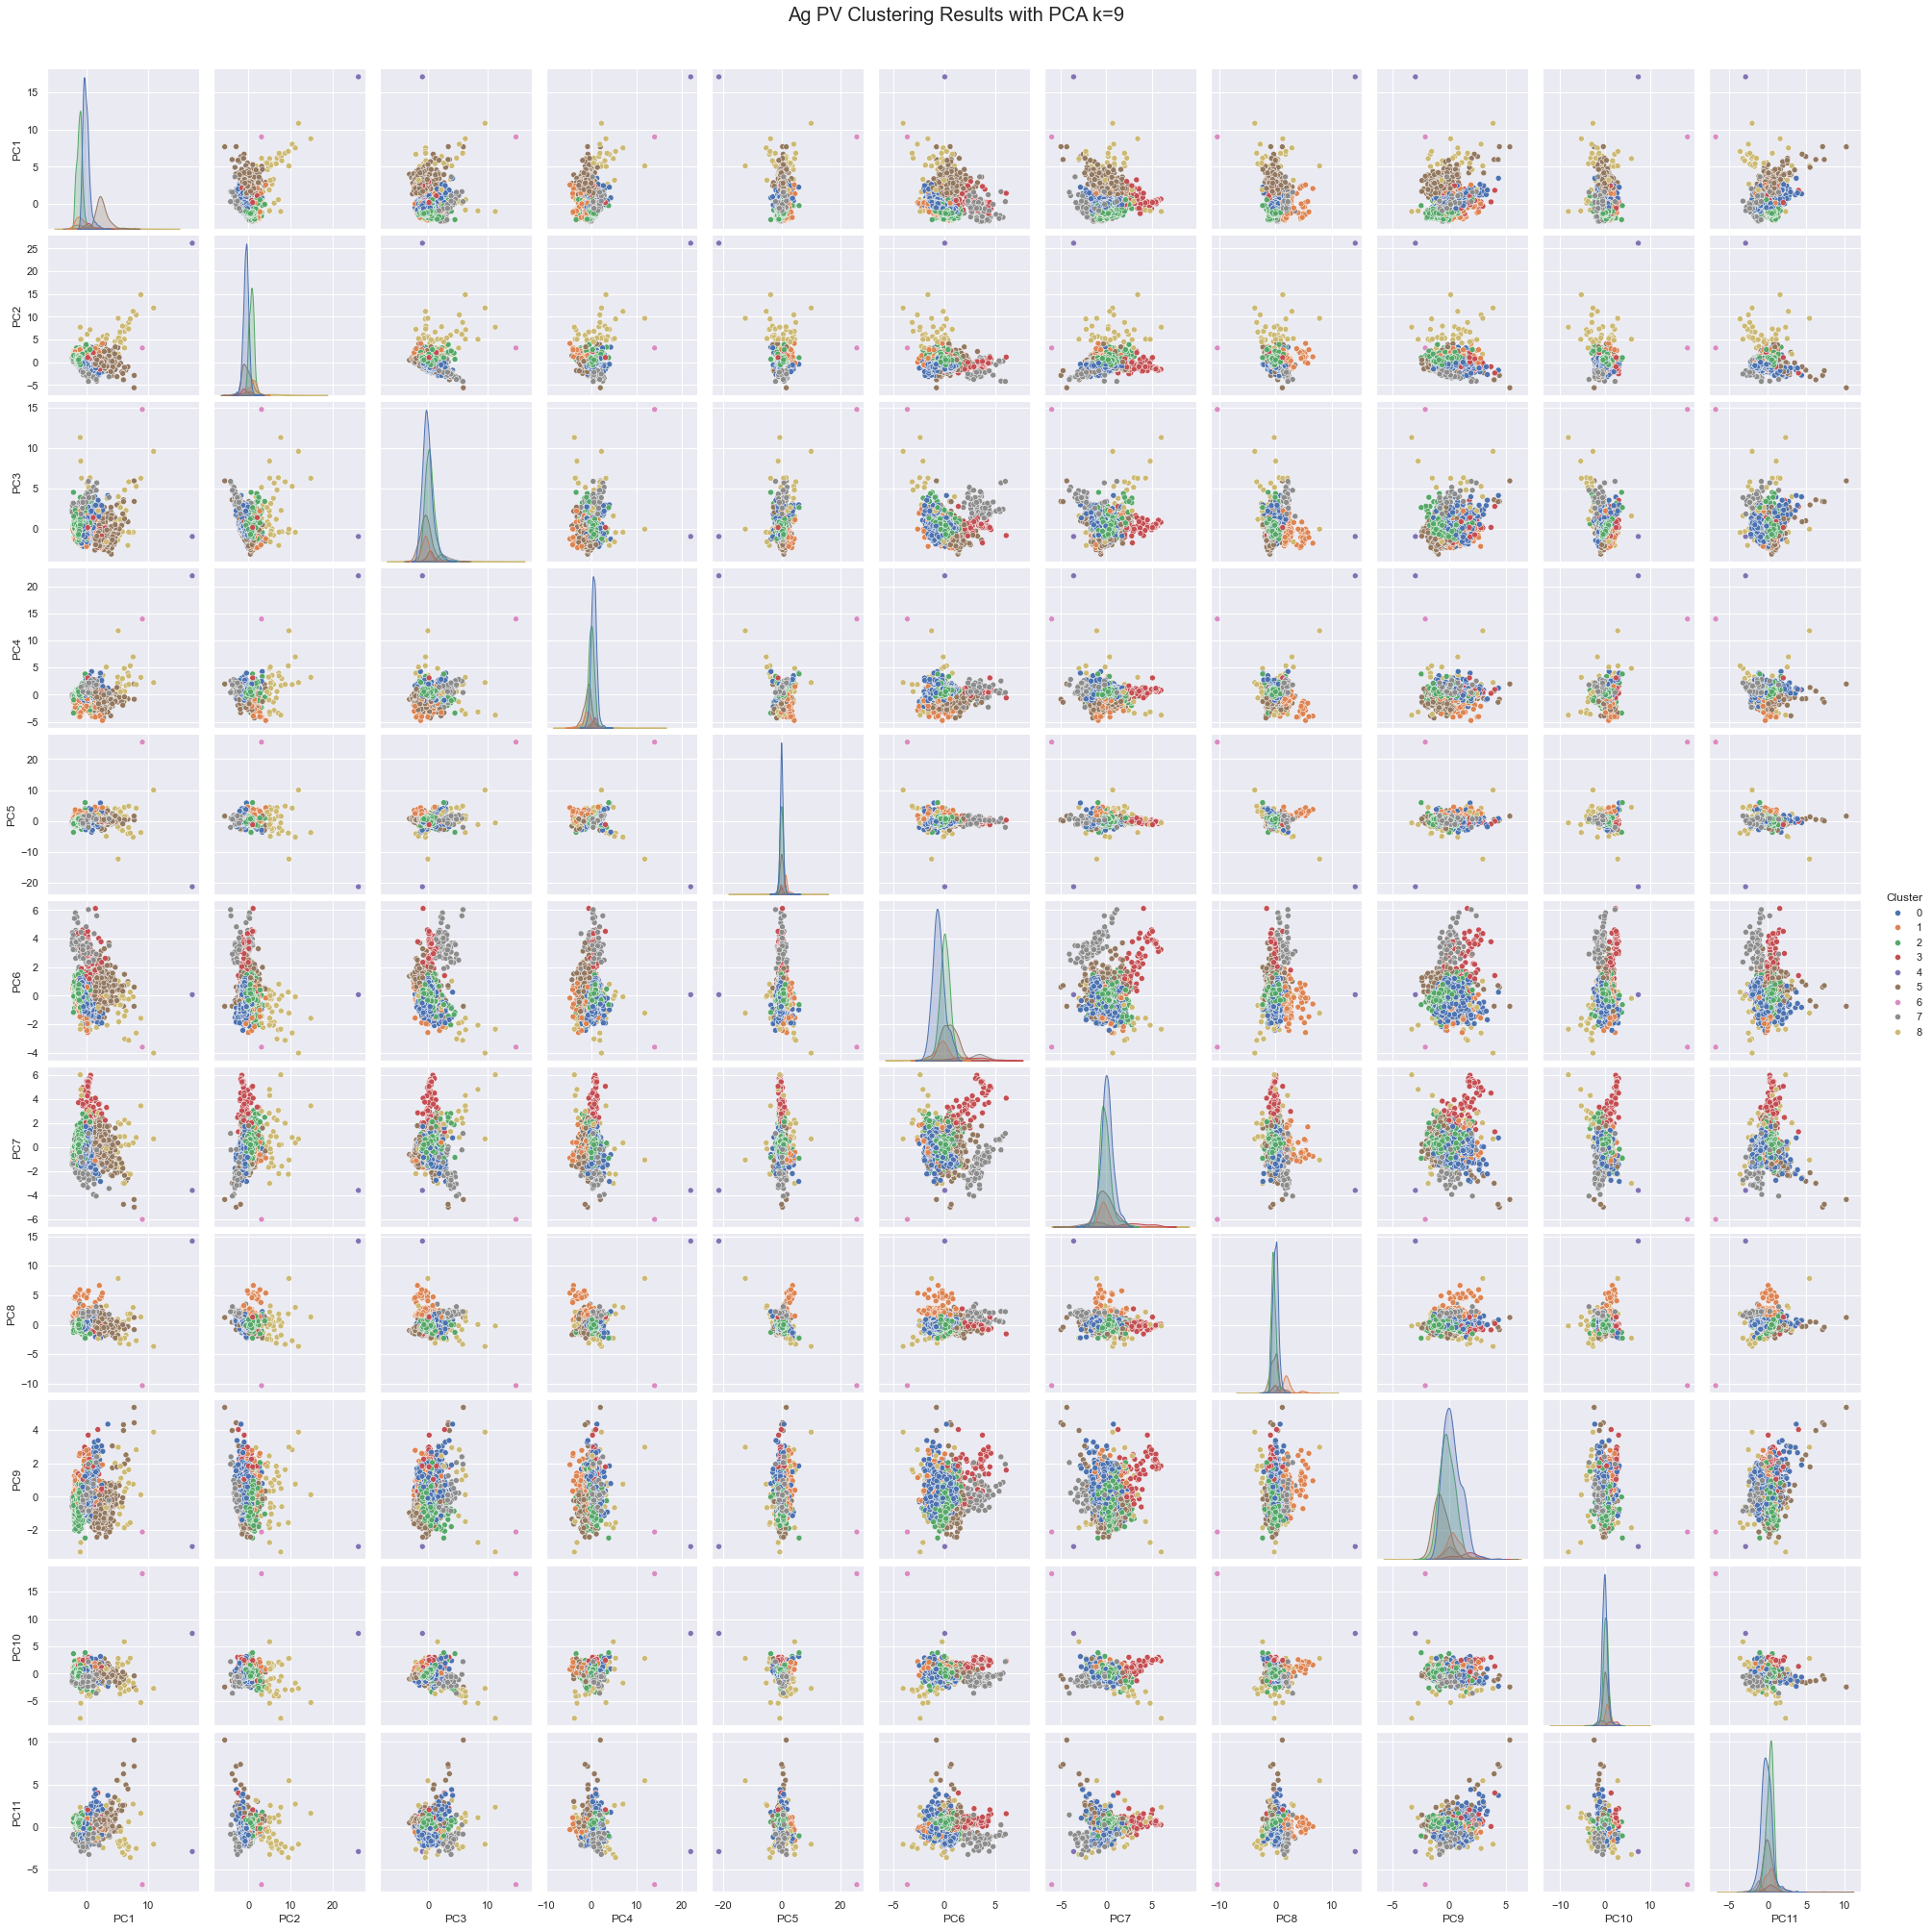

In [268]:
sns.pairplot(cluster_df.iloc[:,-n_comps-1:], hue='Cluster', hue_order=sorted(cluster_df['Cluster'].unique()))
plt.suptitle(f'Ag PV Clustering Results with PCA k={k}', size=20, y=1.02)
plt.savefig(os.path.join(graph_dir, 'agpv_pca_clustering.png'))

## Clustering Analysis
Most of the results seem jumbled together, but there's a few groups that stand out.

Let's have a look at the clusters:

In [276]:
cluster_summary = cluster_df.groupby(['Cluster']).mean()
# drop pc values
cluster_summary = cluster_summary.loc[:, :'PC1']
cluster_summary

TRND_ALRA     HWAV_ALRA  DRGT_ALRA  Energy Burden (% income)  \
Cluster                                                                 
0         0.000026  3.399676e-05   0.001506                  3.685624   
1         0.000036  1.366828e-05   0.002921                  3.087607   
10        0.000024  1.031590e-05   0.000092                  3.289474   
2         0.000020  3.205593e-05   0.003403                  3.127072   
3         0.000034  6.580003e-06   0.001793                  3.587258   
4         0.000006  7.005022e-05   0.021168                  2.142857   
5         0.000860  1.267475e-07   0.010030                  4.200000   
6         0.000033  1.646495e-05   0.001388                  2.960526   
7         0.000004  3.104818e-04   0.059919                  2.637931   
8         0.000098  0.000000e+00   0.000024                  2.000000   
9         0.000021  1.869069e-05   0.003080                  2.594817   

         Avg Farm Net Income ($)  Percent Non-white Cropland  \
Cluster                                                        
0                  190031.339652                    0.251185   
1                   48996.880342                   66.700855   
10                 146759.118421                    2.447368   
2                  108407.585635                    2.309392   
3                   60982.943213                    0.168975   
4                  372826.285714                   50.857143   
5                   33127.400000                    0.000000   
6                   49719.328947                   12.315789   
7                  161251.724138                   40.724138   
8                  149768.000000                   56.000000   
9                   35904.151943                    0.075383   

         Percent Non Investor Owned  Percent Woman-owned Cropland  \
Cluster                                                             
0                          3.561532                     77.872038   
1                          6.768763                     32.540598   
10                        19.877452                     51.842105   
2                          2.440473                     63.828729   
3                          3.106410                     26.045706   
4                          3.197896                     38.428571   
5                          0.000000                      1.600000   
6                         65.609216                     35.631579   
7                          3.659758                     27.413793   
8                         12.411154                     44.000000   
9                          3.323019                     41.942285   

         AgPV_crop_totals  Sheep_goats_total_sales  \
Cluster                                              
0               31.906793             2.353460e+05   
1              141.555556             3.375064e+05   
10               0.526316             5.663947e+05   
2               11.696133             1.966354e+05   
3               38.451524             3.125762e+05   
4            41866.714286             2.614286e+05   
5                0.000000             6.440000e+04   
6              207.736842             2.169474e+05   
7              181.534483             1.475293e+06   
8               70.000000             5.838300e+07   
9              169.055359             2.519635e+05   

         Percent Nonwhite Sheep Goats Producers  \
Cluster                                           
0                                      0.322275   
1                                     49.786325   
10                                     2.171053   
2                                      4.127072   
3                                      0.070637   
4                                     72.714286   
5                                      0.000000   
6                                      5.434211   
7                                     45.034483   
8                                     18.000000   
9            

In [277]:
cluster_df.groupby('Cluster').describe()

TRND_ALRA                                                        \
            count      mean       std           min       25%       50%   
Cluster                                                                   
0           633.0  0.000026  0.000019  4.719247e-07  0.000013  0.000024   
1           468.0  0.000036  0.000034  1.374777e-07  0.000014  0.000027   
10           76.0  0.000024  0.000015  1.913236e-06  0.000013  0.000020   
2           181.0  0.000020  0.000011  0.000000e+00  0.000011  0.000018   
3           722.0  0.000034  0.000040  0.000000e+00  0.000012  0.000026   
4             7.0  0.000006  0.000009  3.962449e-07  0.000001  0.000001   
5             5.0  0.000860  0.000237  6.150803e-04  0.000685  0.000778   
6            76.0  0.000033  0.000030  3.773024e-07  0.000011  0.000028   
7            58.0  0.000004  0.000006  1.339409e-07  0.000001  0.000003   
8             1.0  0.000098       NaN  9.849107e-05  0.000098  0.000098   
9           849.0  0.000021  0.000017  0.000000e+00  0.000007  0.000017   

                            HWAV_ALRA                ...       PC10  \
              75%       max     count          mean  ...        75%   
Cluster                                              ...              
0        0.000034  0.000174     633.0  3.399676e-05  ...  -0.164656   
1        0.000045  0.000236     468.0  1.366828e-05  ...  -0.092195   
10       0.000033  0.000068      76.0  1.031590e-05  ...   0.721260   
2        0.000026  0.000059     181.0  3.205593e-05  ...   1.810027   
3        0.000040  0.000412     722.0  6.580003e-06  ...   0.254722   
4        0.000005  0.000026       7.0  7.005022e-05  ...   2.238941   
5        0.001085  0.001136       5.0  1.267475e-07  ...  11.883506   
6        0.000047  0.000140      76.0  1.646495e-05  ...   1.626346   
7        0.000004  0.000040      58.0  3.104818e-04  ...   2.494161   
8        0.000098  0.000098       1.0  0.000000e+00  ... -10.273828   
9        0.000028  0.000120     849.0  1.869069e-05  ...   0.136672   

                     PC11                                             \
               max  count       mean       std        min        25%   
Cluster                                                                
0         1.429633  633.0   0.043375  0.673625  -2.542012  -0.363708   
1         1.841566  468.0  -0.351385  0.653356  -2.728302  -0.816146   
10        2.395692   76.0  -0.029435  0.696761  -1.879502  -0.508185   
2         5.373860  181.0   0.377849  0.728896  -1.382624  -0.117098   
3         4.053676  722.0   0.114647  0.711633  -1.723009  -0.367422   
4         6.815472    7.0   0.331212  1.174081  -1.187115  -0.472368   
5        12.931455    5.0  -1.218671  1.125511  -2.534523  -2.004807   
6         2.456058   76.0   1.527150  0.986481  -0.161248   0.673978   
7         4.274962   58.0  -0.290361  2.611102  -6.766180  -1.855335   
8       -10.273828    1.0  17.764173       NaN  17.764173  17.764173   
9         1.840461  849.0  -0.147408  0.617865  -2.080559  -0.555314   

                                          
               50%        75%        max  
Cluster                                   
0        -0.001417   0.459811   2.716650  
1        -0.364093   0.039679   2.311896  
10       -0.112274   0.404925   2.138750  
2         0.282485   0.853066   2.866715  
3         0.026278   0.538458   3.758878  
4         0.340520   1.046857   2.016100  
5        -1.242113  -0.634678   0.322765  
6         1.567699   2.386086   3.841577  
7         0.212807   1.276404   5.621886  
8        17.764173  17.764173  17.764173  
9        -0.215782   0.237630   2.523694  

[11 rows x 216 columns]

### Clustering with fewer variables
The index is composed of many uncorreleated independent variables. Dimensionality reduction techniues didn't help much since the variables are uncorrelated. Let's try an equity focused clustering with a subset of the variables

In [278]:
equity_cluster_cols = ['capacity_mw_ac', 
                       #'SOVI_SCORE',
                       'Energy Burden (% income)',
                       #'Percent Minority Owned', 
                       #'AgPV_crop_totals',
                       'Sheep_goats_total_sales',
                       'Percent Nonwhite Sheep Goats Producers'
                      ]
equity_cluster_df = merged_df[equity_cluster_cols]
"""equity_cluster_df = equity_cluster_df.loc[(equity_cluster_df['Sheep_goats_total_sales'] > 0) & \
                                          (equity_cluster_df['capacity_mw_ac'] > 0), :]"""

# equity_cluster_df['Sheep_goats_total_sales'] = np.log(equity_cluster_df['Sheep_goats_total_sales'])
# equity_cluster_df['capacity_mw_ac'] = np.log(equity_cluster_df['capacity_mw_ac'])
# equity_cluster_df.iloc[:, :-1] = np.log(equity_cluster_df.iloc[:, :-1])
equity_cluster_df

capacity_mw_ac  Energy Burden (% income)  Sheep_goats_total_sales  \
FIPS                                                                       
01001    22349.202978                       3.0                    78000   
01003    46948.973155                       2.0                   136000   
01005    43344.657028                       4.0                    22000   
01007    28368.690972                       4.0                    72000   
01009    18483.385380                       3.0                   111000   
...               ...                       ...                      ...   
78030             NaN                       NaN                        0   
02232             NaN                       NaN                        0   
11031             NaN                       NaN                        0   
02                NaN                       NaN                        0   
02261             NaN                       NaN                        0   

       Percent Nonwhite Sheep Goats Producers  
FIPS                                           
01001                                    73.0  
01003                                     0.0  
01005                                    11.0  
01007                                     0.0  
01009                                     0.0  
...                                       ...  
78030                                     0.0  
02232                                     0.0  
11031                                     0.0  
02                                        0.0  
02261                                     0.0  

[3235 rows x 4 columns]

In [279]:
X_norm = StandardScaler().fit_transform(equity_cluster_df)

k_values = range(2,21)
# clustering
WCSS = [] # holds within cluster sum of squares for eack value of k

for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
    kmeans.fit(X_norm)
    WCSS.append(kmeans.inertia_)
    
plt.figure(figsize=(10,6), dpi=300)
g = sns.lineplot(x=k_values, y=WCSS, marker='o', linestyle='--')
g.set_xticks(k_values)
g.set_xlabel('K clusters')
g.set_ylabel('WCSS')

k = 5
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=123)
kmeans.fit(X_norm)

# add labels from kmeans
scaled_cluster_df = pd.DataFrame(X_norm, columns=equity_cluster_df.columns, index=equity_cluster_df.index)
equity_cluster_df['Cluster'] = kmeans.labels_
equity_cluster_df['Cluster'] = equity_cluster_df['Cluster'].astype(str)

equity_cluster_df

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [280]:
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs

bandwidth = estimate_bandwidth(X_norm, quantile=0.8)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
c = ms.fit(X_norm)

equity_cluster_df['Cluster'] = c.labels_
equity_cluster_df['Cluster'] = equity_cluster_df['Cluster'].astype(str)

equity_cluster_df

ValueError: Input contains NaN.

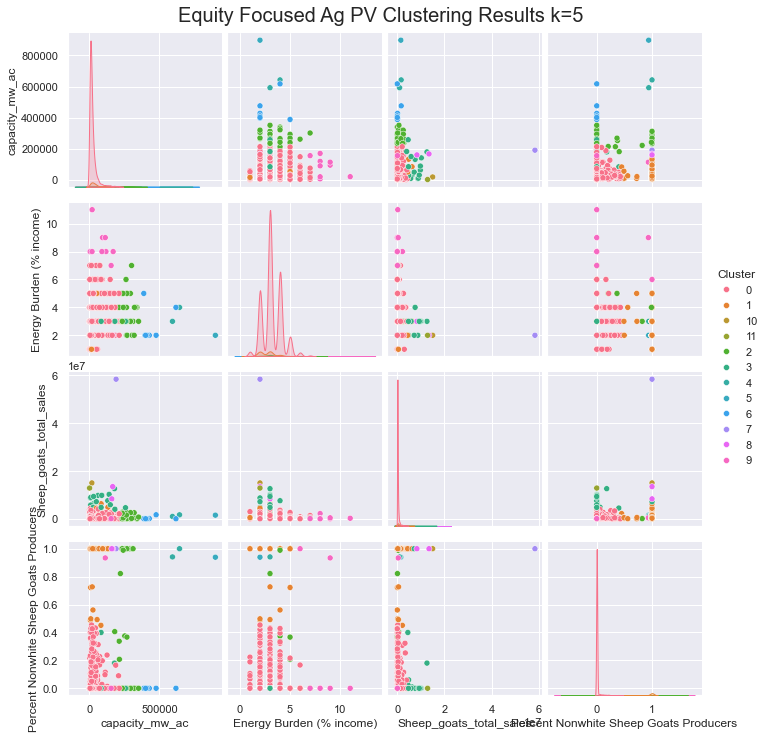

In [294]:
sns.pairplot(equity_cluster_df, hue='Cluster', hue_order=sorted(equity_cluster_df['Cluster'].unique()))
plt.suptitle(f'Equity Focused Ag PV Clustering Results k={k}', size=20, y=1.02)
plt.savefig(os.path.join(graph_dir, 'equity_agpv_pca_clustering.png'))

In [269]:
equity_cluster_df[equity_cluster_df['Cluster'] == '0']

capacity_mw_ac  Energy Burden (% income)  Sheep_goats_total_sales  \
FIPS                                                                       
04001   642890.582501                       4.0                  1651000   
04003   287109.296404                       3.0                   631000   
04005   898649.593988                       2.0                  1511000   
04007    99254.854730                       3.0                    45000   
04009   193371.836811                       3.0                        0   
...               ...                       ...                      ...   
56025   212886.939749                       2.0                  2078000   
56027   176565.725872                       5.0                    61000   
56029    91458.074630                       4.0                  2193000   
56031   107401.216358                       5.0                   105000   
56037   401041.398994                       2.0                        0   

       Percent Nonwhite Sheep Goats Producers Cluster  
FIPS                                                   
04001                                1.000000       0  
04003                                1.000000       0  
04005                                0.939185       0  
04007                                0.000000       0  
04009                                0.000000       0  
...                                       ...     ...  
56025                                0.000000       0  
56027                                0.000000       0  
56029                                0.000000       0  
56031                                0.000000       0  
56037                                0.000000       0  

[147 rows x 5 columns]

In [268]:
equity_cluster_df.groupby('Cluster').mean()

capacity_mw_ac  Energy Burden (% income)  Sheep_goats_total_sales  \
Cluster                                                                      
0         199503.642248                  3.435374             5.309116e+05   
1          16380.047965                  2.665420             2.686189e+05   
2          35316.212194                  2.715232             6.458609e+05   
3         190355.716993                  2.000000             5.838300e+07   
4          19334.579686                  4.312222             1.416344e+05   
5          81914.417515                  2.750000             1.033608e+07   

         Percent Nonwhite Sheep Goats Producers  
Cluster                                          
0                                      0.109550  
1                                      0.013315  
2                                      0.996351  
3                                      1.000000  
4                                      0.003108  
5                                      0.181699

In [242]:
equity_cluster_df.corr()

capacity_mw_ac  \
capacity_mw_ac                                1.000000   
Energy Burden (% income)                      0.083811   
Percent Minority Owned                        0.142842   
AgPV_crop_totals                              0.002171   
Sheep_goats_total_sales                       0.156034   
Percent Nonwhite Sheep Goats Producers        0.189113   
Cluster                                      -0.160997   

                                        Energy Burden (% income)  \
capacity_mw_ac                                          0.083811   
Energy Burden (% income)                                1.000000   
Percent Minority Owned                                  0.054850   
AgPV_crop_totals                                       -0.075113   
Sheep_goats_total_sales                                -0.071569   
Percent Nonwhite Sheep Goats Producers                 -0.116285   
Cluster                                                 0.402071   

                                        Percent Minority Owned  \
capacity_mw_ac                                        0.142842   
Energy Burden (% income)                              0.054850   
Percent Minority Owned                                1.000000   
AgPV_crop_totals                                     -0.010154   
Sheep_goats_total_sales                               0.004992   
Percent Nonwhite Sheep Goats Producers                0.075516   
Cluster                                               0.306412   

                                        AgPV_crop_totals  \
capacity_mw_ac                                  0.002171   
Energy Burden (% income)                       -0.075113   
Percent Minority Owned                         -0.010154   
AgPV_crop_totals                                1.000000   
Sheep_goats_total_sales                         0.015636   
Percent Nonwhite Sheep Goats Producers          0.024433   
Cluster                                         0.253450   

                                        Sheep_goats_total_sales  \
capacity_mw_ac                                         0.156034   
Energy Burden (% income)                              -0.071569   
Percent Minority Owned                                 0.004992   
AgPV_crop_totals                                       0.015636   
Sheep_goats_total_sales                                1.000000   
Percent Nonwhite Sheep Goats Producers                 0.152161   
Cluster                                                0.033867   

                                        Percent Nonwhite Sheep Goats Producers  \
capacity_mw_ac                                                        0.189113   
Energy Burden (% income)                                             -0.116285   
Percent Minority Owned                                                0.075516   
AgPV_crop_totals                                                      0.024433   
Sheep_goats_total_sales                                               0.152161   
Percent Nonwhite Sheep Goats Producers                                1.000000   
Cluster                                                               0.454291   

                                         Cluster  
capacity_mw_ac                         -0.160997  
Energy Burden (% income)                0.402071  
Percent Minority Owned                  0.306412  
AgPV_crop_totals                        0.253450  
Sheep_goats_total_sales                 0.033867  
Percent Nonwhite Sheep Goats Producers  0.454291  
Cluster                                 1.000000

In [243]:
merged_df.columns

Index(['county', 'state', 'capacity_mw_ac', 'capacity_mw_dc', 'RESL_SCORE',
       'SOVI_SCORE', 'TRND_ALRA', 'TRND_RISKV', 'TRND_RISKS', 'HWAV_ALRA',
       'HWAV_RISKV', 'HWAV_RISKS', 'HAIL_ALRA', 'HAIL_RISKV', 'HAIL_RISKS',
       'DRGT_ALRA', 'DRGT_RISKV', 'DRGT_RISKS', 'Energy Burden (% income)',
       'Avg Farm Net Income ($)', 'Percent Minority Owned',
       'Percent Non Investor Owned', 'Value_veggies', 'Undisclosed_veggies',
       'Value_berries', 'Undisclosed_berries', 'AgPV_crop_totals',
       'Sheep_goats_total_sales', 'Undisclosed_goats_sheep_totals',
       'Percent Nonwhite Sheep Goats Producers',
       'Undisclosed_goats_sheep_producers', 'tonne_co2_per_person',
       'SolarPanelLandUse', 'Negative Net Farm Income'],
      dtype='object')